In [1]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


Using TensorFlow backend.


In [4]:
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (3):
        
    score_list = []
    
    if not os.path.exists("results/set_%s" % training_set_number):
        os.makedirs("results/set_%s" % training_set_number)
    
    for protein in protein_list:
        
        if not os.path.exists("results/set_%s/%s" % (training_set_number,protein)):
            os.makedirs("results/set_%s/%s" % (training_set_number,protein))
    
        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(60,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(60, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

      
        #Save score list
        with open ("results/set_%s/%s/score" % (training_set_number, protein), "w") as score_file:
            np.save(("results/set_%s/%s/score" % (training_set_number, protein)), score)
        
        #Save model and weights to .json file.
        json_model = model.to_json()
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "w") as json_file:
            json_file.write(json_model)
        with open ("results/set_%s/%s/weights.h5" % (training_set_number, protein), "w") as weights_file:
            model.save_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
        
        #Save the model metrics generated with model fit.
        with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "w") as pickle_file:
            pickle.dump(metrics, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)



1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19
1_PARCLIP_AGO1234_hg19


In [5]:
from keras.models import model_from_json

# Run predictions on all of the 3 test datasets.
for training_set_number in range (3):
    for protein in protein_list:
       
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            loaded_model = model_from_json(json)
            loaded_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))


        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)


        #Run predictions on test dataset and save them.
        predictions = loaded_model.predict(X_test)
                                              
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "w") as predictions_file:
            np.save(predictions_file, predictions)



1_PARCLIP_AGO1234_hg19


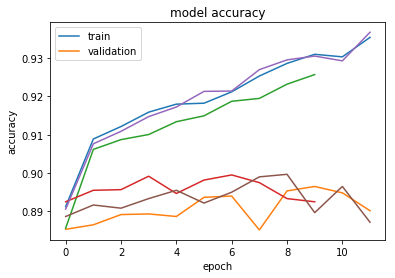

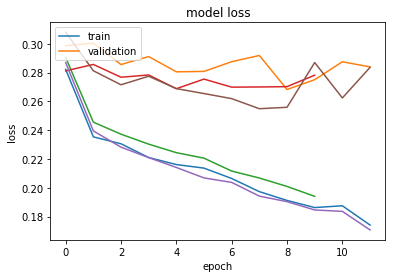

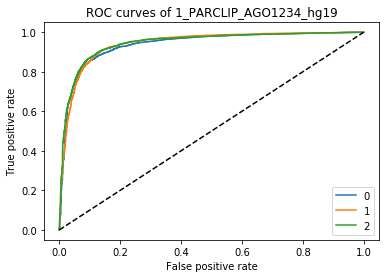

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 1_PARCLIP_AGO1234_hg19, with the average AUC of 0.9415269374999999 across all three datasets.
2_PARCLIP_AGO2MNASE_hg19


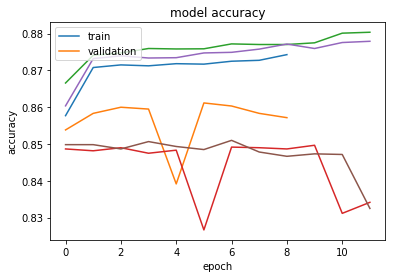

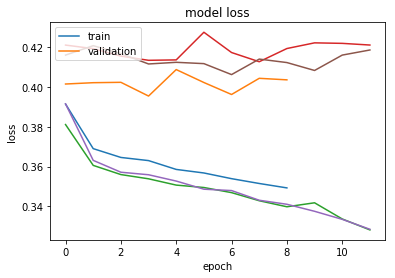

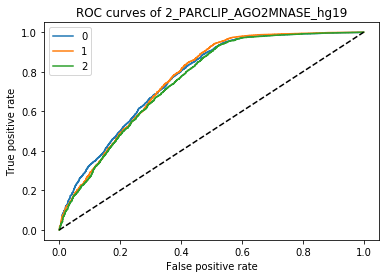

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 2_PARCLIP_AGO2MNASE_hg19, with the average AUC of 0.7638940208333332 across all three datasets.
3_HITSCLIP_Ago2_binding_clusters


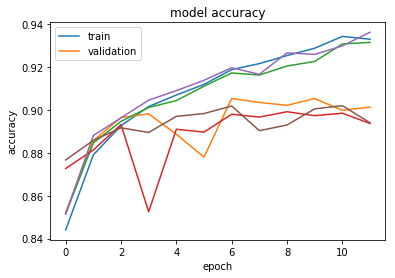

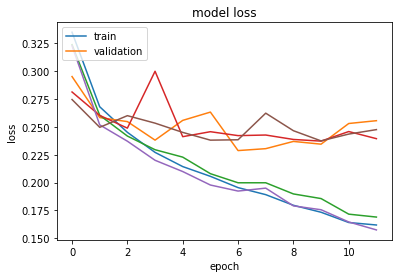

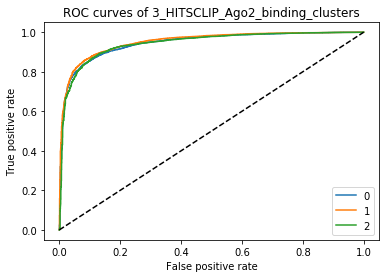

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 3_HITSCLIP_Ago2_binding_clusters, with the average AUC of 0.9469245729166668 across all three datasets.
4_HITSCLIP_Ago2_binding_clusters_2


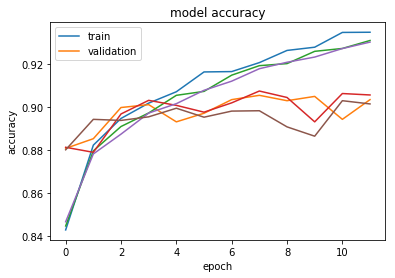

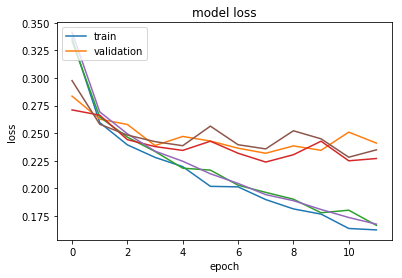

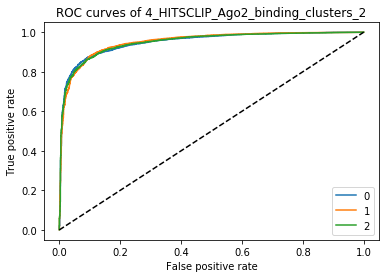

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 4_HITSCLIP_Ago2_binding_clusters_2, with the average AUC of 0.9504045208333333 across all three datasets.
5_CLIPSEQ_AGO2_hg19


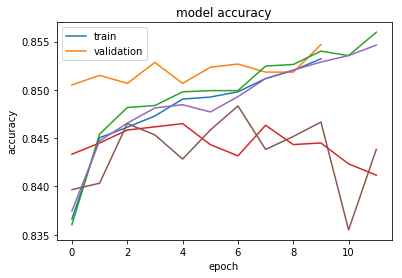

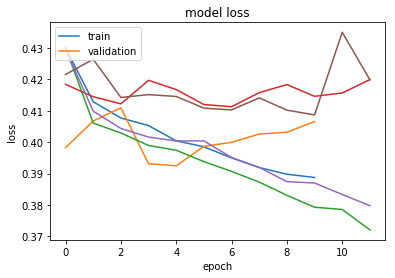

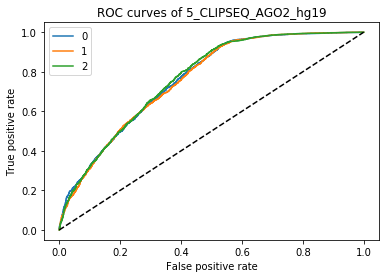

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 5_CLIPSEQ_AGO2_hg19, with the average AUC of 0.7625171979166666 across all three datasets.
6_CLIP-seq-eIF4AIII_1


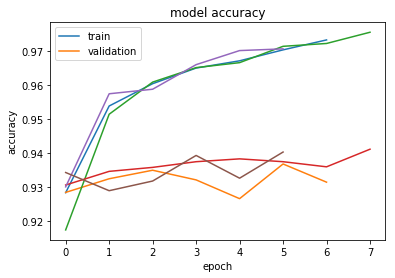

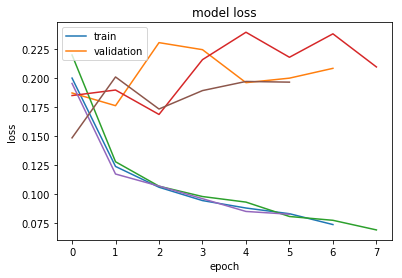

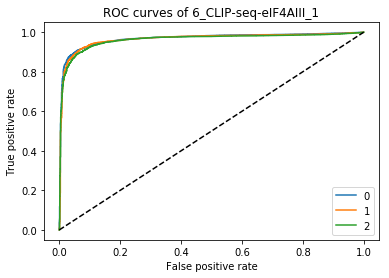

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 6_CLIP-seq-eIF4AIII_1, with the average AUC of 0.9646419583333333 across all three datasets.
7_CLIP-seq-eIF4AIII_2


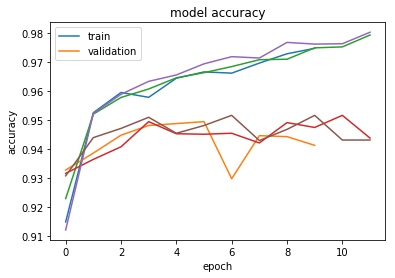

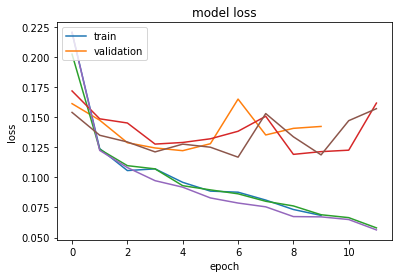

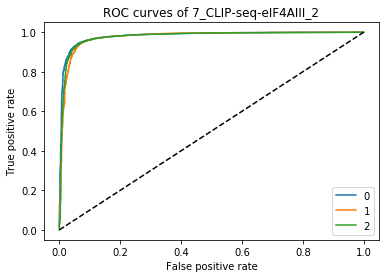

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 7_CLIP-seq-eIF4AIII_2, with the average AUC of 0.9777796041666665 across all three datasets.
8_PARCLIP_ELAVL1_hg19


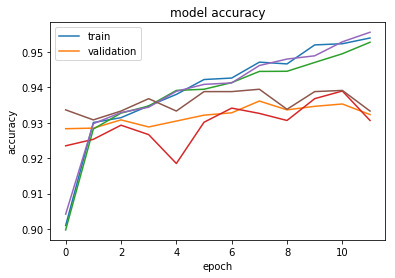

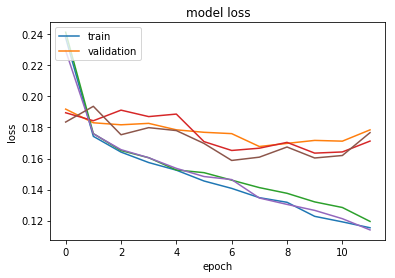

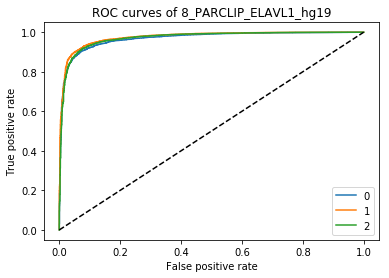

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 8_PARCLIP_ELAVL1_hg19, with the average AUC of 0.9716445208333333 across all three datasets.
9_PARCLIP_ELAVL1MNASE_hg19


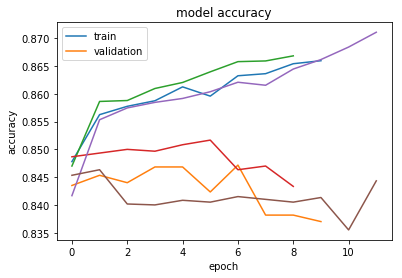

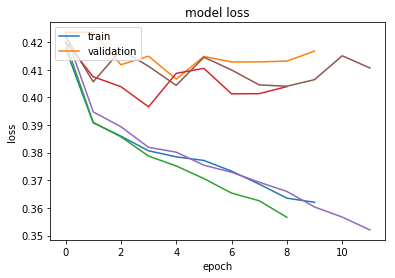

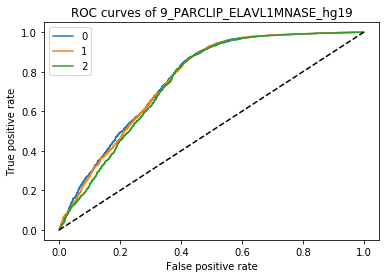

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 9_PARCLIP_ELAVL1MNASE_hg19, with the average AUC of 0.7603426041666667 across all three datasets.
10_PARCLIP_ELAVL1A_hg19


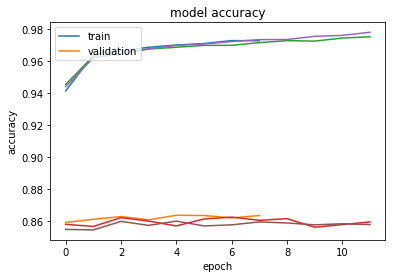

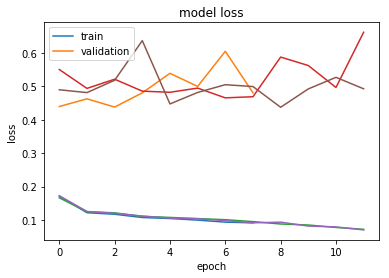

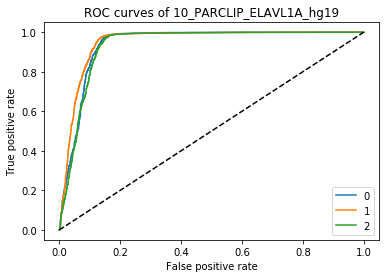

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 10_PARCLIP_ELAVL1A_hg19, with the average AUC of 0.9409876458333333 across all three datasets.
10_PARCLIP_ELAVL1A_hg19


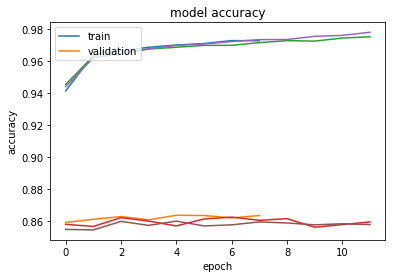

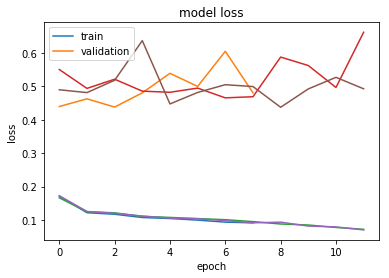

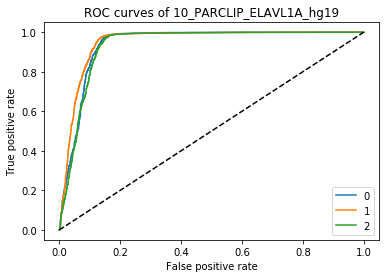

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 10_PARCLIP_ELAVL1A_hg19, with the average AUC of 0.9409876458333333 across all three datasets.
12_PARCLIP_EWSR1_hg19


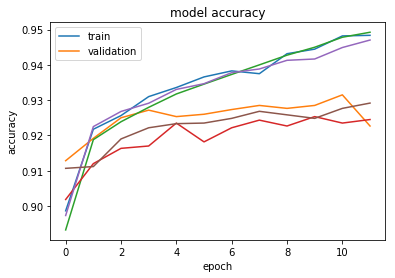

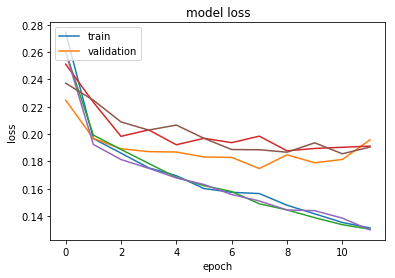

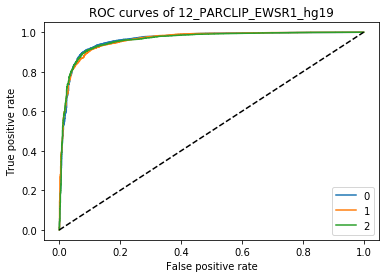

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 12_PARCLIP_EWSR1_hg19, with the average AUC of 0.9615103125000001 across all three datasets.
13_PARCLIP_FUS_hg19


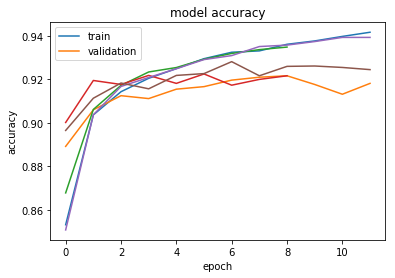

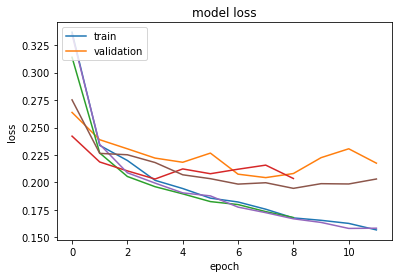

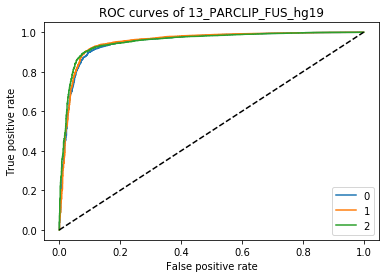

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 13_PARCLIP_FUS_hg19, with the average AUC of 0.9509823125 across all three datasets.
14_PARCLIP_FUS_mut_hg19


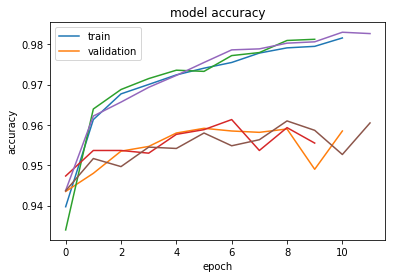

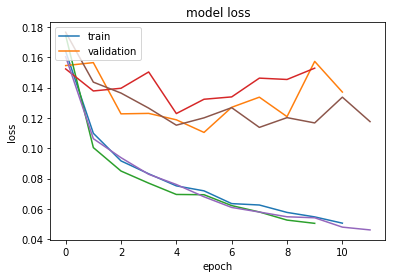

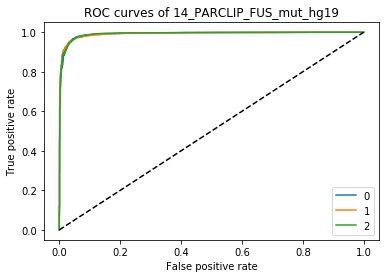

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 14_PARCLIP_FUS_mut_hg19, with the average AUC of 0.9914229999999998 across all three datasets.
15_PARCLIP_IGF2BP123_hg19


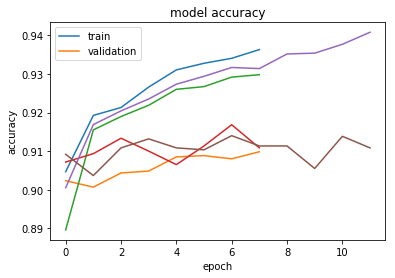

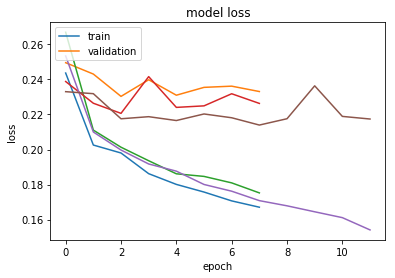

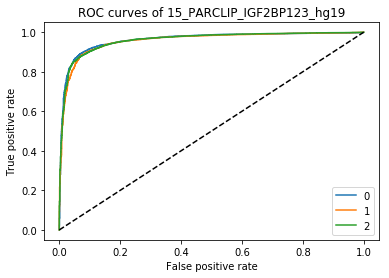

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 15_PARCLIP_IGF2BP123_hg19, with the average AUC of 0.9596266875 across all three datasets.
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


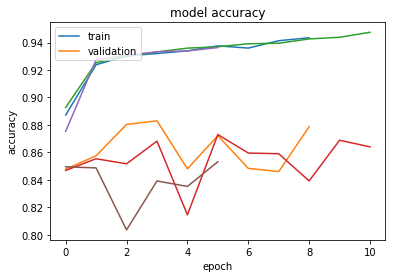

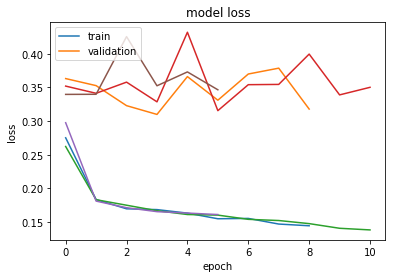

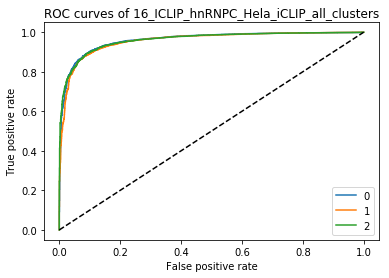

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters, with the average AUC of 0.9592375520833333 across all three datasets.
17_ICLIP_HNRNPC_hg19


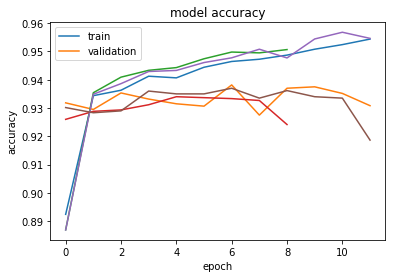

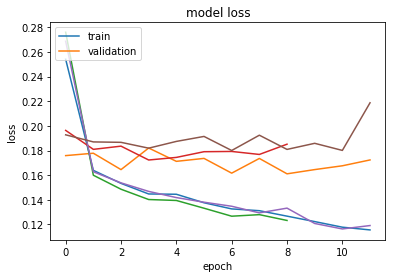

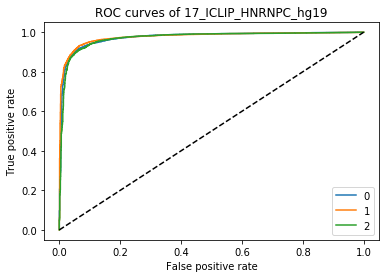

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 17_ICLIP_HNRNPC_hg19, with the average AUC of 0.97352265625 across all three datasets.
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


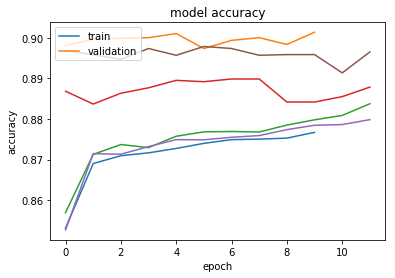

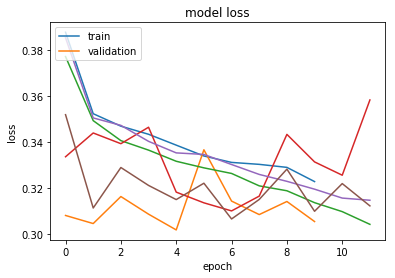

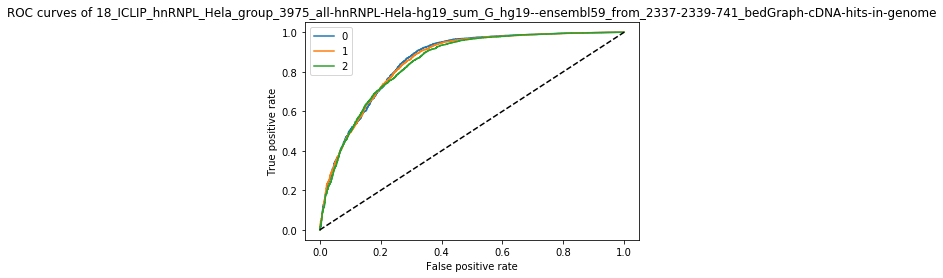

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.85316784375 across all three datasets.
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


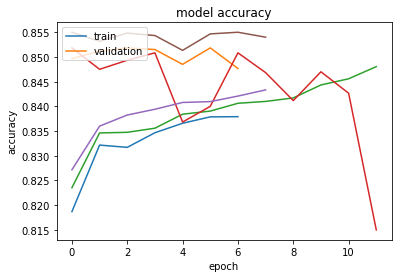

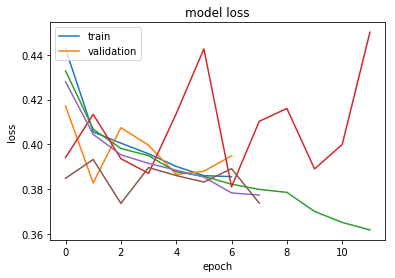

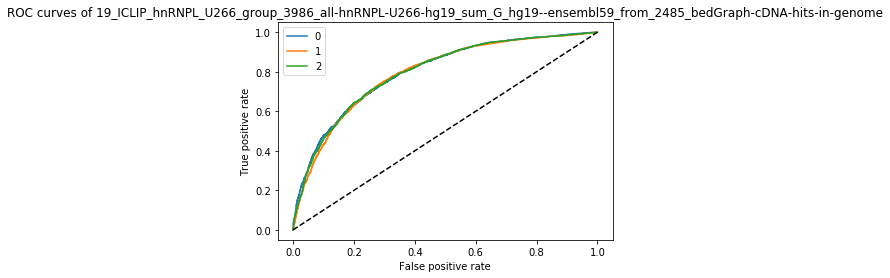

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7961081249999999 across all three datasets.
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


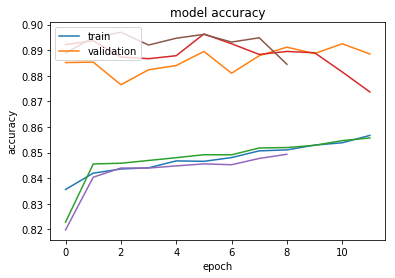

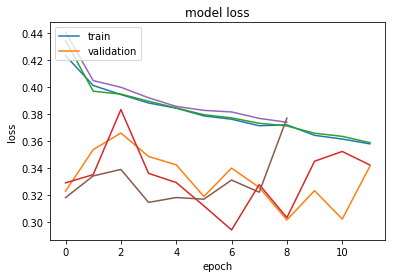

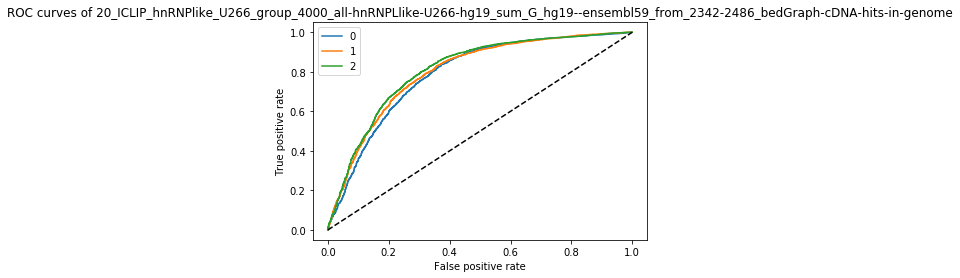

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7985244895833333 across all three datasets.
21_PARCLIP_MOV10_Sievers_hg19


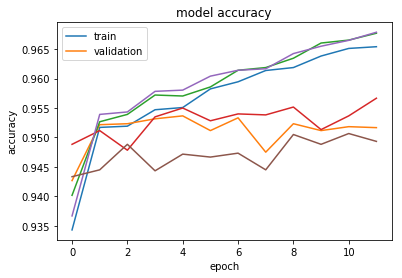

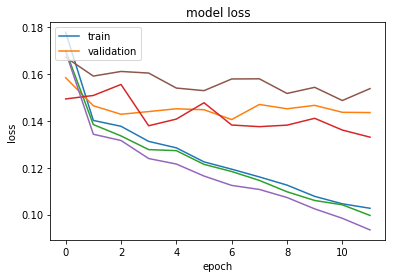

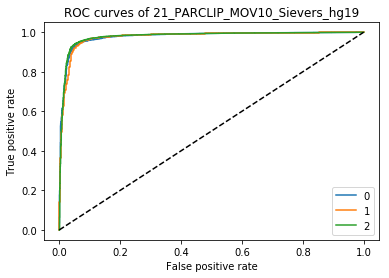

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 21_PARCLIP_MOV10_Sievers_hg19, with the average AUC of 0.9773746458333333 across all three datasets.
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


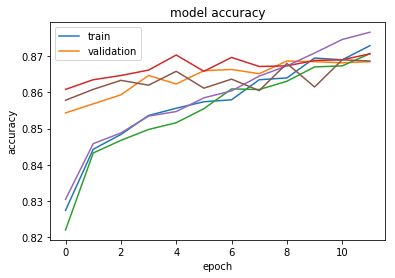

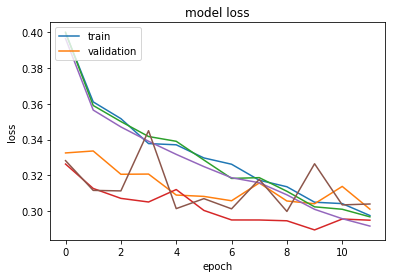

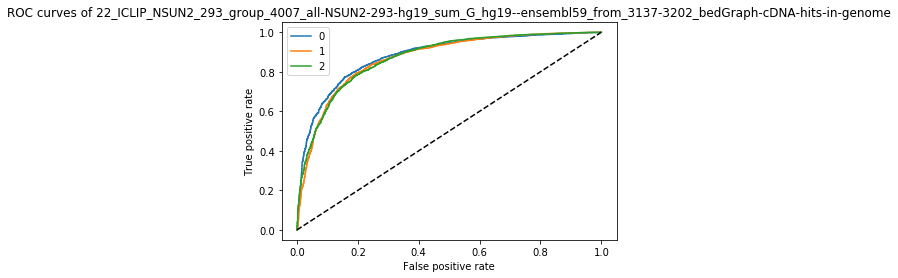

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.8737919270833333 across all three datasets.
23_PARCLIP_PUM2_hg19


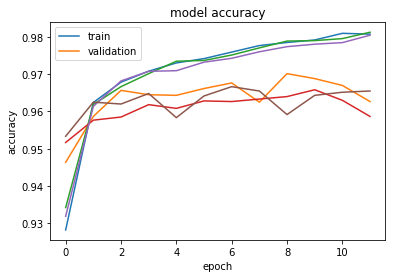

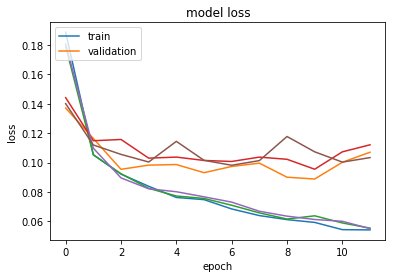

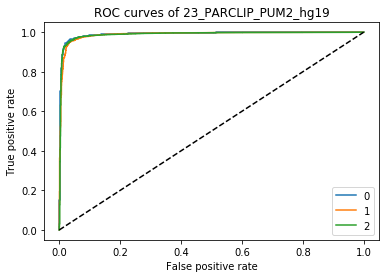

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 23_PARCLIP_PUM2_hg19, with the average AUC of 0.9893710416666667 across all three datasets.
24_PARCLIP_QKI_hg19


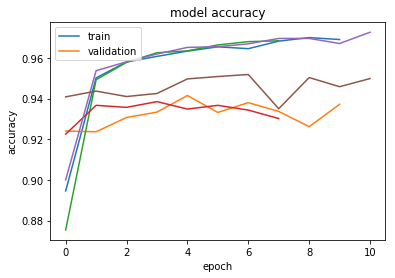

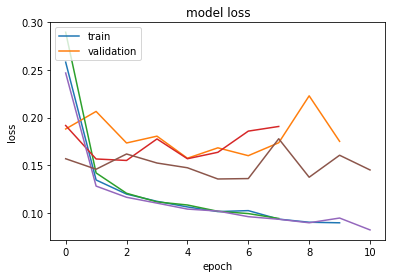

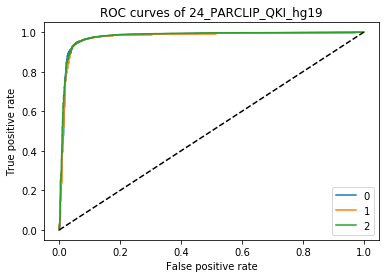

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 24_PARCLIP_QKI_hg19, with the average AUC of 0.9768500625 across all three datasets.
25_CLIPSEQ_SFRS1_hg19


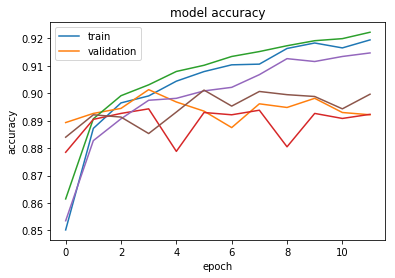

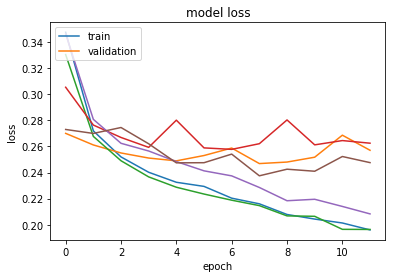

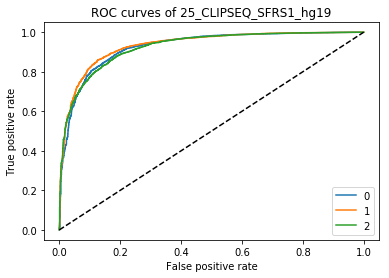

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 25_CLIPSEQ_SFRS1_hg19, with the average AUC of 0.9285752604166667 across all three datasets.
26_PARCLIP_TAF15_hg19


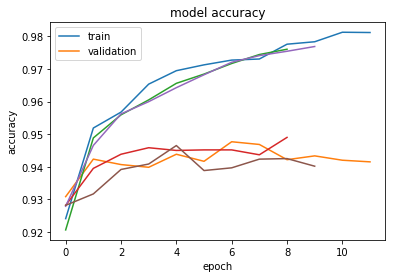

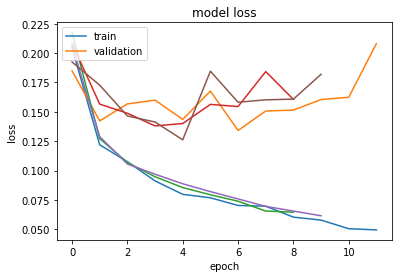

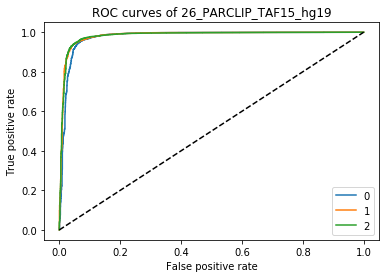

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 26_PARCLIP_TAF15_hg19, with the average AUC of 0.9802493958333335 across all three datasets.
27_ICLIP_TDP43_hg19


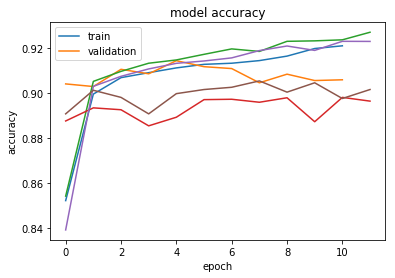

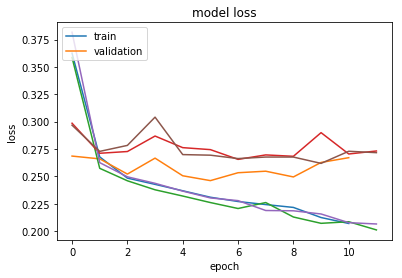

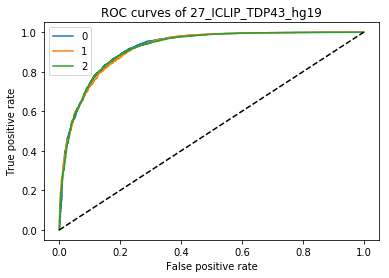

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 27_ICLIP_TDP43_hg19, with the average AUC of 0.9206464375 across all three datasets.
28_ICLIP_TIA1_hg19


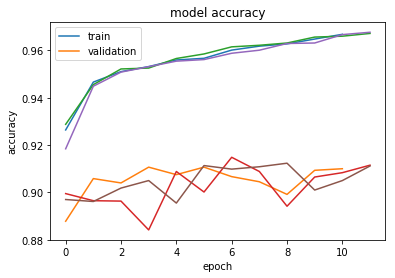

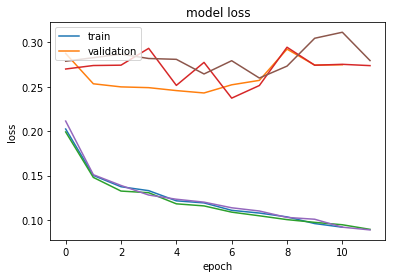

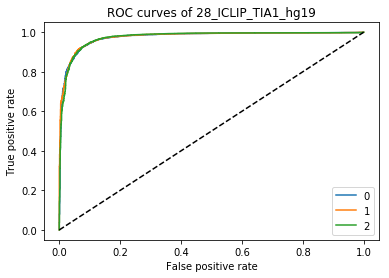

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 28_ICLIP_TIA1_hg19, with the average AUC of 0.9752165729166666 across all three datasets.
29_ICLIP_TIAL1_hg19


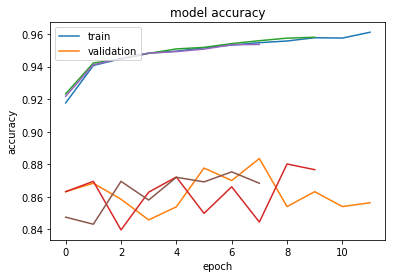

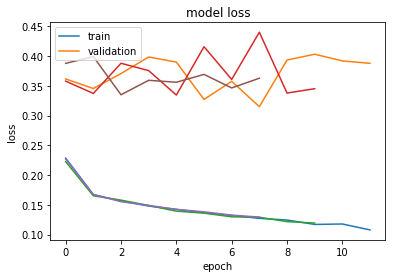

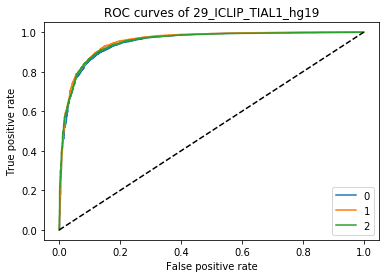

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 29_ICLIP_TIAL1_hg19, with the average AUC of 0.9522379895833333 across all three datasets.
30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


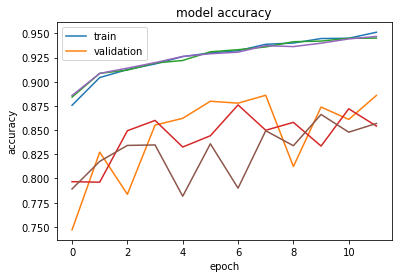

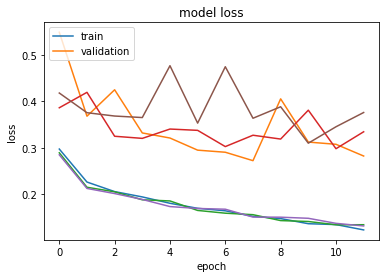

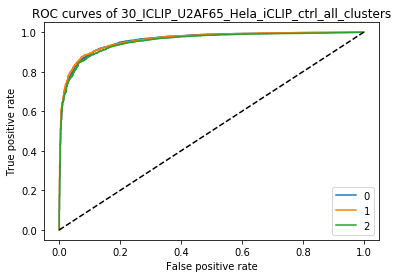

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters, with the average AUC of 0.9588924166666667 across all three datasets.
31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


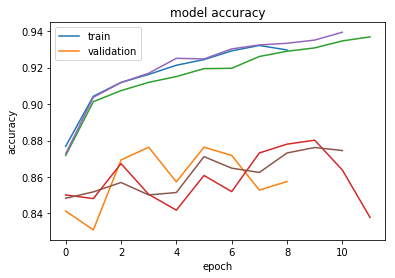

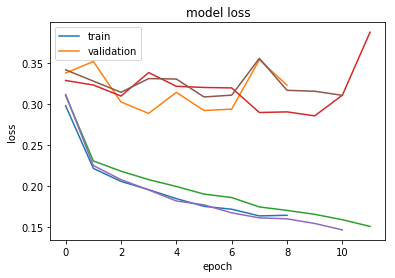

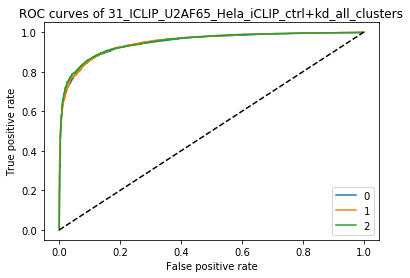

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters, with the average AUC of 0.9488931458333333 across all three datasets.


In [2]:
# Plot accuracy, loss values and ROC.

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for protein in protein_list:
    average_score = np.zeros(3)
    print (protein)

    for training_set_number in range (3):
        #Load the model metrics generated with model fit.
        
        with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "r") as pickle_file:
            metrics = pickle.load(pickle_file)
        
            # Plot history for accuracy.                
            plt.figure (1)
            plt.plot(metrics.history['acc'])
            plt.plot(metrics.history['val_acc'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            

            # Plot loss function history.
            plt.figure (2)
            plt.plot(metrics.history['loss'])
            plt.plot(metrics.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
          

        #Load model predictions.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            loaded_predictions = np.load (predictions_file)

            # Evaluate model performance.
            y_scores = loaded_predictions [:,0:1]
            y_test = get_class(protein,"test",training_set_number)
            y_test = y_test [:,0:1]

            score = roc_auc_score(y_test, y_scores)

            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
         
       
            #ROC plot
            plt.figure(3)
            plt.plot(fpr, tpr)
       
                 
        average_score[training_set_number] = score
    
    plt.figure(3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves of %s' %protein)
    plt.legend(["0","1","2"], loc='best')
    plt.show()
    print ("Plots of accuracy, loss function during traing and a ROC curve of model's predictions on %s, with the average AUC of %s across all three datasets." % (protein, np.mean(average_score)))
   
    plt.close('all')

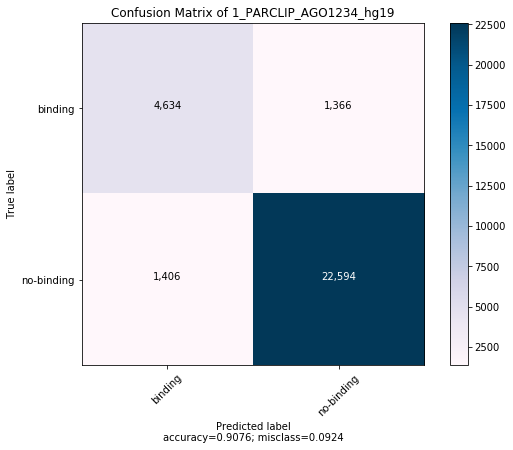

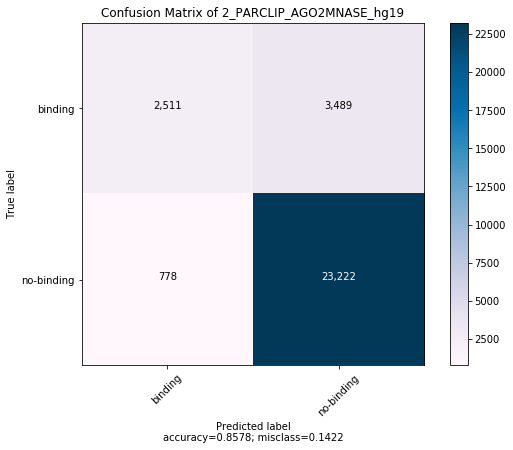

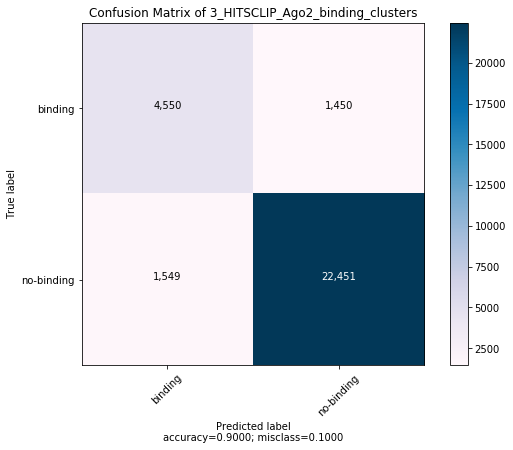

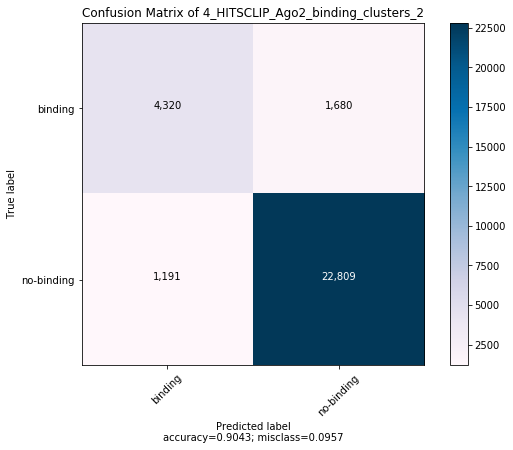

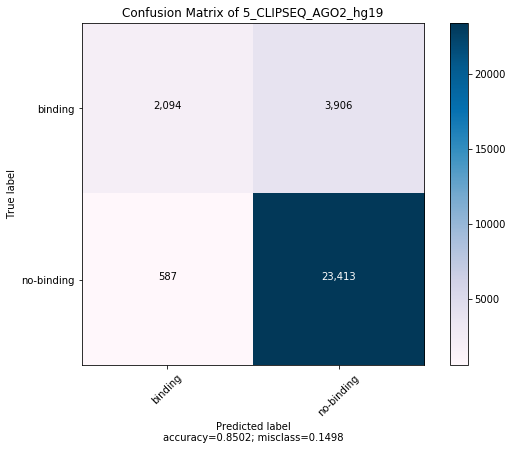

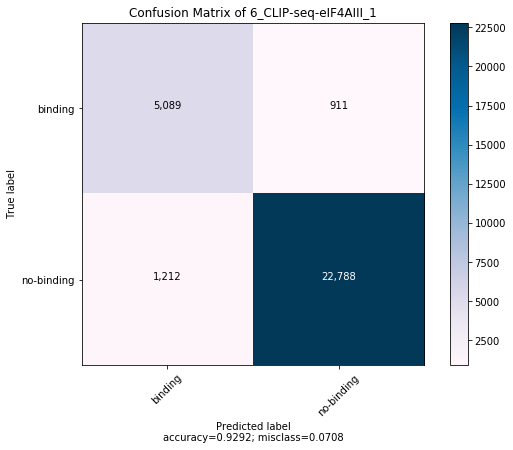

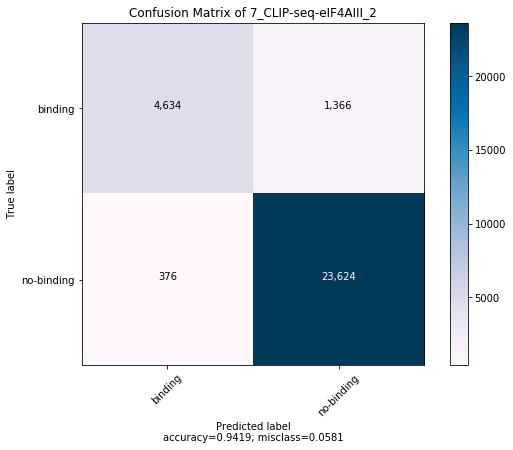

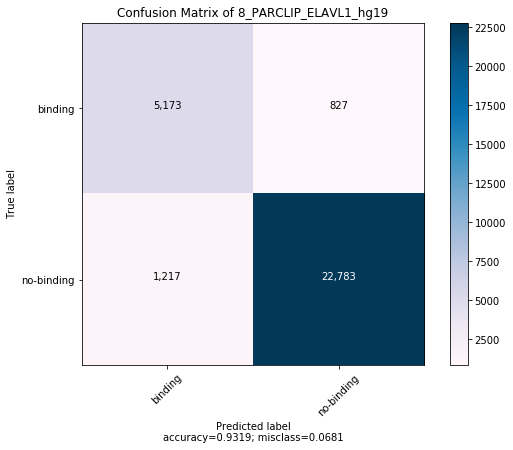

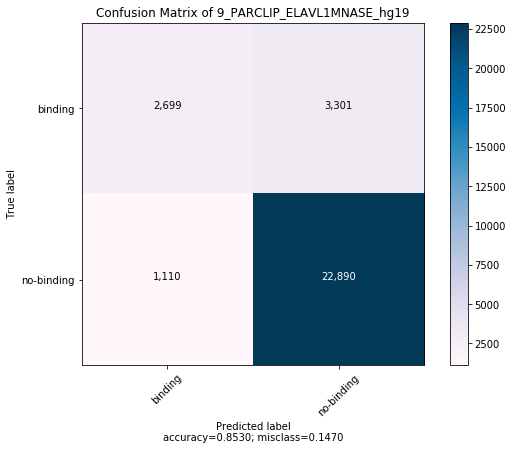

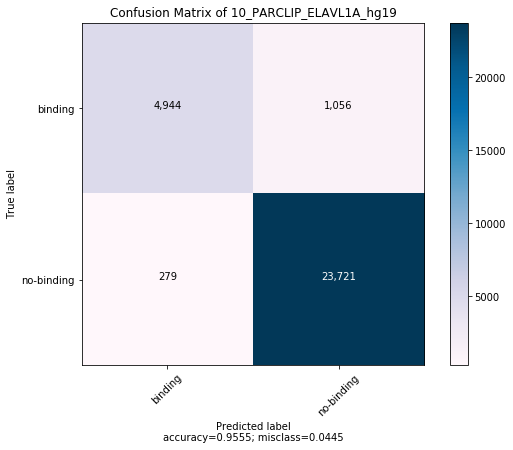

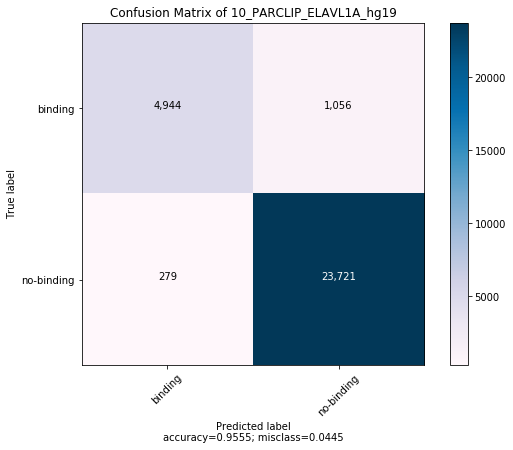

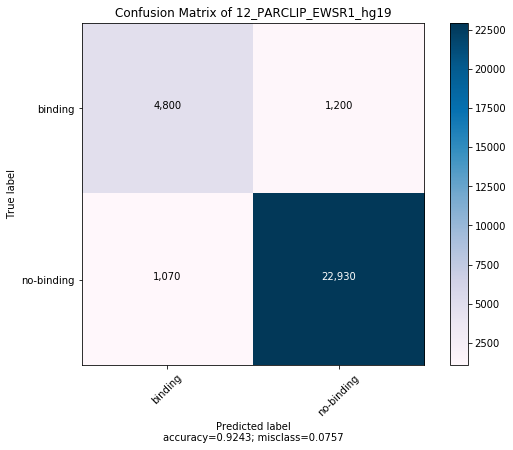

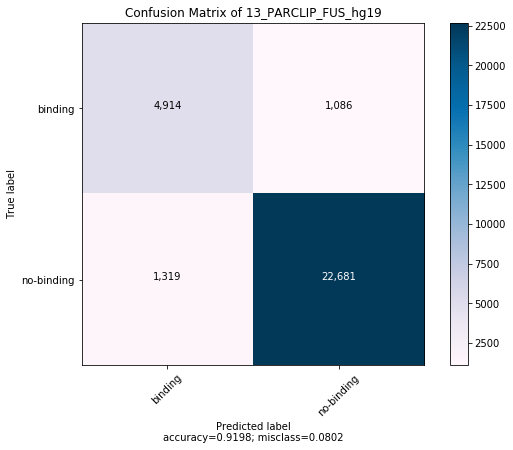

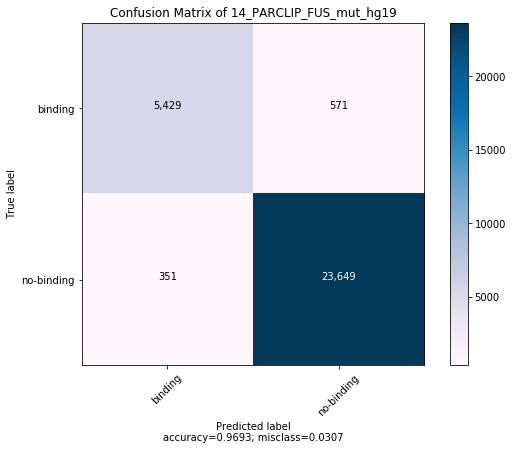

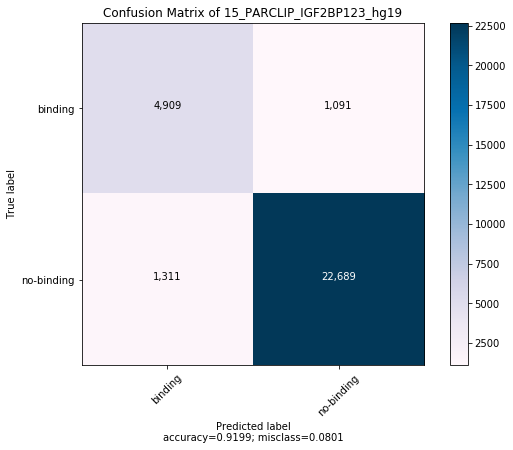

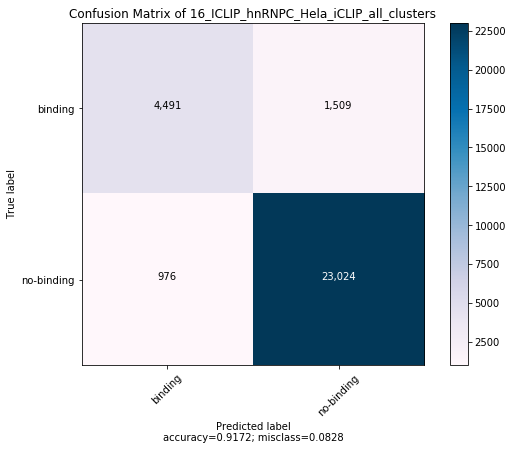

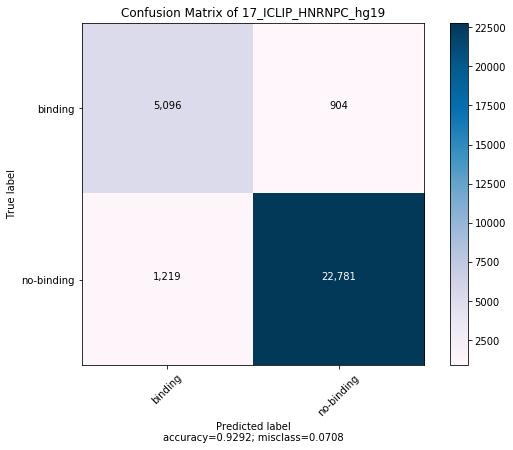

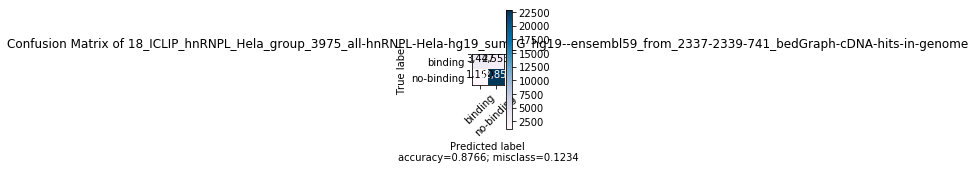

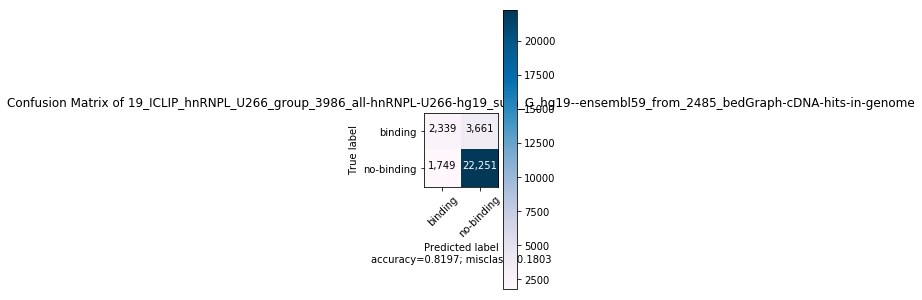

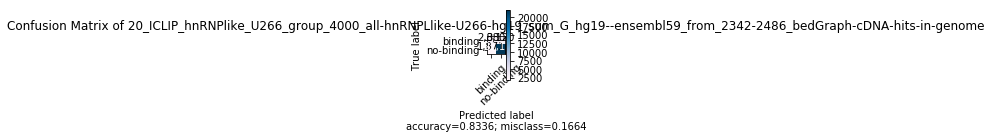

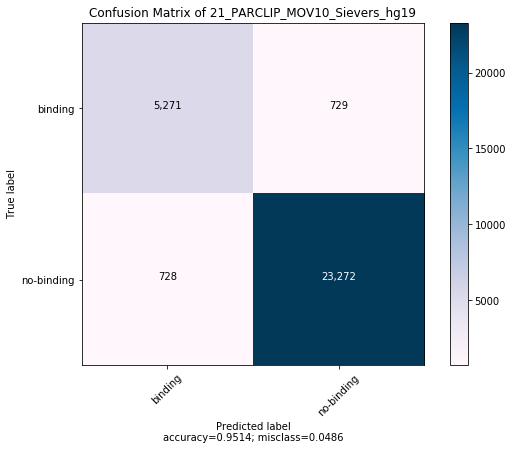

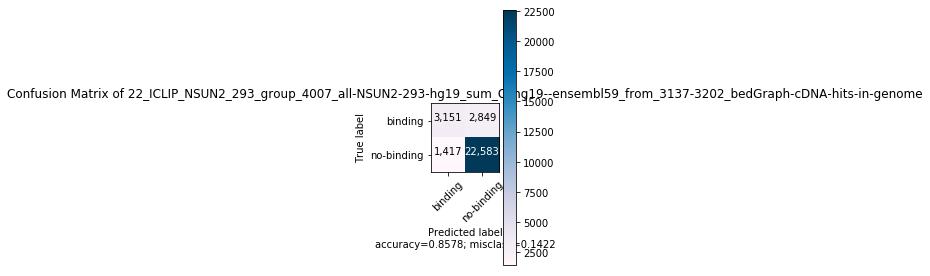

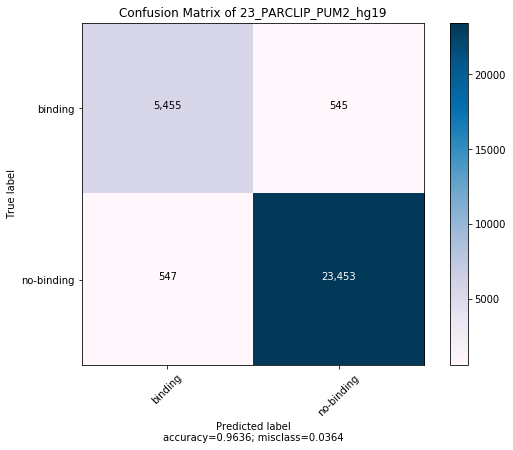

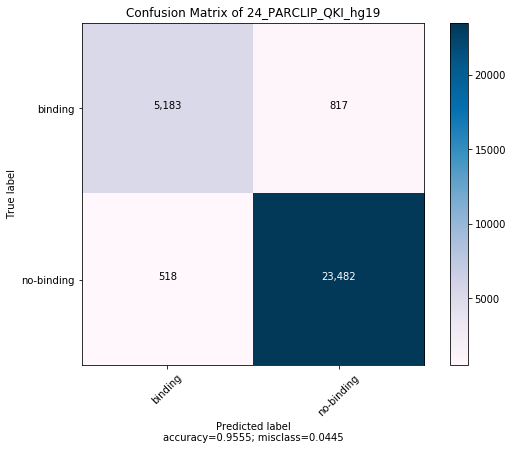

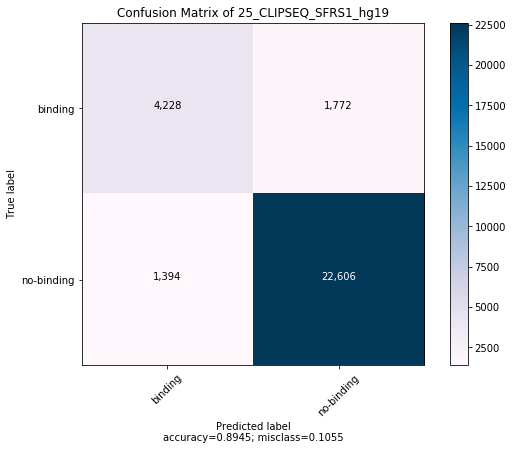

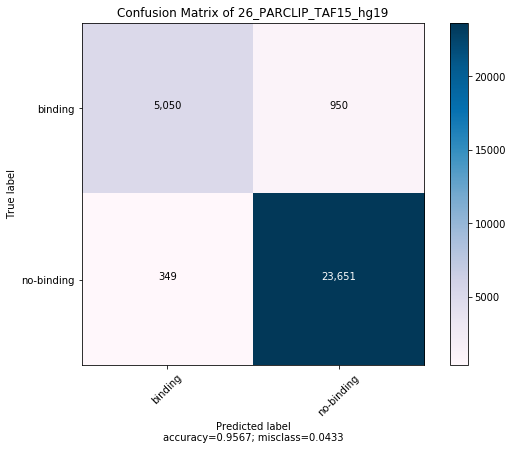

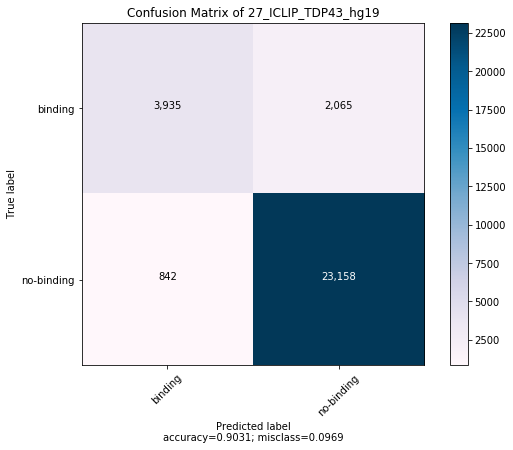

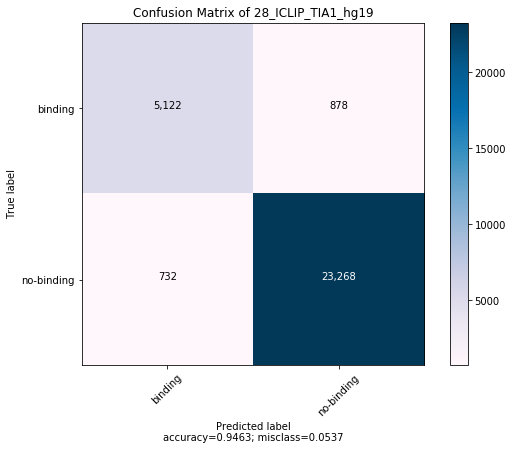

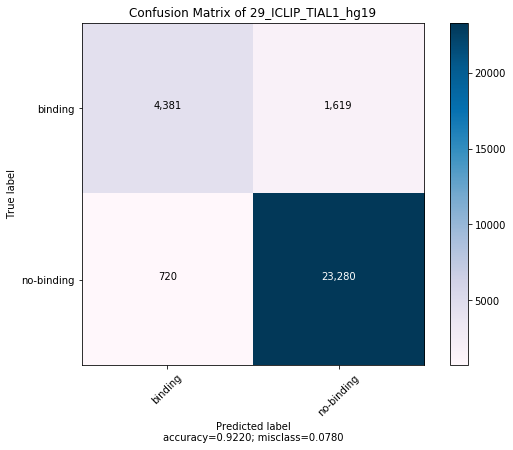

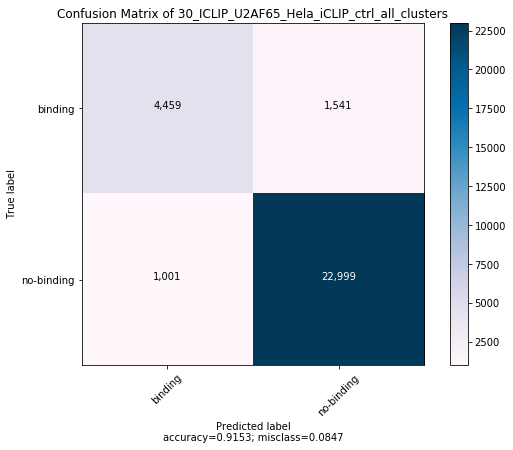

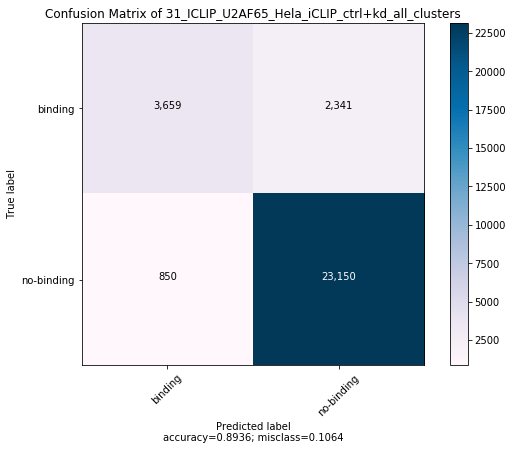

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    """

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('PuBu')

    plt.figure(figsize=(8, 6))
    plt.imshow((cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
  
    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []

    for training_set_number in range (3):
        
        #Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)

            #Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            binary_prediction = np.argmax(prediction,axis=1)

            #y_test = np.argmax(y_test, axis=1)
            y_test = get_class(protein,"test",training_set_number)[:,1]
            y_test
            

            complete_predictions.append(binary_prediction[:])
            complete_y_test.append(y_test[:])
            

    complete_predictions = np.ravel(complete_predictions)
    complete_y_test = np.ravel(complete_y_test) 
       
  
    cm = confusion_matrix(complete_y_test, complete_predictions)
    # Outputs an array with [tn, fp], [fn, tp]
    
    
    cm = np.flip(cm, 0)
    cm = np.flip(cm, 1)

    
    plot_confusion_matrix(cm, target_names = ['binding', 'no-binding'], 
                      title = "Confusion Matrix of %s" % (protein),
                      cmap = 'PuBu')
       
            


1_PARCLIP_AGO1234_hg19


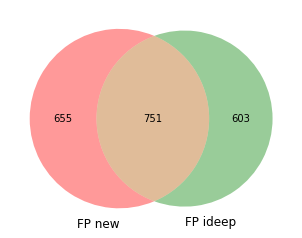

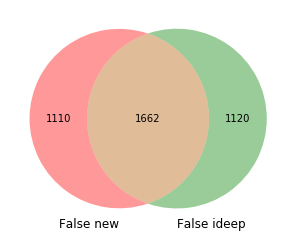

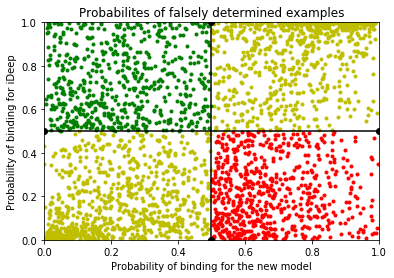

2_PARCLIP_AGO2MNASE_hg19


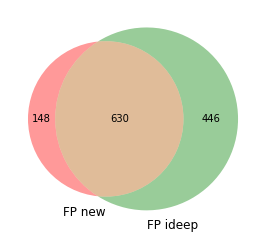

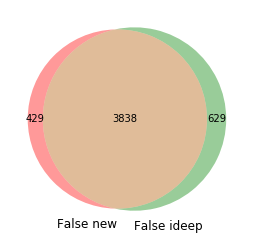

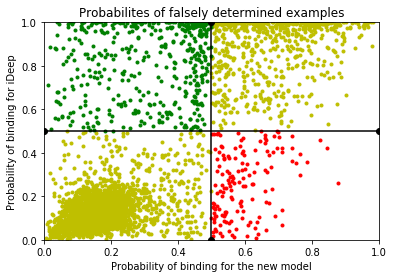

3_HITSCLIP_Ago2_binding_clusters


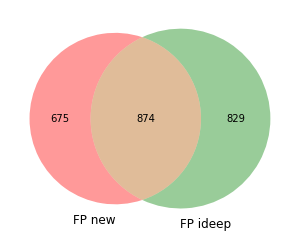

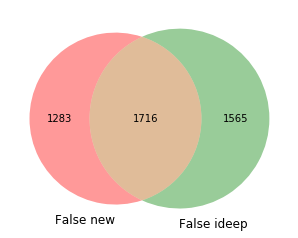

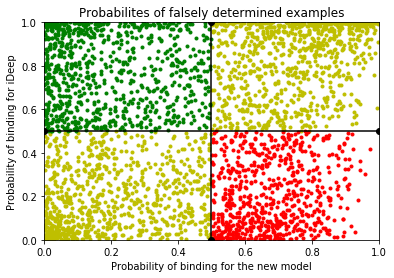

4_HITSCLIP_Ago2_binding_clusters_2


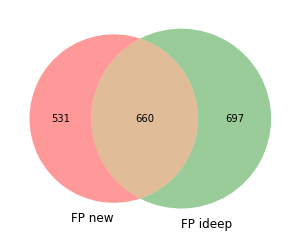

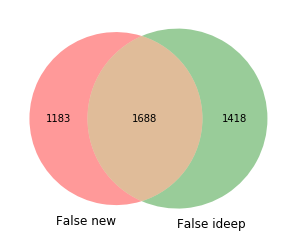

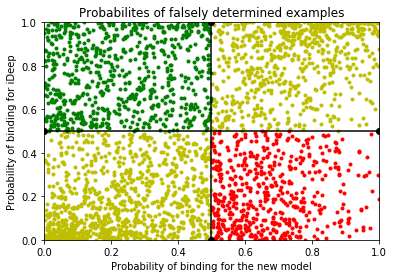

5_CLIPSEQ_AGO2_hg19


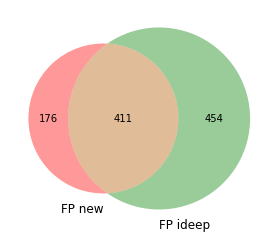

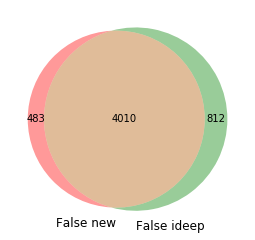

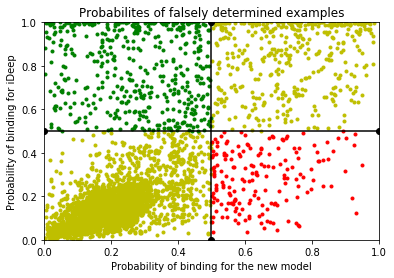

6_CLIP-seq-eIF4AIII_1


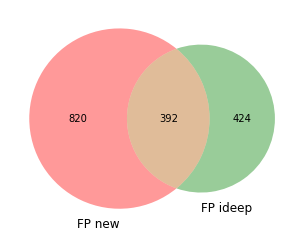

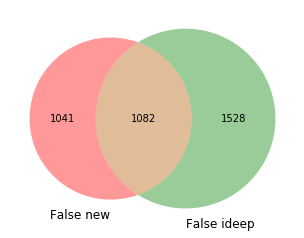

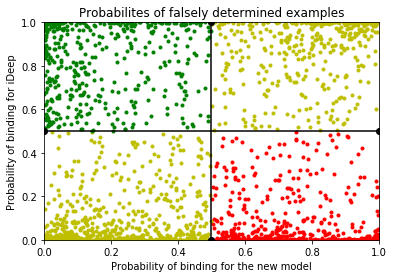

7_CLIP-seq-eIF4AIII_2


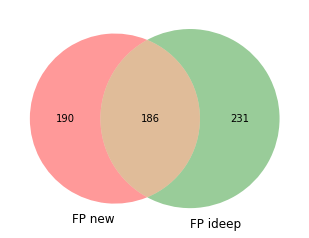

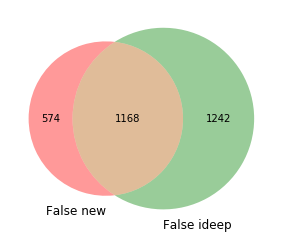

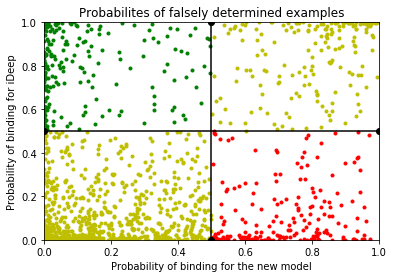

8_PARCLIP_ELAVL1_hg19


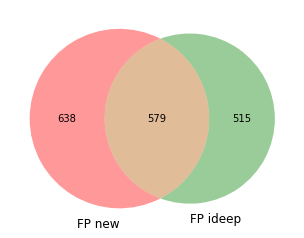

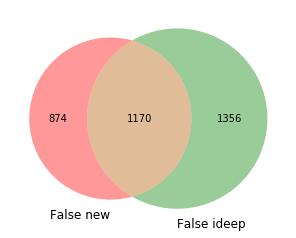

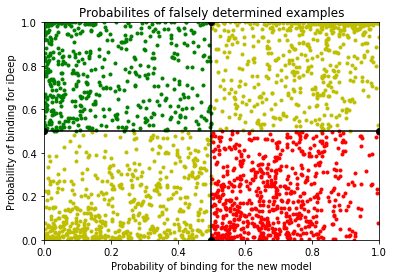

9_PARCLIP_ELAVL1MNASE_hg19


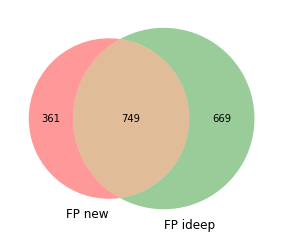

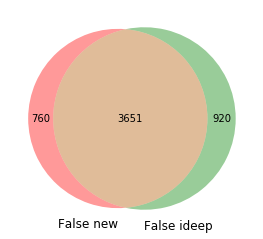

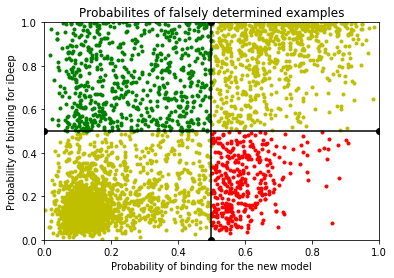

10_PARCLIP_ELAVL1A_hg19


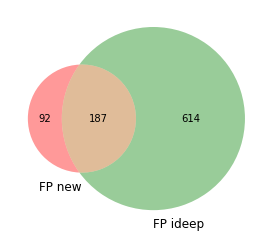

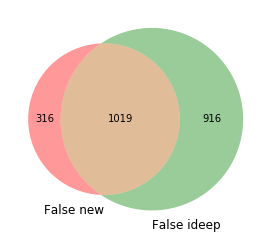

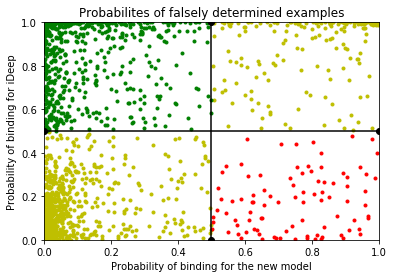

10_PARCLIP_ELAVL1A_hg19


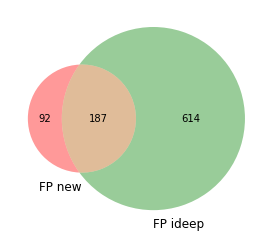

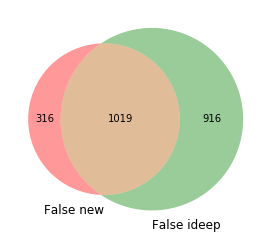

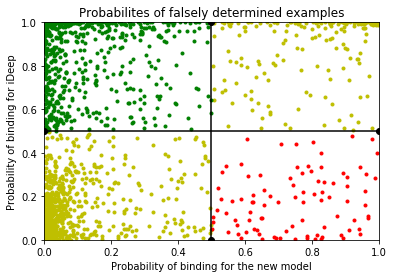

12_PARCLIP_EWSR1_hg19


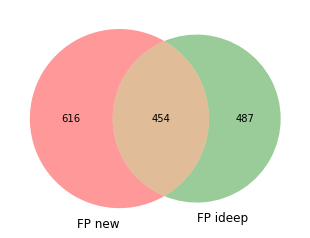

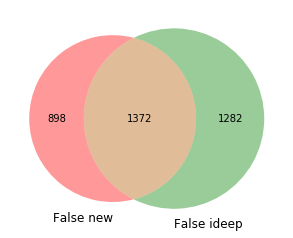

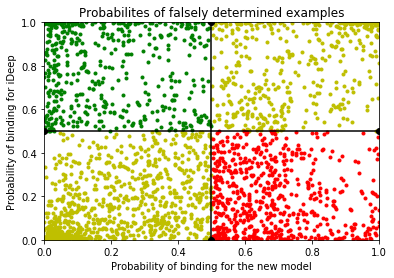

13_PARCLIP_FUS_hg19


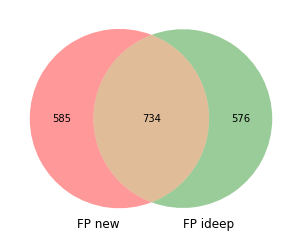

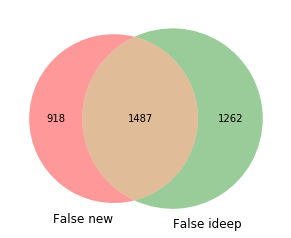

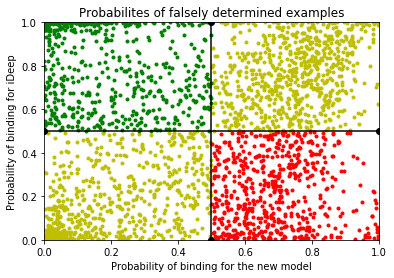

14_PARCLIP_FUS_mut_hg19


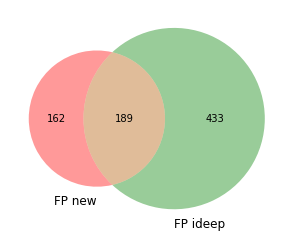

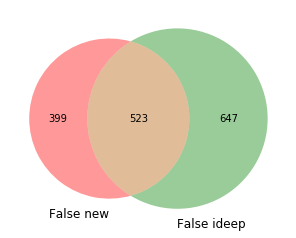

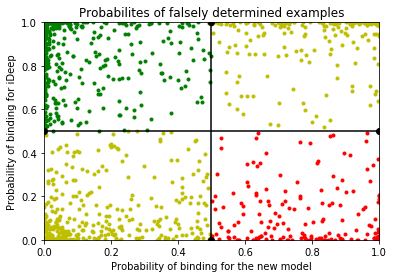

15_PARCLIP_IGF2BP123_hg19


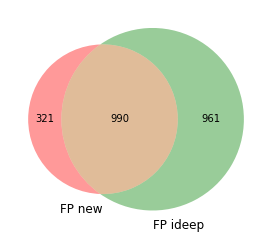

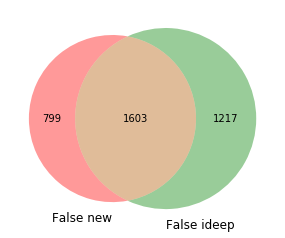

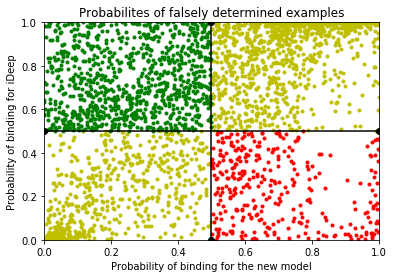

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


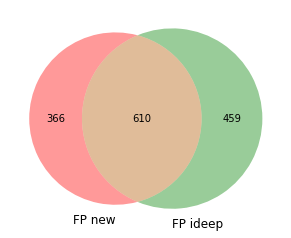

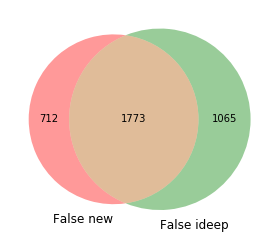

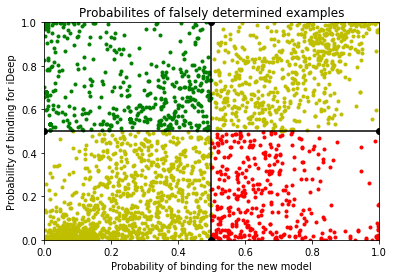

17_ICLIP_HNRNPC_hg19


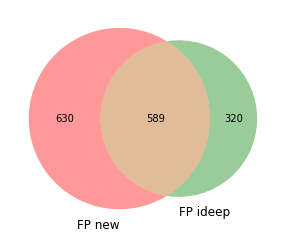

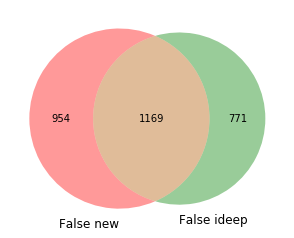

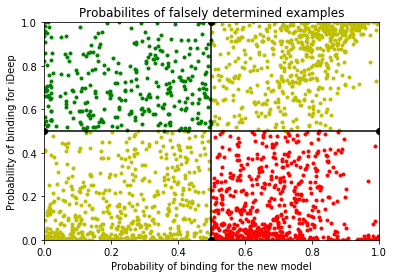

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


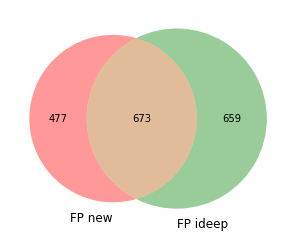

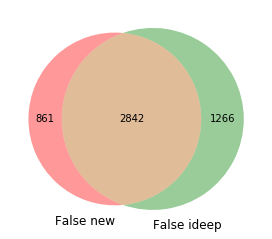

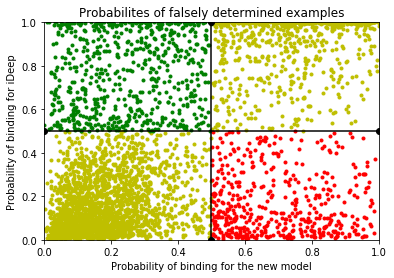

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


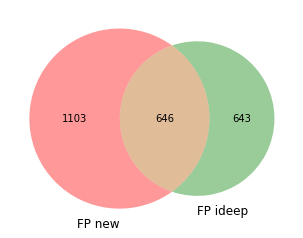

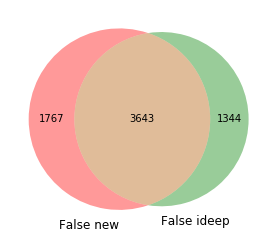

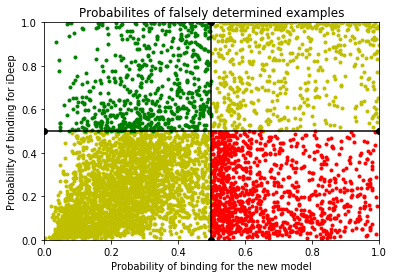

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


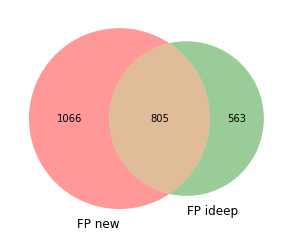

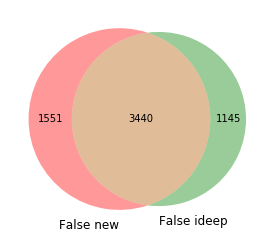

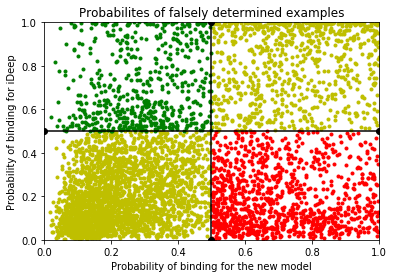

21_PARCLIP_MOV10_Sievers_hg19


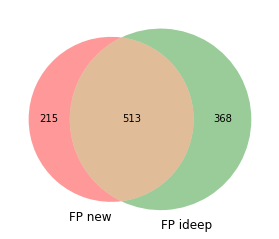

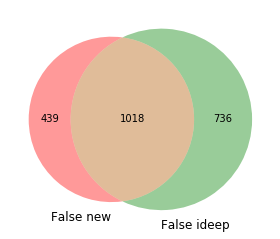

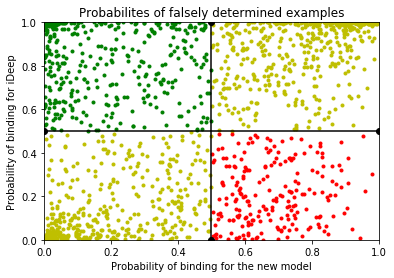

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


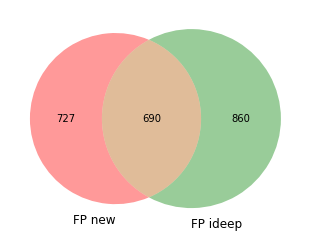

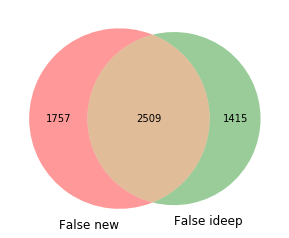

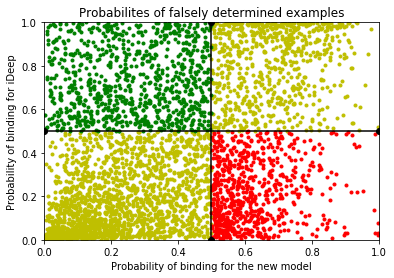

23_PARCLIP_PUM2_hg19


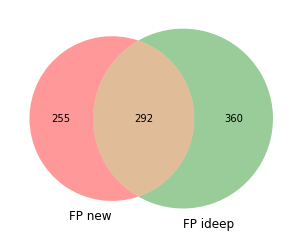

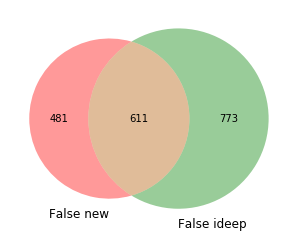

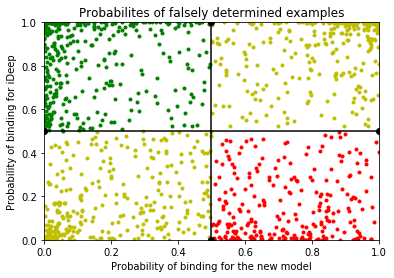

24_PARCLIP_QKI_hg19


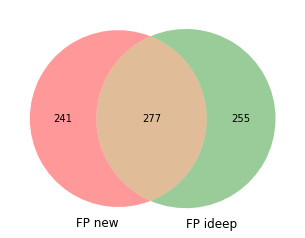

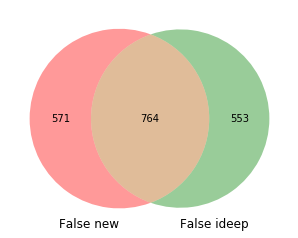

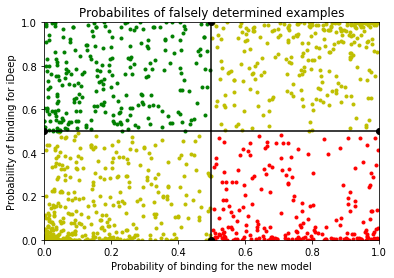

25_CLIPSEQ_SFRS1_hg19


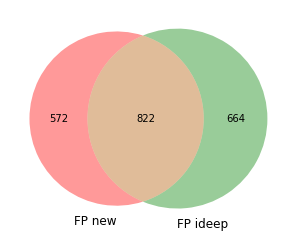

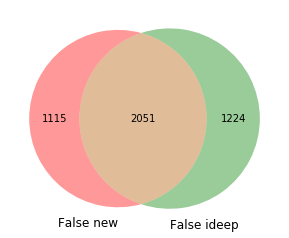

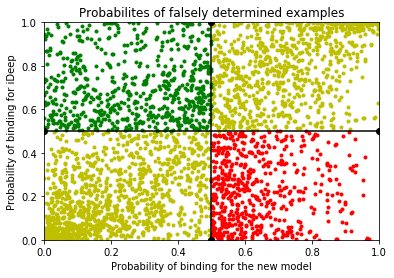

26_PARCLIP_TAF15_hg19


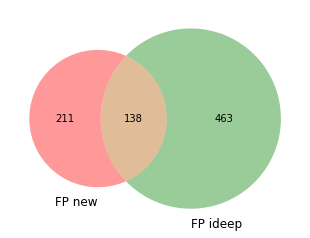

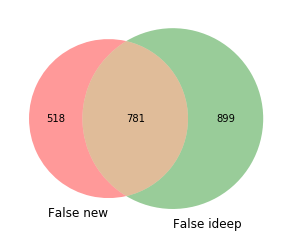

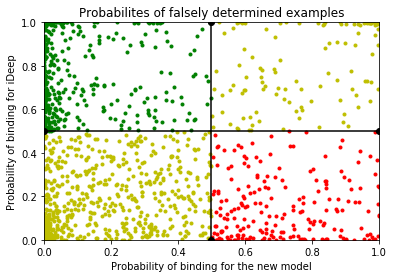

27_ICLIP_TDP43_hg19


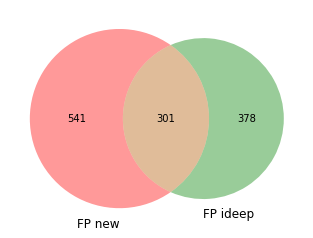

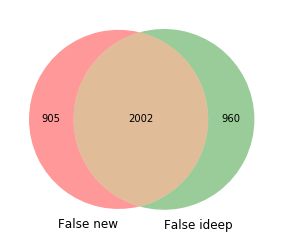

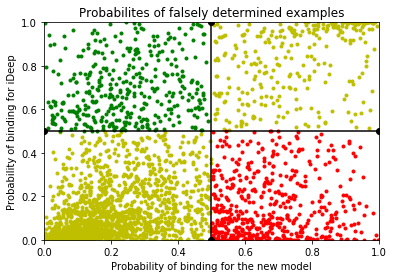

28_ICLIP_TIA1_hg19


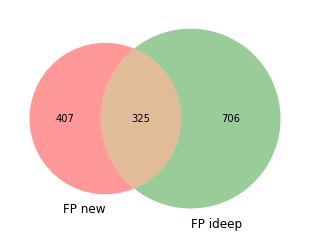

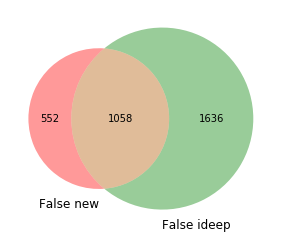

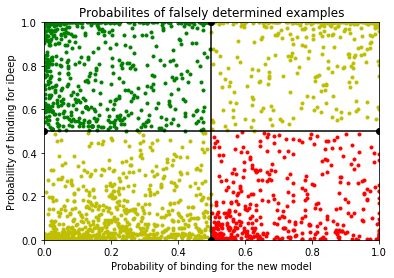

29_ICLIP_TIAL1_hg19


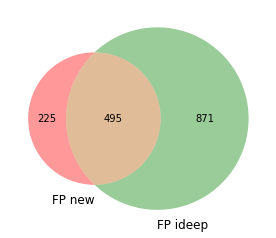

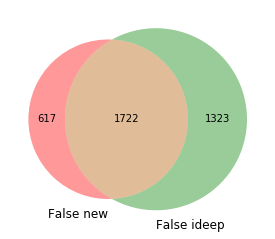

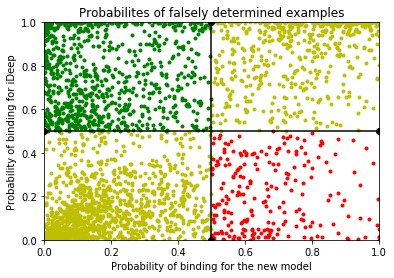

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


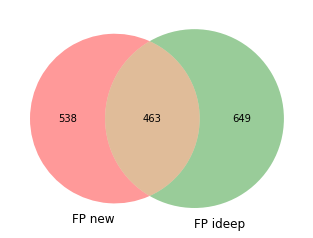

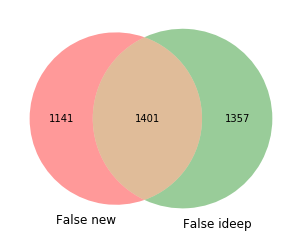

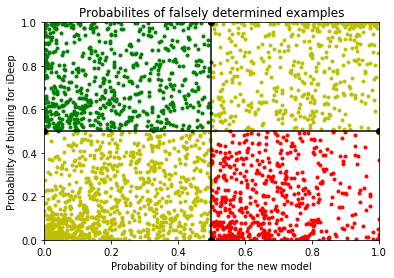

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


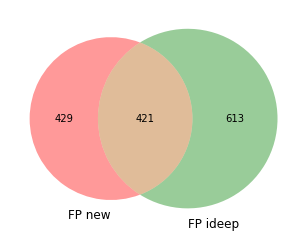

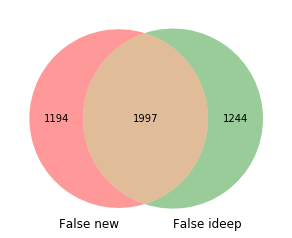

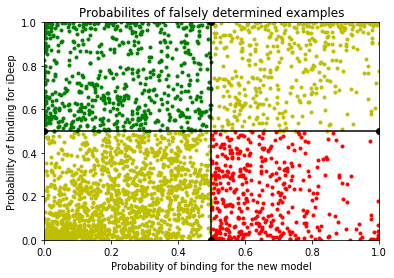

In [47]:
from matplotlib_venn import venn2

# find indices of different predictions.
def find_fp_index(true_label, predicted_label):
    fp_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 1 and true_label[i] == 0:
            fp_indices.append(i)
    return np.array(fp_indices)

def find_fn_index(true_label, predicted_label):
    fn_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 0 and true_label[i] == 1:
            fn_indices.append(i)
    return np.array(fn_indices)

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []
    complete_ideep = []
    binary_prediction = np.zeros(30000)
    binary_ideep = np.zeros(30000)
    
    
    print (protein)
    
    for training_set_number in range (3):

        # Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)          
            
            y_test = get_class(protein,"test",training_set_number)[:,1]
                        
            # Generated binary values are appended to a new array.
            complete_predictions.append(prediction[:,1])
            complete_y_test.append(y_test[:])
            
            predictions_ravel = np.ravel(complete_predictions)
            
            # Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            for i in range (len(predictions_ravel)):
                            if predictions_ravel[i] > 0.50:
                                binary_prediction[i] = 1
                            else:
                                binary_prediction[i] = 0
            
        with open ("ideep_results/predictions%s/%s" % (training_set_number, protein), "r") as ideep_file:
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
                        
            complete_ideep.append(ideep_prediction[:])
            
            ideep_ravel = np.ravel(complete_ideep)
            
            for i in range (len(ideep_ravel)):
                if ideep_ravel[i] > 0.50:
                    binary_ideep[i] = 1
                else:
                    binary_ideep[i] = 0
            
            
            
    
    binary_prediction = np.ravel(binary_prediction)
    complete_y_test = np.ravel(complete_y_test)
    binary_ideep = np.ravel(binary_ideep)
    #print (len(binary_ideep),len(binary_prediction))
    
    # Indices of false positives and false negatives from all of the datasets are stored as fp and fn.
    fp = find_fp_index(complete_y_test, binary_prediction)     
    fn = find_fn_index (complete_y_test, binary_prediction)

    #print (len(fp),len(fn))
    
    fp_ideep = find_fp_index(complete_y_test, binary_ideep)     
    fn_ideep = find_fn_index (complete_y_test, binary_ideep)
    #print (len(fp_ideep),len(fn_ideep))

    common_indices = np.intersect1d(fp, fp_ideep)
    #print (len(fp_ideep)-len(common_indices))
    venn2(subsets = ((len(fp)-len(common_indices)), (len(fp_ideep)-len(common_indices)), len(common_indices)), set_labels = ('FP new', 'FP ideep'))
    plt.show()

    #Merge both fb and fn for venn diagram of false predictions.
    false_new = np.append (fp,fn)
    false_ideep = np.append(fp_ideep,fn_ideep)
    common_false_indices = np.intersect1d(false_new, false_ideep)

    venn2(subsets = (len(false_new)-len(common_false_indices), len(false_ideep)-len(common_false_indices), len(common_false_indices)), set_labels = ('False new', 'False ideep'))
    plt.show()
    
    '''
    Graaphing values of falsely determined examples.
    '''
    # Get probability values of predictions which were false in both.
    new_common_f = []
    ideep_common_f = []
    for index in common_false_indices:

        new_common_f.append(predictions_ravel[index])
        ideep_common_f.append(ideep_ravel[index])

    #print (len(new_common_f),len(ideep_common_f))

    # Get probability values of predictions which were false positives in ideep
    new_correct_values = []
    fp_ideep_values = []
    for index in (np.setdiff1d(fp_ideep, fp)):

        new_correct_values.append(predictions_ravel[index])
        fp_ideep_values.append(ideep_ravel[index])

    #print (len(np.setdiff1d(fp_ideep, fp)))


    # Get probability values of predictions which were false positives in the new model
    ideep_correct_values = []
    fp_new_values = []
    for index in (np.setdiff1d(fp, fp_ideep)):

        fp_new_values.append(predictions_ravel[index])
        ideep_correct_values.append(ideep_ravel[index])

    #print (ideep_prediction_probabilities)
    #print (len(np.setdiff1d(fp, fp_ideep)))


    #print (prediction_probabilities)
    plt.title ('Probabilites of falsely determined examples')
    plt.xlabel('Probability of binding for the new model')
    plt.ylabel('Probability of binding for iDeep')
    plt.plot(new_common_f, ideep_common_f, 'y.')
    plt.plot(new_correct_values, fp_ideep_values, 'g.')
    plt.plot(fp_new_values, ideep_correct_values, 'r.')
    plt.plot([0.5,0.5],[0,1], 'ko-')
    plt.plot([0,1],[0.5,0.5], 'ko-')
    plt.axis([0, 1, 0, 1])
    plt.show()


In [ ]:
#30k datasets 

import numpy as np
from Bio import SeqIO
import gzip
import os
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt



np.random.seed(454)


def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
      
    r = 0    
      
    
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #sekvenca v številskem formatu


        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])


        X = np.zeros((1,len(num_seq),4))

        
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               

        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    

    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))

    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))


    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
            
        cobinding = np.zeros((30000,101,cobinding_data.shape[1]/101),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,cobinding_data.shape[1]/101),dtype=np.int)
   
    
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,region_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,region_data.shape[1]/101),dtype=np.int)
    

    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,fold_data.shape[1]/101),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,fold_data.shape[1]/101),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X




protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (3):
        
    score_list = []
    
    for protein in protein_list:

        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        print (X.shape)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(60,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(Dropout(0.2))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(60, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(60, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

        X_train = X
        y_train = y

        metrics = model.fit(X_train, y_train, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

        # Plot history for accuracy.
        plt.plot(metrics.history['acc'])
        plt.plot(metrics.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        # Plot loss function history.
        plt.plot(metrics.history['loss'])
        plt.plot(metrics.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        y_test = get_class(protein,"test",training_set_number)
        
        #Run predictions on test dataset.
        y_scores = model.predict(X_test)
        y_scores = y_scores [:,0:1]
        y_test = y_test [:,0:1]

        score = roc_auc_score(y_test, y_scores)

        fpr, tpr, thresholds = roc_curve(y_test, y_scores)

        #ROC plot
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label=protein.format(score))
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.savefig("graphs/ROC_%s" % protein)

        print (score)
        score_list.append(score)

    average_score = np.add(score_list, average_score)
    
average__score = np.true_divide(average_score, 3)    
print(average_score)


In [10]:
np.save(("predictions_%s/%s" % (training_set_number, protein)), y_scores)


In [2]:
from sklearn.metrics import confusion_matrix

y_test = get_class(protein,"test",training_set_number)
prediction = model.predict(X_test)
print (prediction.shape)

#Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
binary_prediction = np.argmax(prediction,axis=1)

#y_test = np.argmax(y_test, axis=1)
y_test = y_test[:,1]
        
print (y_test.shape, y_test)





confusion_matrix(y_test, binary_prediction)
# Outputs an array with [tn, fp], [fn, tp]


(10000, 2)
((10000,), array([0, 0, 0, ..., 0, 0, 0]))


array([[7473,  527],
       [ 397, 1603]])

In [3]:

# find indices of different predictions.
def find_fp_index(true_label, predicted_label):
    fp_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 1 and true_label[i] == 0:
            fp_indices.append(i)
    return np.array(fp_indices)

def find_fn_index(true_label, predicted_label):
    fn_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 0 and true_label[i] == 1:
            fn_indices.append(i)
    return np.array(fn_indices)

fp = find_fp_index(y_test, binary_prediction)     
fn = find_fn_index (y_test, binary_prediction)

print (len(fp),len(fn))
fp, fn

(527, 397)


(array([  25,   40,   55,   97,  118,  128,  186,  199,  209,  210,  230,
         231,  282,  304,  308,  330,  365,  420,  424,  430,  482,  488,
         505,  527,  561,  564,  572,  591,  594,  660,  686,  689,  704,
         746,  769,  779,  797,  812,  852,  856,  859,  878,  879,  900,
         902,  923,  958,  967,  974, 1025, 1028, 1041, 1044, 1059, 1060,
        1086, 1089, 1128, 1130, 1137, 1207, 1241, 1254, 1280, 1295, 1307,
        1351, 1370, 1375, 1415, 1432, 1445, 1482, 1510, 1547, 1551, 1612,
        1633, 1639, 1691, 1698, 1741, 1743, 1778, 1803, 1807, 1820, 1847,
        1875, 1892, 1895, 1928, 1940, 1958, 2004, 2032, 2041, 2044, 2107,
        2113, 2151, 2178, 2188, 2190, 2227, 2241, 2253, 2266, 2270, 2292,
        2299, 2304, 2305, 2333, 2355, 2360, 2362, 2381, 2384, 2385, 2388,
        2394, 2434, 2488, 2489, 2490, 2499, 2514, 2537, 2547, 2555, 2572,
        2583, 2602, 2611, 2617, 2619, 2629, 2660, 2665, 2692, 2732, 2765,
        2767, 2783, 2784, 2811, 2837, 

In [86]:
for index in fp:
    print (prediction[index])
    


[0.3821738 0.6408111]
[0.11258239 0.9533933 ]
[0.34007505 0.6316186 ]
[0.21317105 0.8885302 ]
[0.26928735 0.86166185]
[0.15942413 0.9375825 ]
[0.4692543  0.48520353]
[0.28580794 0.82740676]
[0.1784311 0.8907503]
[0.17890815 0.92861897]
[0.05933282 0.9958068 ]
[0.3073064  0.68957275]
[0.41076282 0.53641206]
[0.39242718 0.53970325]
[0.4194894  0.54216456]
[0.35306594 0.62638295]
[0.36874062 0.5751473 ]
[0.39731416 0.59360355]
[0.4634797  0.52298594]
[0.49558812 0.54732543]
[0.07953493 0.97792417]
[0.40357003 0.6638054 ]
[0.4697857  0.54083335]
[0.23442678 0.8799226 ]
[0.20465371 0.9312678 ]
[0.06271648 0.9932943 ]
[0.36777773 0.51794976]
[0.44091806 0.49625164]
[0.40215275 0.55063075]
[0.22368833 0.8199254 ]
[0.17961045 0.8142589 ]
[0.17790896 0.8963169 ]
[0.18096623 0.90756387]
[0.4745553 0.5769825]
[0.16036835 0.9688464 ]
[0.20031062 0.8408094 ]
[0.4063825 0.5376874]
[0.24572468 0.8100298 ]
[0.3883263  0.58483666]
[0.19233745 0.90785545]
[0.3812554 0.5662781]
[0.3399707  0.61967313]
[0

array([0, 0, 0, ..., 0, 0, 0])

(1583, 1544)
1403


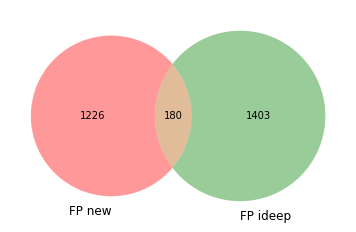

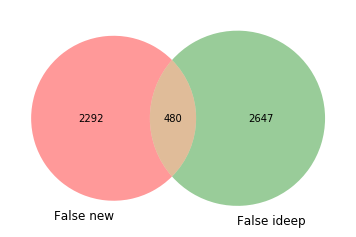

In [13]:
ideep_prediction = np.loadtxt("1_PARCLIP_AGO1234_hg19_ideep", delimiter="\n", unpack=False)
ideep_prediction = np.array(ideep_prediction)

for i in range (len(ideep_prediction)):
    if ideep_prediction[i] > 0.50:
        ideep_prediction[i] = 1
    else:
        ideep_prediction[i] = 0


        
#confusion_matrix(y_test, ideep_prediction)


fp_ideep = find_fp_index(y_test, ideep_prediction)     
fn_ideep = find_fn_index (y_test, ideep_prediction)

print (len(fp_ideep),len(fn_ideep))
common_indices = np.intersect1d(fp, fp_ideep)
print (len(fp_ideep)-len(common_indices))

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
 
venn2(subsets = ((len(fp)-len(common_indices)), (len(fp_ideep)-len(common_indices)), len(common_indices)), set_labels = ('FP new', 'FP ideep'))
plt.show()

#Merge both fb and fn for venn diagram of false predictions.
false_new = np.append (fp,fn)
false_ideep = np.append(fp_ideep,fn_ideep)
common_false_indices = np.intersect1d(false_new, false_ideep)

venn2(subsets = (len(false_new)-len(common_false_indices), len(false_ideep)-len(common_false_indices), len(common_false_indices)), set_labels = ('False new', 'False ideep'))
plt.show()

284
197
243


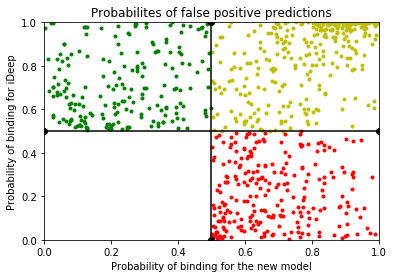

In [6]:
prediction_probabilities = []
ideep_prediction_probabilities = []
ideep_prediction_values = np.loadtxt("1_PARCLIP_AGO1234_hg19_ideep", delimiter="\n", unpack=False)

# Get probability values of predictions which were false positives in both
for index in common_indices:
    
    prediction_probabilities.append(prediction[index, 1])
    ideep_prediction_probabilities.append(ideep_prediction_values[index])
    

print(len(common_indices)) 

# Get probability values of predictions which were false positives in ideep
new_correct_values = []
fp_ideep_values = []
for index in (np.setdiff1d(fp_ideep, fp)):
    
    new_correct_values.append(prediction[index, 1])
    fp_ideep_values.append(ideep_prediction_values[index])
    
print (len(np.setdiff1d(fp_ideep, fp)))


# Get probability values of predictions which were false positives in the new model
ideep_correct_values = []
fp_new_values = []
for index in (np.setdiff1d(fp, fp_ideep)):
    
    fp_new_values.append(prediction[index, 1])
    ideep_correct_values.append(ideep_prediction_values[index])
    
#print (ideep_prediction_probabilities)
print (len(np.setdiff1d(fp, fp_ideep)))
    
    
#print (prediction_probabilities)
plt.title ('Probabilites of false positive predictions')
plt.xlabel('Probability of binding for the new model')
plt.ylabel('Probability of binding for iDeep')
plt.plot(prediction_probabilities, ideep_prediction_probabilities, 'y.')
plt.plot(new_correct_values, fp_ideep_values, 'g.')
plt.plot(fp_new_values, ideep_correct_values, 'r.')
#plt.plot (prediction,ideep_prediction_values, 'r.')
plt.plot([0.5,0.5],[0,1], 'ko-')
plt.plot([0,1],[0.5,0.5], 'ko-')
plt.axis([0, 1, 0, 1])
plt.show()



In [7]:

for entry in fp_new_values:
    if entry < 0.50:
        print (entry)#(prediction[fp[fp_new_values.index(entry)]])
        

(557, 557)


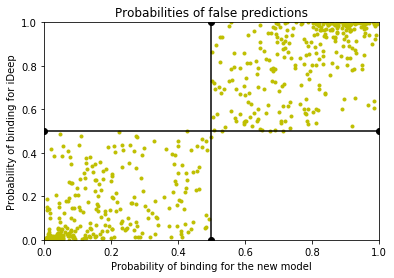

In [8]:
new_common_f = []
ideep_common_f = []
for index in common_false_indices:
        
    new_common_f.append(prediction[index, 1])
    ideep_common_f.append(ideep_prediction_values[index])

print (len(new_common_f),len(ideep_common_f))


plt.title ('Probabilities of false predictions')
plt.xlabel('Probability of binding for the new model')
plt.ylabel('Probability of binding for iDeep')
plt.plot(new_common_f, ideep_common_f, 'y.')
#plt.plot(new_correct_values, fp_ideep_values, 'g.')
#plt.plot(fp_new_values, ideep_correct_values, 'r.')
plt.plot([0.5,0.5],[0,1], 'ko-')
plt.plot([0,1],[0.5,0.5], 'ko-')
plt.axis([0, 1, 0, 1])
plt.show()
     

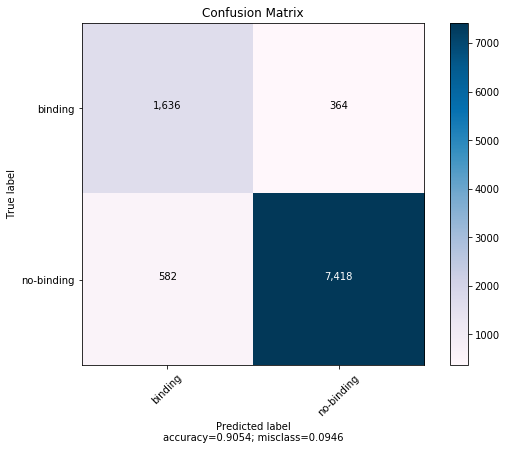

In [10]:

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow((cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm           = np.flip(np.array([[7418,  582],
                                               [ 364, 1636]])), 
                      normalize    = False,
                      target_names = ['binding', 'no-binding'],
                      title        = "Confusion Matrix",
                      cmap = 'PuBu')

In [89]:
positive_samples = []
data_sources, X_test = load_data_sources("1_PARCLIP_AGO1234_hg19","test",0,*experiment_set)
y_test = get_class("1_PARCLIP_AGO1234_hg19","test",0)
y_test = y_test = y_test [:,1]

for i in range (len(y_test)):
    if y_test[i] == 1:
        positive_samples.append(X_test[i])

len (positive_samples)
        

2000

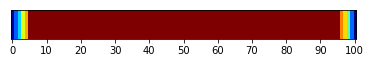

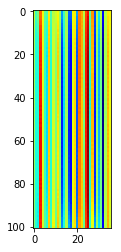

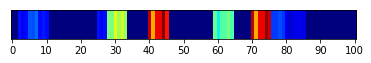

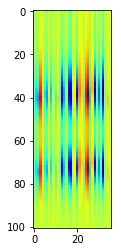

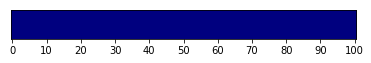

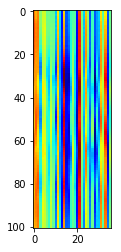

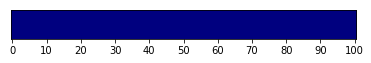

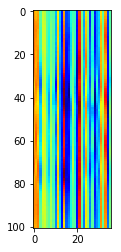

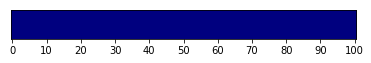

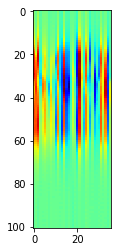

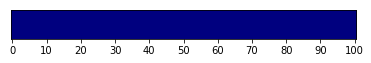

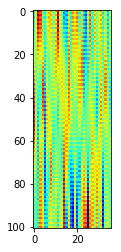

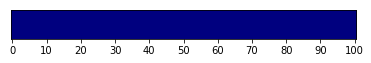

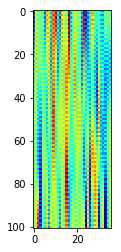

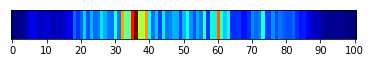

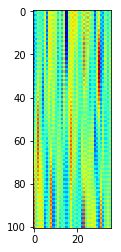

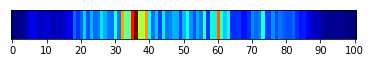

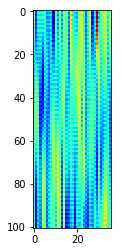

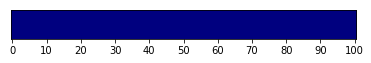

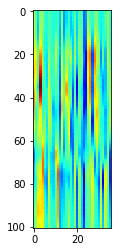

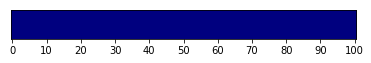

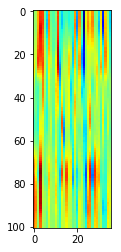

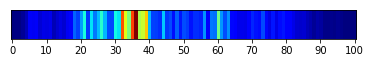

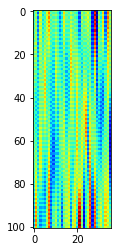

In [9]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations


layer_index = 0


for layer in model.layers:
    print (layer)
    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)
    
    saliency_plot = plt.figure()
    bar = saliency_plot.add_axes([0, 0.5, 0.8, 0.1],xticks=np.arange(0,101,10), yticks=[])
    bar.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
    plt.show()
    
    activation = visualize_activation(model, layer_index, filter_indices = [1])

    plt.imshow(activation, cmap = 'jet')
    plt.show()
    layer_index += 1


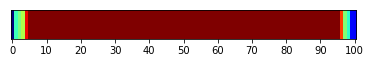

[[ 99 155  76 ... 134 166 130]
 [100 155  76 ... 133 167 130]
 [ 99 156  75 ... 134 167 130]
 ...
 [107 147  79 ... 123 173 119]
 [108 147  79 ... 122 173 118]
 [107 146  79 ... 122 172 118]]


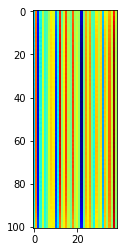

KeyboardInterrupt: 

In [46]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations


layer_index = 0


for layer in model.layers:
    print (layer)
    
    #Swap softmax with linear
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)
    
    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)
    
    saliency_plot = plt.figure()
    bar = saliency_plot.add_axes([0, 0.5, 0.8, 0.1],xticks=np.arange(0,101,10), yticks=[])
    bar.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
    plt.show()
    
    activation = visualize_activation(model, layer_index, filter_indices = [1])
    print (activation)
    plt.imshow(activation, cmap = 'jet')
    plt.show()
    layer_index += 1


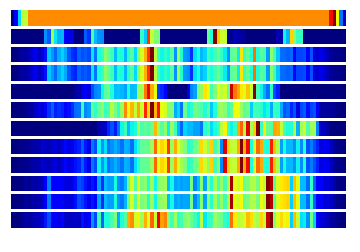

In [141]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations


layer_index = 0
y_test = get_class("1_PARCLIP_AGO1234_hg19","test",0)
protein_grads = np.zeros((12,101))

for layer in model.layers:
    print (layer)
    
    #Swap softmax with linear
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)
    
    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=np.array(positive_samples))
    
    protein_grads[layer_index,:] = grads
   
    plt.figure(1)
    plt.subplot(12,1,layer_index+1, xticks = np.arange(0,101,10), yticks = [])    
    plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
   
    
    #activation = visualize_activation(model, layer_index, filter_indices = [1])
    #plt.imshow(activation, cmap = 'jet')
    #plt.show()
    layer_index += 1
    
plt.figure(1)
#plt.axes([0, 0.5, 0.8, 0.1],xticks=np.arange(0,101,10), yticks=[])
plt.show()

In [ ]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations



layer_index = 0
data_sources, X_test = load_data_sources("1_PARCLIP_AGO1234_hg19","test",0,*experiment_set)
protein_grads = np.zeros((12,101))

for layer in model.layers:
    print (layer)
    
    #Swap softmax with linear
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)
    
    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)
    
    protein_grads[layer_index,:] = grads
   
    plt.figure(1)
    plt.subplot(12,1,layer_index+1, xticks = np.arange(0,101,10), yticks = [])    
    plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
   
    layer_index += 1
    
plt.figure(1)
plt.show()

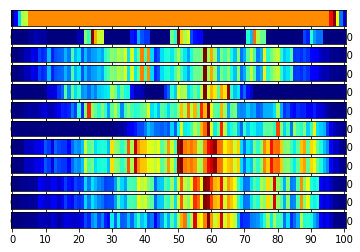

In [144]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations


layer_index = 0
data_sources, X_test = load_data_sources("1_PARCLIP_AGO1234_hg19","test",0,*experiment_set)
protein_grads = np.zeros((12,101))

for layer in model.layers:
    print (layer)
    
    #Swap softmax with linear
    model.layers[layer_index].activation = activations.linear
    model = utils.apply_modifications(model)
    
    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)
    
    protein_grads[layer_index,:] = grads
   
    plt.figure(1)
    plt.subplot(12,1,layer_index+1, xticks = np.arange(0,101,10), yticks = [])    
    plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
   
    layer_index += 1
    
plt.figure(1)
plt.show()

1_PARCLIP_AGO1234_hg19


/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


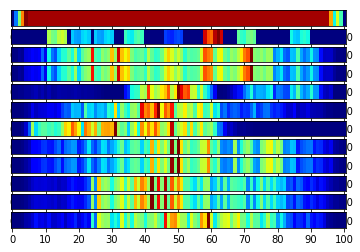

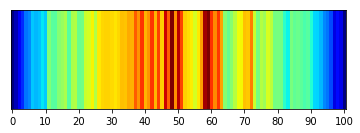

2_PARCLIP_AGO2MNASE_hg19


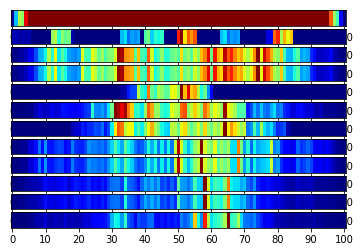

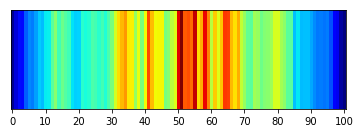

3_HITSCLIP_Ago2_binding_clusters


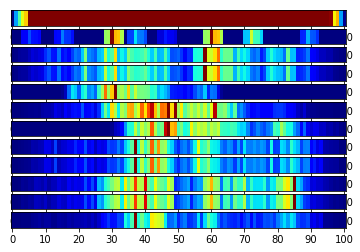

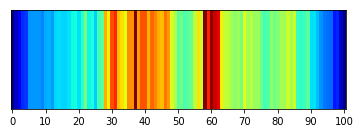

4_HITSCLIP_Ago2_binding_clusters_2


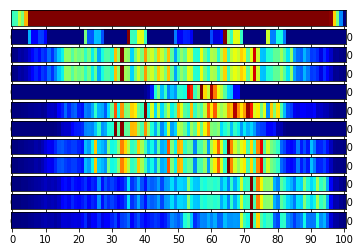

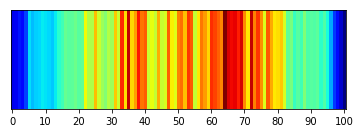

5_CLIPSEQ_AGO2_hg19


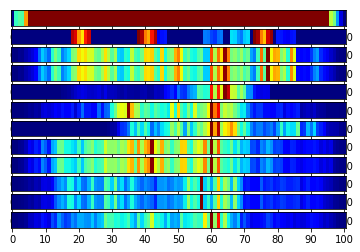

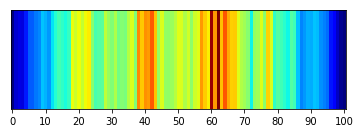

6_CLIP-seq-eIF4AIII_1


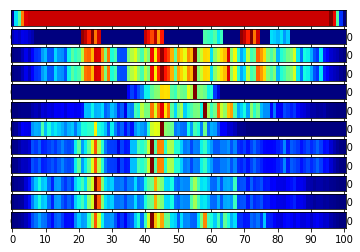

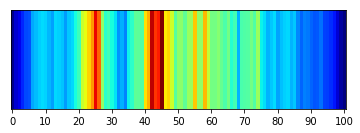

7_CLIP-seq-eIF4AIII_2


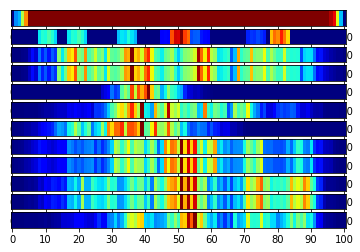

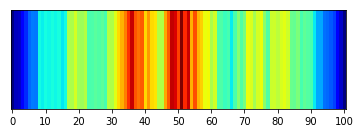

8_PARCLIP_ELAVL1_hg19


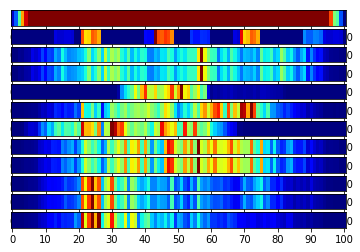

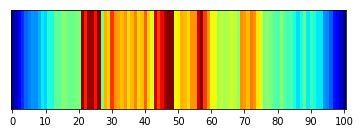

9_PARCLIP_ELAVL1MNASE_hg19


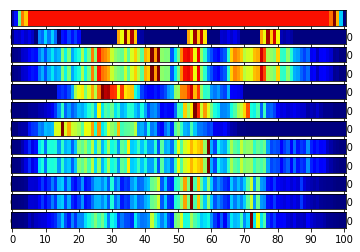

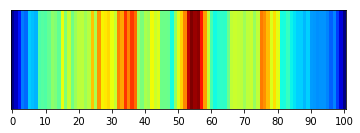

10_PARCLIP_ELAVL1A_hg19


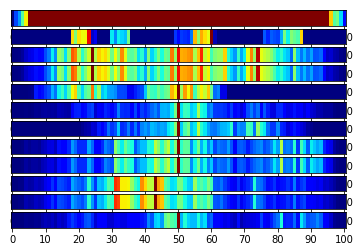

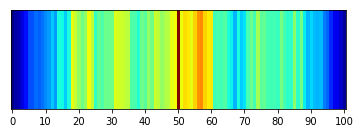

10_PARCLIP_ELAVL1A_hg19


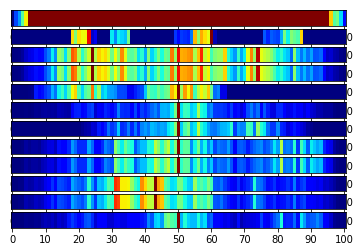

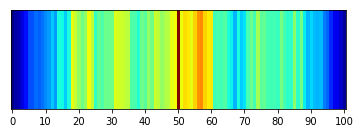

12_PARCLIP_EWSR1_hg19


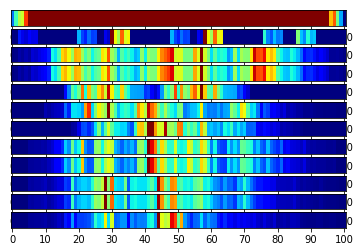

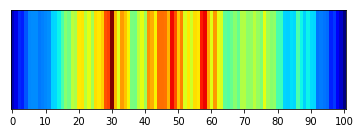

13_PARCLIP_FUS_hg19


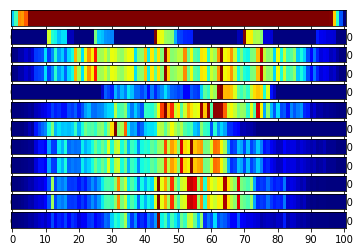

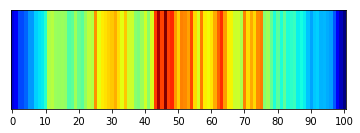

14_PARCLIP_FUS_mut_hg19


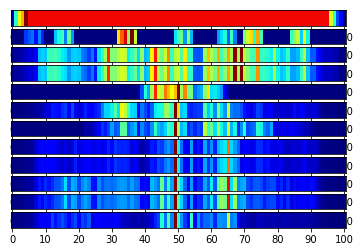

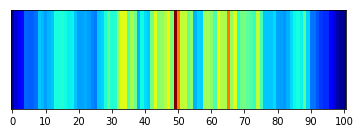

15_PARCLIP_IGF2BP123_hg19


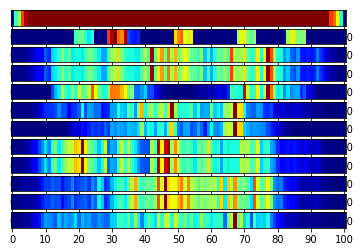

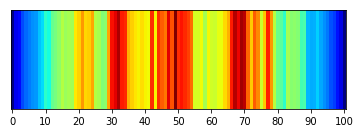

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


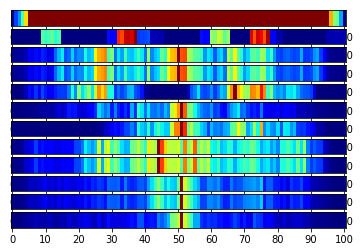

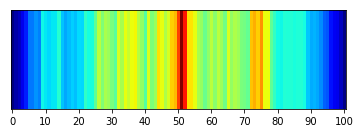

17_ICLIP_HNRNPC_hg19


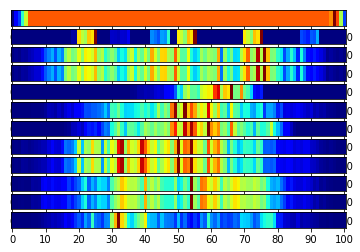

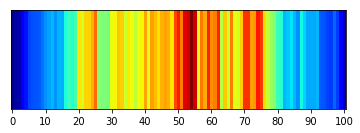

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


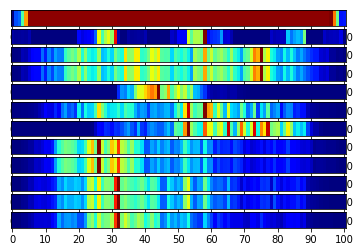

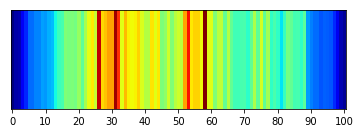

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


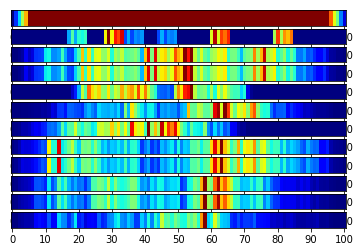

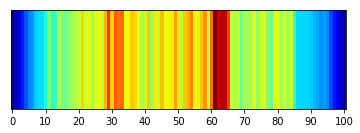

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


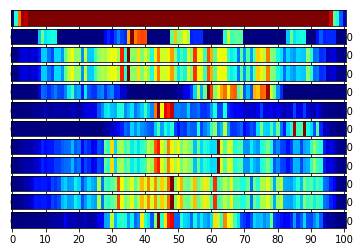

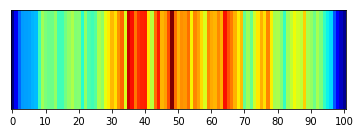

21_PARCLIP_MOV10_Sievers_hg19


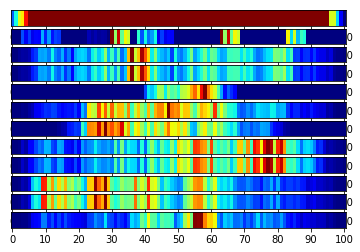

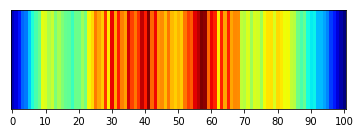

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


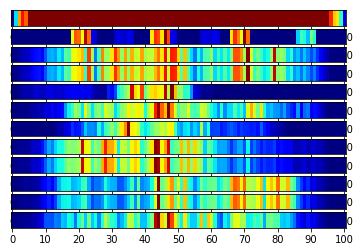

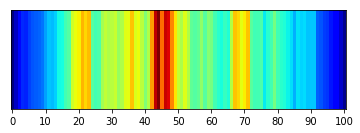

23_PARCLIP_PUM2_hg19


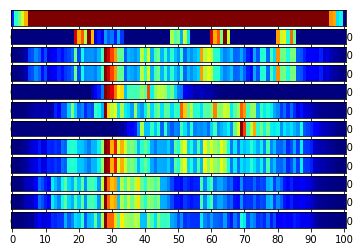

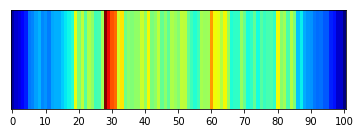

24_PARCLIP_QKI_hg19


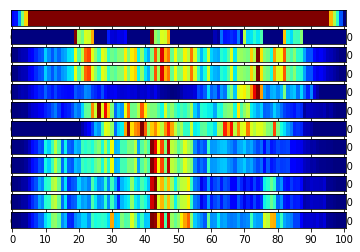

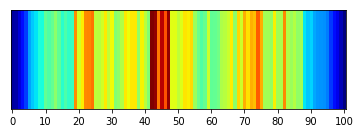

25_CLIPSEQ_SFRS1_hg19


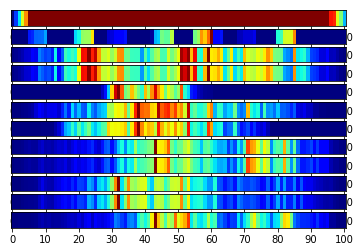

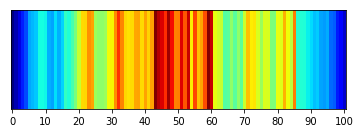

26_PARCLIP_TAF15_hg19


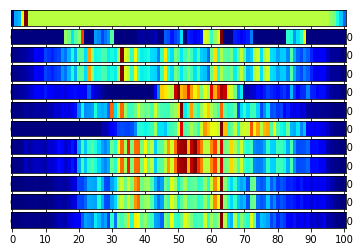

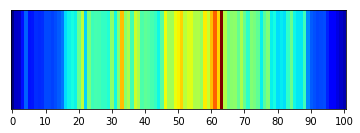

27_ICLIP_TDP43_hg19


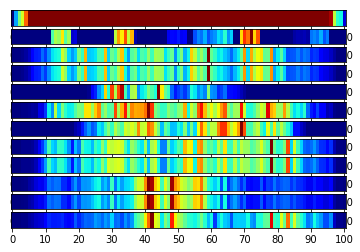

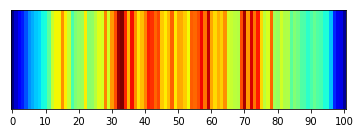

28_ICLIP_TIA1_hg19


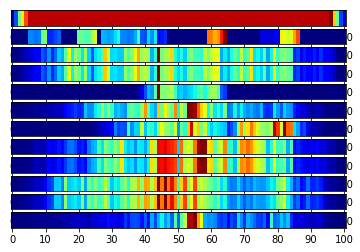

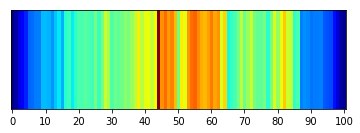

29_ICLIP_TIAL1_hg19


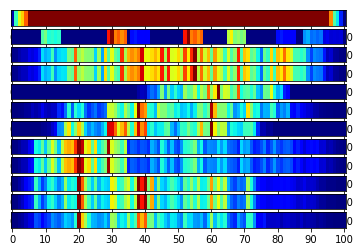

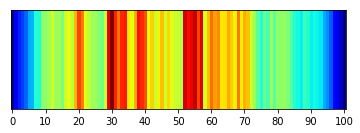

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


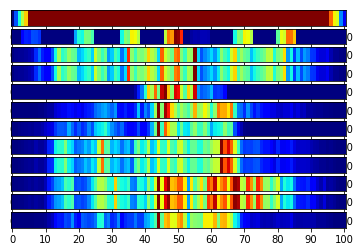

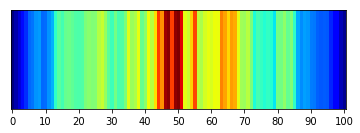

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


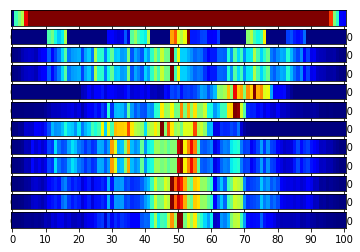

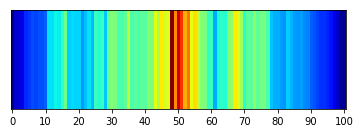

In [2]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

# Sum of gradients across all layers saved under protein name.
gradients_dict = {}

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))


        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        

        layer_index = 0
        protein_grads = np.zeros((12,101))

        for layer in model.layers:
            print (layer)

            #Swap softmax with linear
            model.layers[layer_index].activation = activations.linear
            model = utils.apply_modifications(model)

            grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=X_test)

            protein_grads[layer_index,:] = grads

            plt.figure(1)
            plt.subplot(12,1,layer_index+1, xticks = np.arange(0,101,10), yticks = [])    
            plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')

            layer_index += 1

        plt.figure(1)
        plt.show()
        plt.close()
        
        grads_total = np.sum(protein_grads, axis = 0)
        gradients_dict[protein] = grads_total
        
        plt.figure(2)
        plt.subplot(211, xticks=np.arange(0,101,10), yticks=[])
        plt.imshow(grads_total.reshape((1,-1)), aspect='auto', cmap='jet', interpolation='nearest')
        plt.show()
        plt.close()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 96, 60)            13020     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 77, 60)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 74, 60)            14460     
_________________________________________________________________
dropout_5 (Dropout)          (None, 74, 60)            0         
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 35, 60)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 32, 60)            14460     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 3, 60)             0         
__________

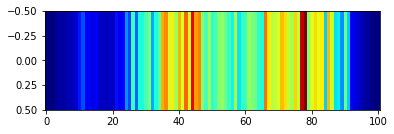

In [98]:
model.summary()
model.layers[0]
print (protein_grads)

grads_total = np.sum(protein_grads, axis = 0)

plt.figure(2)
plt.imshow(grads_total.reshape((1,-1)), aspect='auto', cmap='jet', interpolation='nearest')
plt.axes([0, 0.5, 0.8, 0.1],xticks=np.arange(0,101,10), yticks=[])

total_saliency = plt.figure(2)
fig = plt.subplot(211)
#    = saliency_plot.add_axes([0, 0.5, 0.8, 0.1],xticks=np.arange(0,101,10), yticks=[])
fig.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
plt.show()

In [ ]:
#gruce proteinov na podlogi vektorjev saliency mapa dodaj vektorje vseh nivojev v en skupni vektro in prikazi clustering

#katera jedra se aktivirajo za določene motive, ugotovi kateri motivi so odgovorni za aktivacijo jedra in to prikazi. Ugotovi motive!

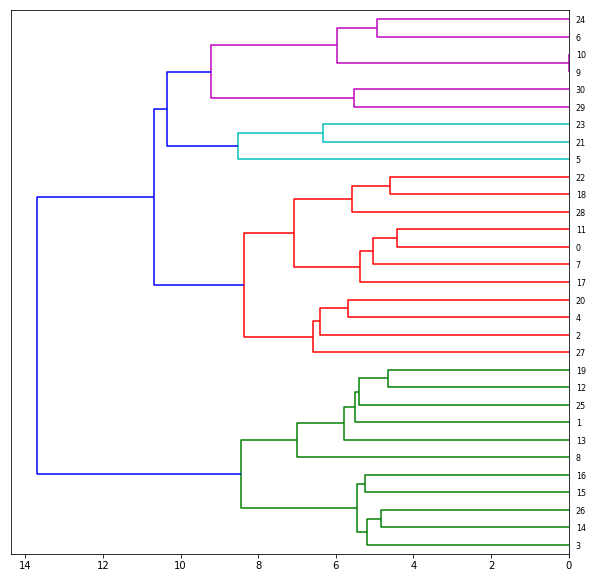

In [13]:

from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

gradient_array = []
for protein in protein_list:
    gradient_array.append(gradients_dict.get(protein))

Z = linkage(gradient_array, 'ward')
fig = plt.figure(figsize=(10, 10))
dn = dendrogram(Z, orientation = 'left')
plt.show()




In [ ]:
from Bio.motifs import _pwm

training_data = load_data("datasets/clip/1_PARCLIP_AGO1234_hg19/30000/test_sample_0")


for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        print ("".join(sequence))

#X = get_seq("1_PARCLIP_AGO1234_hg19",'test',0)
#_pwm.calculate(X)

In [5]:
def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def positive_examples_sequences(protein, t_data, training_set_number): 
    if t_data == "train":
                
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":    
                
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = []            
    
    for record in SeqIO.parse(training_data,"fasta"):
        v = int((record.description).split(":")[1])
        if v == 1:
            sequence = list(record.seq)     
            x_train.append("".join(sequence))

    return x_train




positive_sequences = positive_examples_sequences('1_PARCLIP_AGO1234_hg19', 'test',0)
positive_sequences

['CTGAAATATCAGGTTCTAGAAGAAACTGGCGCTTAAACCAAATCGCATGGATTTCTTTTTCAGTGACGTTCAAGTGTTTCTCACGGATGGAATTCTAGTCA',
 'ACTTCTCTGTGGAAAGGGAGTTGGTTGGGGGGTTGAGATGGCCCGTGTTCATAACTCAGTTTCCTGTTTTGCACGATGTAAAAACCCTGTCTTTTTGCACG',
 'TGTTTTGGTCATTGCATTTGCACTTTCATGGACAACTTTTAATTTGATCAGCAAGACATCTTGGAACTCAATCTTCTGTTGGATCACGGGAAATCAAGACA',
 'CCACCCATCTCCCTGGCCTCCGGTCCCAACTTCGCTTCTCTGCTGACCCTCTCTCGTCGCCGCTGCCGCCGCCGCAGCTGCCAAAATGTGAGTGACGCTAC',
 'TTCCCCTGCGCCCCGCGCCCAGGCCGGGCCGAGCCGAGCCGAGCCGGGTCGGGCCCGGGCCATGCTGCTCACCGTGTACTGTGTGCGGAGGGACCTCTCCG',
 'CTGCAGCTGCTGGAAGGCGTGGACCATCTGGTTCAACAGGGCATCGCGCACAGAGACCTGAAATCCGACAACATCCTTGTGGAGCTGGACCCAGGTAGGAA',
 'GATTTAAACTTGAGGGTTTCCCTCCTGACTAGCCTCTCTTACAGGAATTGTGAAATATTAAATGCAAATTTACAACTGCAGATGACGTATGTGCCTTGAAC',
 'CCCTAGAGCAGCCAGGTGAGGCTCTCTAGTTTAATAAAAATCATGGAAAGACTCTTAATGCAGACTCTTCTTAAGTGTTAATAGGGATTTTTTCAGCTTAT',
 'ATCTCTTCTCTTTCAGTATGATGGGATCATCCTTCCTGGCAAATAAATTCCCGTTTCTATCCAAAAGAGCAATAAAAAGTTTTCAGTGAAATGTGCAATTC',
 'AAGGTCAATTATACTTTTGTTGTTCATTAGCATCTTTGTAAACT

1_PARCLIP_AGO1234_hg19


/local/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide


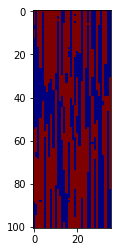

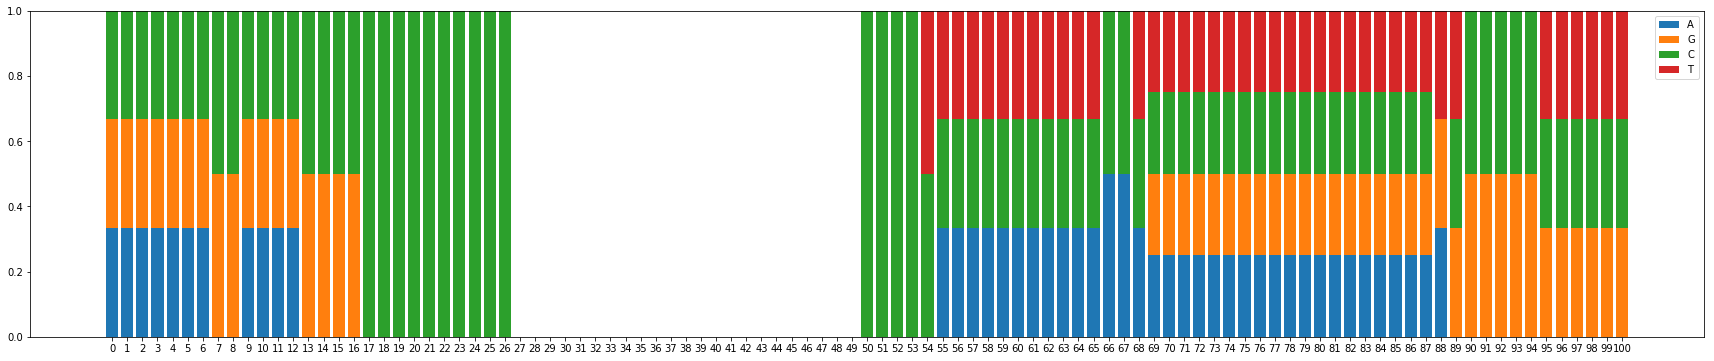

In [3]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
                
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
    

        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)

        #We are interested in the last dense layer of network, 
        layer_index = -1
        model.layers[layer_index].activation = activations.linear
        model = utils.apply_modifications(model)
        
        #We generate the input that maximizes the filter output activation. 
        activation = visualize_activation(model, layer_index, filter_indices = 1 ,input_range = (0,2))
                                                               
        with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "w") as activation_maximization_f:
            np.save(activation_maximization_f, activation)
        
        plt.figure(3)
        plt.imshow(activation, cmap = 'jet')
        
        nucleotides = {'A' : activation[:,0], 'T' : activation[:,1], 'G' : activation[:,2], 'C' : activation[:,3]} 
        position_count = np.sum(activation[:,0:4],1)

        for entry in nucleotides:
            nucleotides[entry] = (np.true_divide(nucleotides[entry],position_count)) #, where=position_count!=0)

        #print (nucleotides)    
        width = 0.35  
    
        pos = np.arange(101) 

        plt.figure(4, figsize=(30,6))
        p1 = plt.bar(pos, nucleotides['A'])
        p2 = plt.bar(pos, nucleotides['G'],bottom = nucleotides['A'])
        p3 = plt.bar(pos, nucleotides['C'],bottom = (nucleotides['A'] + nucleotides['G']))
        p4 = plt.bar(pos, nucleotides['T'],bottom = (nucleotides['A'] + nucleotides['G']+nucleotides['C']))
        plt.xticks(pos, pos)
        plt.legend((p1[0],p2[0],p3[0],p4[0]), ('A', 'G', 'C','T'))
        
        plt.show()


In [6]:
import numpy as np

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)

        with open ("results/set_%s/%s/activation_maximization" % (training_set_number, protein), "r") as activation_maximization_f:
            activation = np.load(activation_maximization_f)
            
            nucleotides = {'A' : activation[:,0], 'T' : activation[:,1], 'G' : activation[:,2], 'C' : activation[:,3]} 
            position_count = np.sum(activation[:,0:4],1)

            for entry in nucleotides:
                nucleotides[entry] = np.nan_to_num(np.true_divide(nucleotides[entry],position_count))
                
            with open ("results/set_%s/%s/max_activation_sequences.txt" % (training_set_number, protein), "w") as sequences_f:
                 sequences_f.write('P0 A U G C\n')
                    
            for i in range (len(nucleotides['A'])):
                 with open ("results/set_%s/%s/max_activation_sequences.txt" % (training_set_number, protein), "a") as sequences_f:
                    sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))
 
                

1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19


/local/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19
26_PARCLIP_TAF15_hg19
27_ICLIP_TDP43_hg19
28_IC

In [60]:
import os
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        cmd = ("weblogo -f results/set_%s/%s/max_activation_sequences.txt -D transfac -F png -o results/set_%s/%s/max_activation.png --errorbars NO --show-xaxis YES --show-yaxis YES --first-index '-50' -A rna --composition none -n 101 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, training_set_number, protein)) 
        os.system(cmd)

1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19

1_PARCLIP_AGO1234_hg19


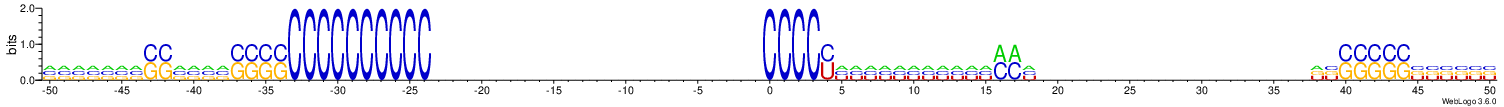

2_PARCLIP_AGO2MNASE_hg19


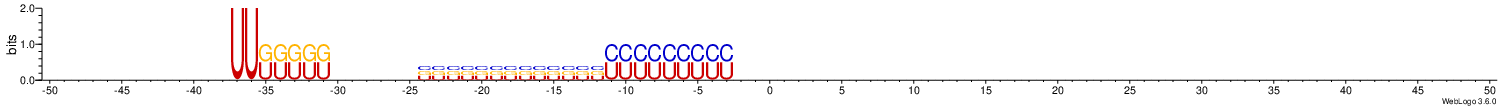

3_HITSCLIP_Ago2_binding_clusters


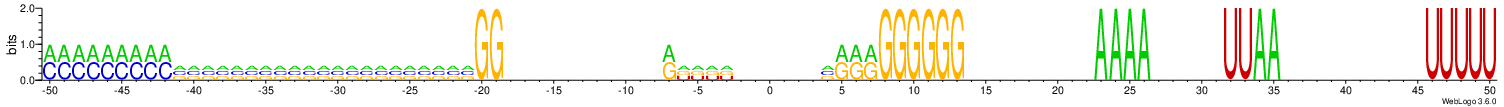

4_HITSCLIP_Ago2_binding_clusters_2


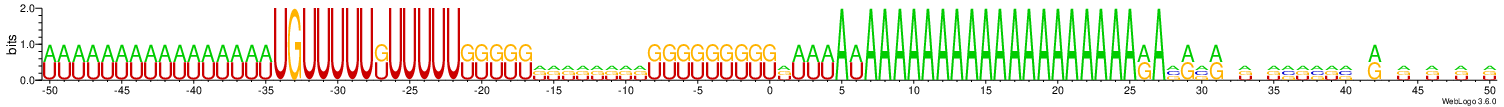

5_CLIPSEQ_AGO2_hg19


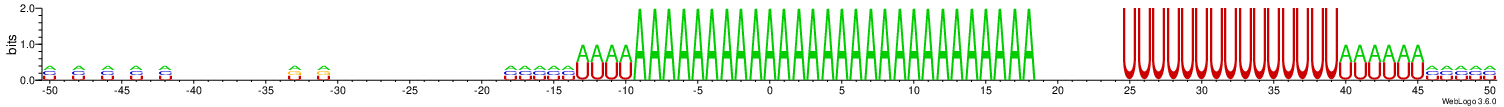

6_CLIP-seq-eIF4AIII_1


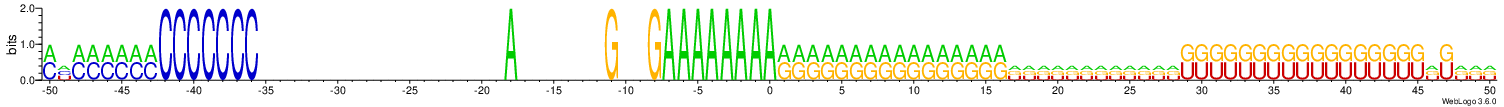

7_CLIP-seq-eIF4AIII_2


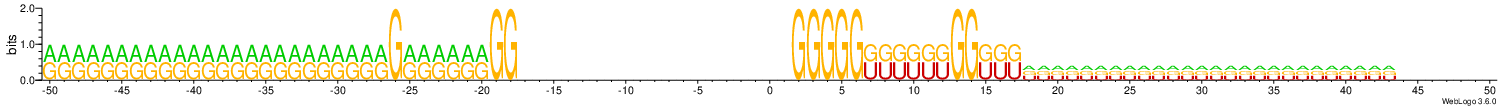

8_PARCLIP_ELAVL1_hg19


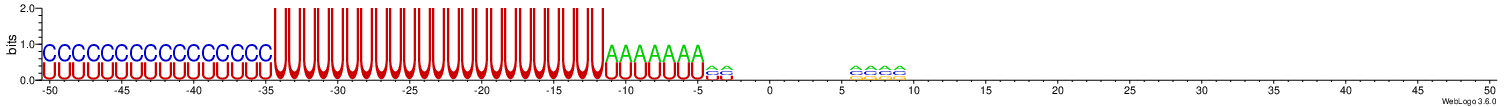

9_PARCLIP_ELAVL1MNASE_hg19


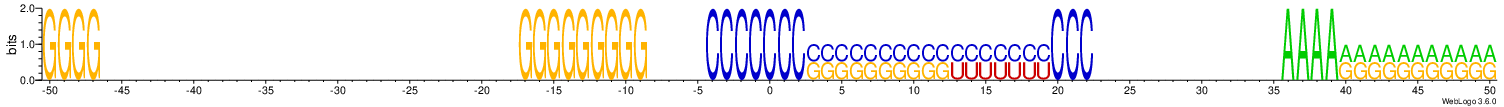

10_PARCLIP_ELAVL1A_hg19


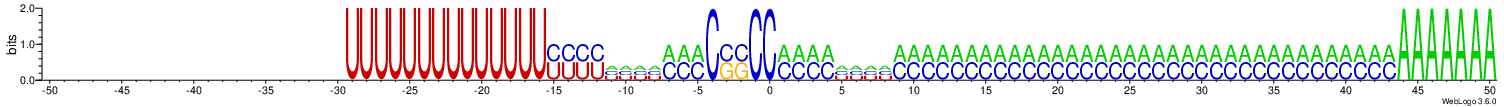

10_PARCLIP_ELAVL1A_hg19


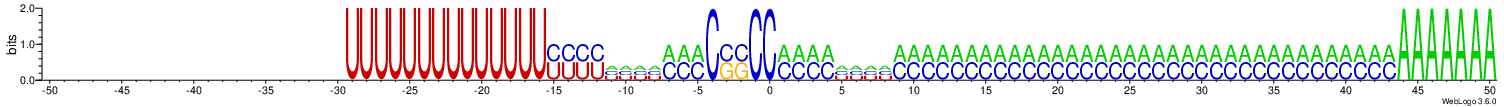

12_PARCLIP_EWSR1_hg19


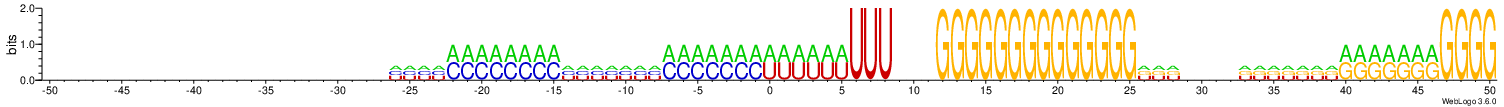

13_PARCLIP_FUS_hg19


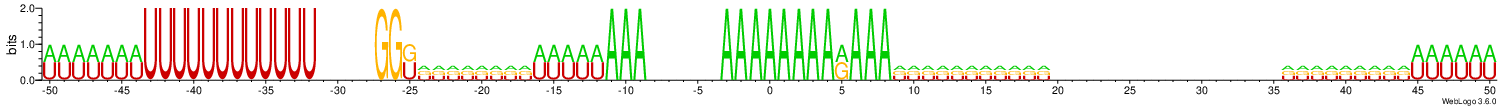

14_PARCLIP_FUS_mut_hg19


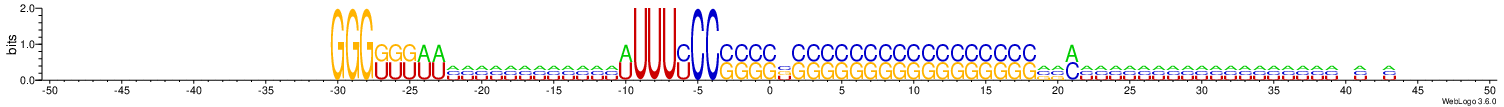

15_PARCLIP_IGF2BP123_hg19


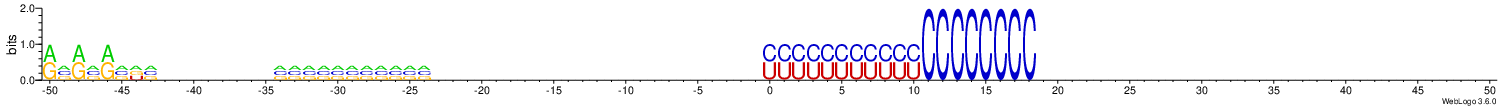

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


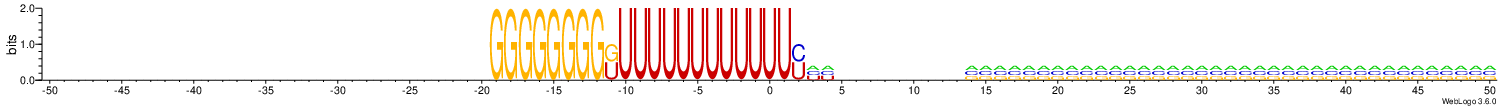

17_ICLIP_HNRNPC_hg19


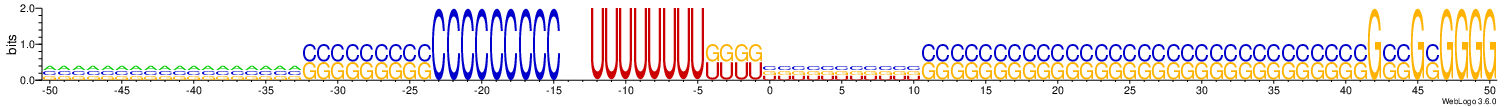

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


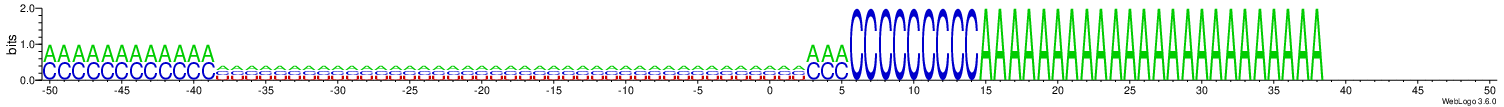

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


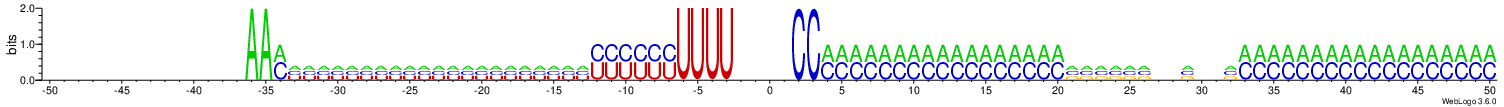

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


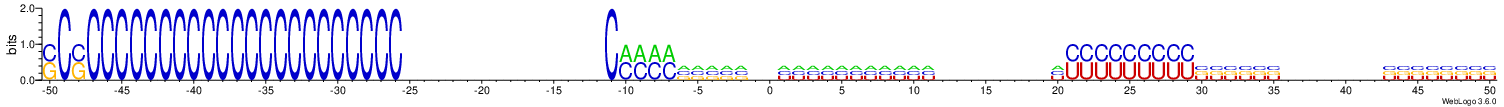

21_PARCLIP_MOV10_Sievers_hg19


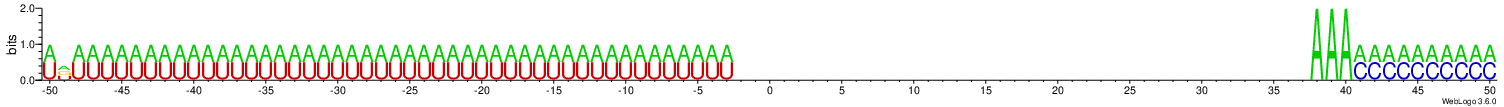

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


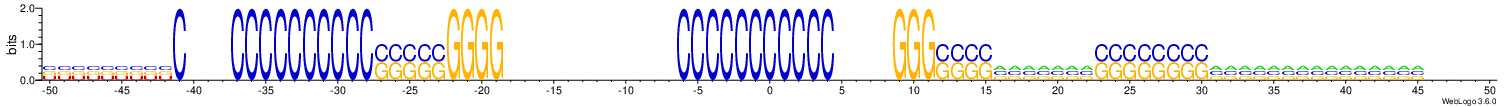

23_PARCLIP_PUM2_hg19


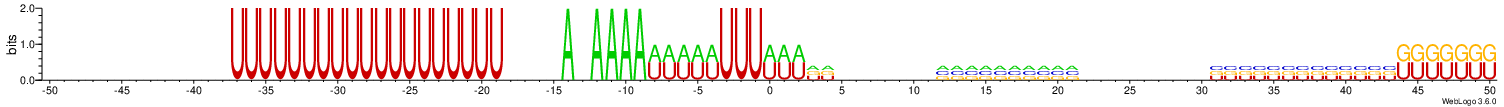

24_PARCLIP_QKI_hg19


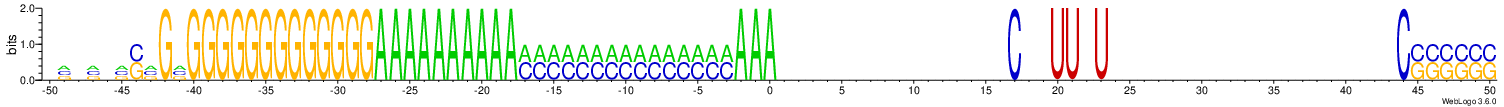

25_CLIPSEQ_SFRS1_hg19


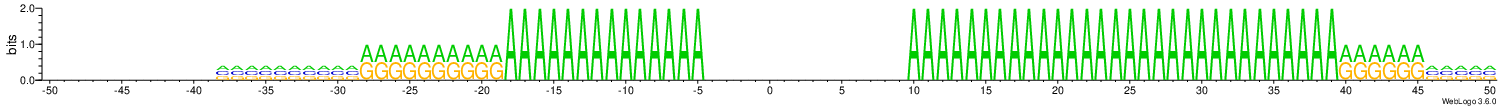

26_PARCLIP_TAF15_hg19


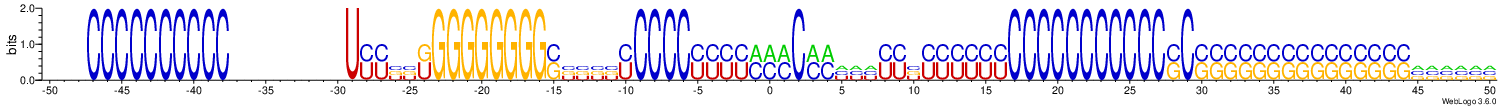

27_ICLIP_TDP43_hg19


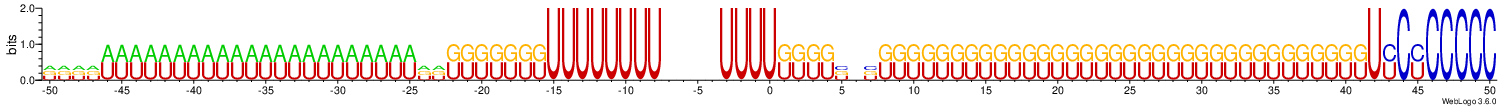

28_ICLIP_TIA1_hg19


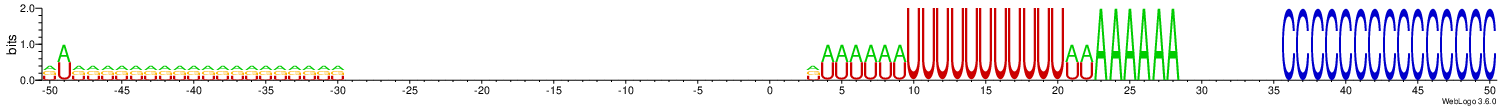

29_ICLIP_TIAL1_hg19


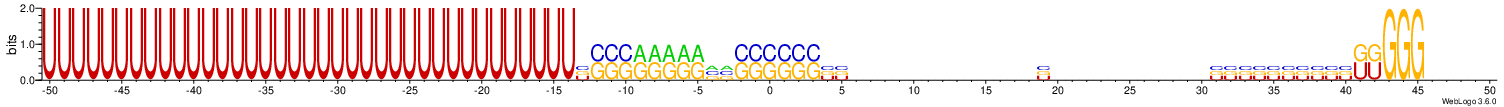

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


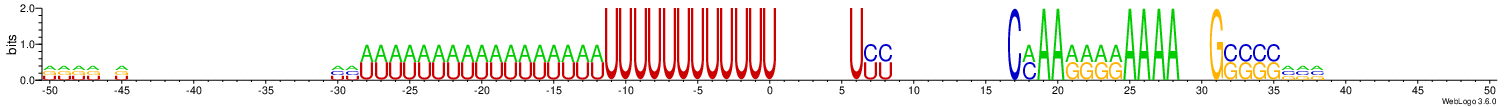

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


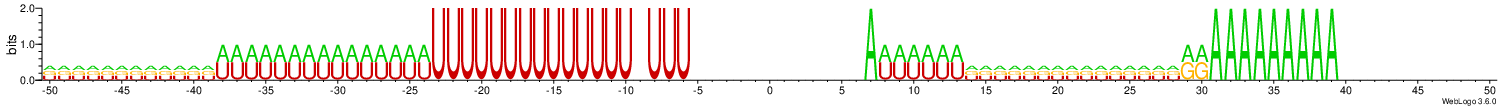

In [5]:
from IPython.display import display, Image

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        display(Image('results/set_%s/%s/max_activation.png' % (training_set_number, protein)))

In [3]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

# Sum of gradients across all layers saved under protein name.


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))

        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)
        
        
        for example in range (2000):

            layer_index = 0
            protein_grads = np.zeros((12,101))
            seed_input = X_test[example,:,:]
            for layer in model.layers:

                #Swap softmax with linear
                model.layers[layer_index].activation = activations.linear
                model = utils.apply_modifications(model)

                grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=seed_input)

                protein_grads[layer_index,:] = grads
                '''
                plt.figure(1)
                plt.subplot(12,1,layer_index+1, xticks = np.arange(0,101,10), yticks = [])    
                plt.imshow(grads.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
                '''
                layer_index += 1
            '''
            plt.figure(1)
            plt.show()
            plt.close()

            plt.subplot()   
            plt.imshow(sum(protein_grads).reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
            '''
            grads_sum = sum(protein_grads)

            n = 101
            window_size = 7 
            max_saliency_sum = 0
            # calculate sum of elements in the first window
            for i in range(window_size): 
                
                max_saliency_sum += grads_sum[i] 

            curr_sum = max_saliency_sum 


            # calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
            for i in range(window_size, n): 
                
                curr_sum += grads_sum[i] - grads_sum[i-window_size] 
                #print (curr_sum)
                if curr_sum > max_saliency_sum:
                    position = i 
                max_saliency_sum = max(max_saliency_sum, curr_sum)        


            highest_saliency_motif = [ seed_input[i,:] for i in range(position-7,position)]


            nucleotide = {0 : 'A', 1 : 'T', 2 : 'G', 3 : 'C'}
            motif_seq = []
            oh_motif = np.array(highest_saliency_motif)[:, 0:4]
            for entry in oh_motif:
                i = 0
                for nuc in entry:
                    if nuc == 1:
                        motif_seq.append(nucleotide[i])
                    i += 1  


            print (''.join(motif_seq))        

1_PARCLIP_AGO1234_hg19


/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


GCCTTTG
CTGTTTG
GCGTGCT
GCCTCGC
GGTGGTG
GGCTCCG
AGCACAC
CCGGGAC
GAGCACA
TTAACGT
ACAGCAC
AACCCCA
ACTGCGA
GGGCTGT
CGCTTAA
CTCGAAC
CTGTTGG
CAGCTCG
ACTGTCT
GTTTTGC


0
1
2
3
4
5
6
7
9.238833031442482
8
11.206667054910213
9
13.2317461296916
10
14.673681046813726
11
16.647964648902416
12
17.983760248869658
13
18.671730929985642
14
19.977126909419894
15
21.384457929059863
16
22.674919547513127
17
23.96172739379108
18
24.75700749270618
19
26.13076582364738
20
26.627745106816292
21
26.67575133778155
22
27.613784555345774
23
28.396731236949563
24
30.439484959468246
25
30.550200259312987
26
31.59738858230412
27
33.73034641891718
28
35.82068497873843
29
36.79792653396726
30
37.58843699283898
31
37.68779797293246
32
39.29480763338506
33
40.06463366560638
34
40.05343034863472
35
40.45522581040859
36
40.85475394129753
37
42.187351047992706
38
42.62979391217232
39
43.99948787689209
40
44.212852239608765
41
45.53358094394207
42
47.40210500359535
43
47.89936941862106
44
48.78605133295059
45
48.79938009381294
46
49.99632930755615
47
50.81688657402992
48
52.99620293080807
49
51.8607943803072
50
54.0456839799881
51
53.88474750518799
52
53.96101090312004
53
51.56753

54.0456839799881

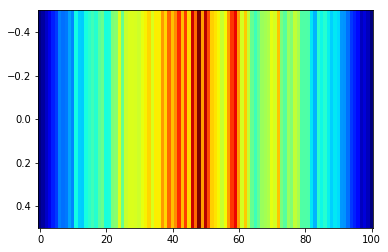

In [39]:
plt.subplot()   
plt.imshow(sum(protein_grads).reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')

grads_sum = sum(protein_grads)

n = 101
window_size = 7 
max_saliency_sum = 0
# calculate sum of elements in the first window
for i in range(window_size): 
    print(i)
    max_saliency_sum += grads_sum[i] 
        
curr_sum = max_saliency_sum 


# calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
for i in range(window_size, n): 
    print (i)
    curr_sum += grads_sum[i] - grads_sum[i-window_size] 
    print (curr_sum)
    if curr_sum > max_saliency_sum:
        position = i 
    max_saliency_sum = max(max_saliency_sum, curr_sum)

In [80]:
grads_sum[47]+grads_sum[48]+grads_sum[49]+grads_sum[50]+ grads_sum[46]+ grads_sum[45]+ grads_sum[44]
seed_input.shape
highest_saliency_motif = [ seed_input[i,:] for i in range(position-7,position)]


nucleotide = {0 : 'A', 1 : 'T', 2 : 'G', 3 : 'C'}
motif_seq = []
oh_motif = np.array(highest_saliency_motif)[:, 0:4]
for entry in oh_motif:
    i = 0
    for nuc in entry:
        if nuc == 1:
            motif_seq.append(nucleotide[i])
        i += 1  


print (''.join(motif_seq))

GCCTTTG


In [ ]:
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

def onehot_to_seq(encoded_sequence):
    nucleotide = {0 : 'A', 1 : 'T', 2 : 'G', 3 : 'C'}
    sequence = []
    for entry in encoded_sequence:
        i = 0
        for nuc in entry:
            if nuc == 1:
                sequence.append(nucleotide[i])
            i += 1  
    return sequence

# Sum of gradients across all layers saved under protein name.


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

positive_samples = []
data_sources, X_test = load_data_sources("1_PARCLIP_AGO1234_hg19","test",0,*experiment_set)
y_test = get_class("1_PARCLIP_AGO1234_hg19","test",0)
y_test = y_test = y_test [:,1]

for i in range (len(y_test)):
    if y_test[i] == 1:
        positive_samples.append(X_test[i])
positive_samples = np.array(positive_samples)  

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))

            #Load data for testing purposes.


            for example in range (2000):

                layer_index = 0
                protein_grads = np.zeros((12,101))
                seed_input = positive_samples[example,:,:]

                for layer in model.layers:

                    #Swap softmax with linear
                    model.layers[layer_index].activation = activations.linear
                    model = utils.apply_modifications(model)
                    #Calculate saliency
                    grads = visualize_saliency(model, layer_index, filter_indices=1, seed_input=seed_input)
                    protein_grads[layer_index,:] = grads
                    layer_index += 1

                grads_sum = sum(protein_grads)
                '''
                #Plot the sum of saliency across all layers.
                plt.subplot()   
                plt.imshow(grads.sum.reshape((1, -1)), aspect='auto', cmap='jet', interpolation='nearest')
                plt.show()
                plt.close()
                '''
                #Find the window of 7 nucletides with the highest sailency using highest sum as a measure.
                n = 101
                window_size = 7 
                max_saliency_sum = 0
                # calculate sum of elements in the first window
                for i in range(window_size): 

                    max_saliency_sum += grads_sum[i] 

                curr_sum = max_saliency_sum 

                # calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
                for i in range(window_size, n): 

                    curr_sum += grads_sum[i] - grads_sum[i-window_size] 
                    #print (curr_sum)
                    if curr_sum > max_saliency_sum:
                        position = i 
                    max_saliency_sum = max(max_saliency_sum, curr_sum)        

                # After obtainig the position value of the last nucleotide in the 7 nucleotides window, we extract features from the input matrix.
                highest_saliency_motif = [ seed_input[i,:] for i in range(position-7,position)]
                oh_motif = np.array(highest_saliency_motif)[:, 0:4]
                motif_seq = onehot_to_seq(oh_motif)

                with open ("results/set_%s/%s/saliency_motifs.txt" % (training_set_number, protein), "a") as motif_file:
                    motif_file.write('{} {}\n'.format(example, ''.join(motif_seq)))

         


In [28]:
#Saliency motifs generated on saliency of whole positive data set for each protein.
from vis.visualization import visualize_activation, visualize_saliency
from vis.utils import utils
from keras import activations
from keras.models import model_from_json

def onehot_to_seq(encoded_sequence):
    nucleotide = {0 : 'A', 1 : 'U', 2 : 'G', 3 : 'C'}
    sequence = []
    for entry in encoded_sequence:
        i = 0
        for nuc in entry:
            if nuc == 1:
                sequence.append(nucleotide[i])
            i += 1  
    return sequence

# Sum of gradients across all layers saved under protein name.

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (1):
    #Load the saliency gradients dictionary for all the proteins.
    with open ("results/set_%s/gradients.pickle" % (training_set_number), "r") as pickle_file:
        gradients = pickle.load(pickle_file)
    
        for protein in protein_list:
            print (protein)
            
            positive_samples = []
            data_sources, X_test = load_data_sources(protein,"test",0,*experiment_set)
            y_test = get_class(protein,"test",0)
            y_test = y_test = y_test [:,1]

            for i in range (len(y_test)):
                if y_test[i] == 1:
                    positive_samples.append(X_test[i])
            positive_samples = np.array(positive_samples)  

            grads_sum = gradients[protein]
           
            #Find the window of 7 nucletides with the highest sailency using highest sum as a measure.
            n = 101
            window_size = 7 
            max_saliency_sum = 0
            
            # calculate sum of elements in the first window
            for i in range(window_size): 

                max_saliency_sum += grads_sum[i] 

            curr_sum = max_saliency_sum 

            # calculate sum for each next position by adding the value of current position and removing the value of the first position of previous window. Position is the index of the last element that gives highest sum.
            for i in range(window_size, n): 

                curr_sum += grads_sum[i] - grads_sum[i-window_size] 
                #print (curr_sum)
                if curr_sum > max_saliency_sum:
                    position = i 
                max_saliency_sum = max(max_saliency_sum, curr_sum)

            for example in range (2000):
                seed_input = positive_samples[example,:,:]


                # After obtainig the position value of the last nucleotide in the 7 nucleotides window, we extract features from the input matrix.
                highest_saliency_motif = [ seed_input[i,:] for i in range(position-7,position)]
                oh_motif = np.array(highest_saliency_motif)[:, 0:4]
                motif_seq = onehot_to_seq(oh_motif)

                with open ("results/set_%s/%s/saliency_motifs_test.txt" % (training_set_number, protein), "a") as motif_file:
                    motif_file.write('{}\t{}\n'.format(example+1, ''.join(motif_seq)))




1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19

1_PARCLIP_AGO1234_hg19


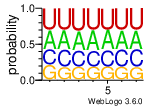

2_PARCLIP_AGO2MNASE_hg19


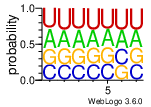

3_HITSCLIP_Ago2_binding_clusters


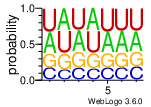

4_HITSCLIP_Ago2_binding_clusters_2


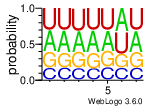

5_CLIPSEQ_AGO2_hg19


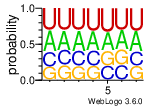

6_CLIP-seq-eIF4AIII_1


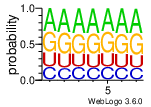

7_CLIP-seq-eIF4AIII_2


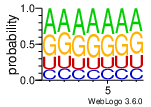

8_PARCLIP_ELAVL1_hg19


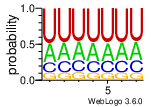

9_PARCLIP_ELAVL1MNASE_hg19


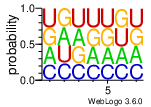

10_PARCLIP_ELAVL1A_hg19


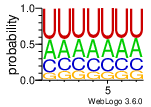

10_PARCLIP_ELAVL1A_hg19


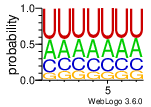

12_PARCLIP_EWSR1_hg19


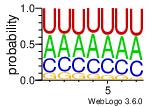

13_PARCLIP_FUS_hg19


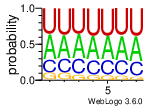

14_PARCLIP_FUS_mut_hg19


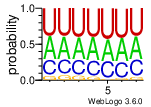

15_PARCLIP_IGF2BP123_hg19


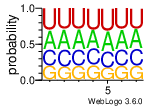

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


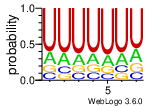

17_ICLIP_HNRNPC_hg19


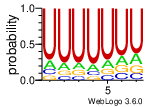

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


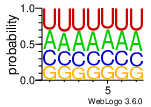

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


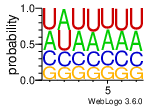

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


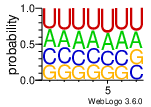

21_PARCLIP_MOV10_Sievers_hg19


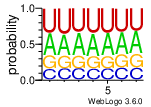

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


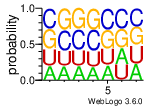

23_PARCLIP_PUM2_hg19


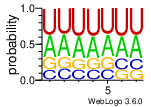

24_PARCLIP_QKI_hg19


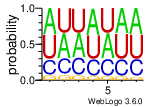

25_CLIPSEQ_SFRS1_hg19


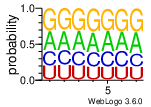

26_PARCLIP_TAF15_hg19


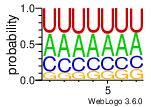

27_ICLIP_TDP43_hg19


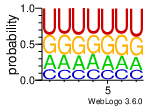

28_ICLIP_TIA1_hg19


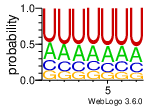

29_ICLIP_TIAL1_hg19


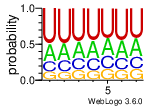

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


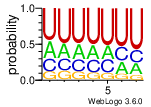

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


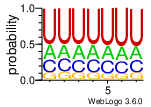

In [37]:
import os
from IPython.display import display, Image

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        cmd = ("weblogo -f results/set_%s/%s/saliency_motifs_test.txt -D table -F png -o results/set_%s/%s/saliency_test.png --errorbars NO --show-xaxis YES --show-yaxis YES -U probability -A rna --composition none --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U'" % (training_set_number, protein, training_set_number, protein)) 
        os.system(cmd)
        display(Image('results/set_%s/%s/saliency_test.png' % (training_set_number, protein)))

1_PARCLIP_AGO1234_hg19


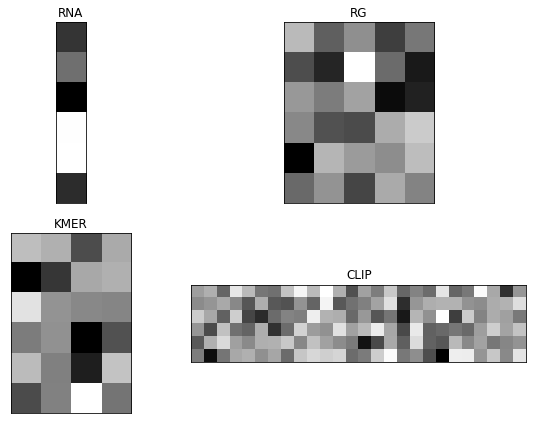

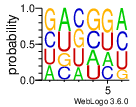

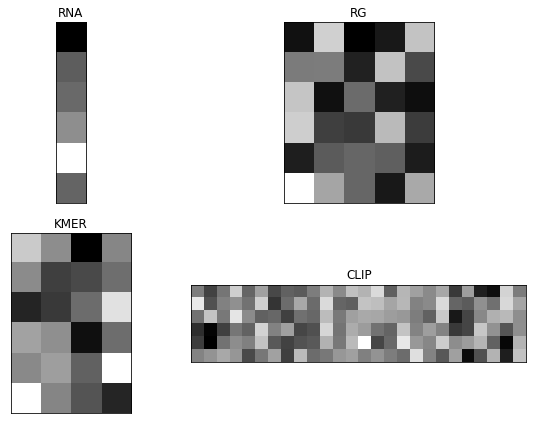

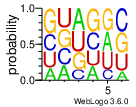

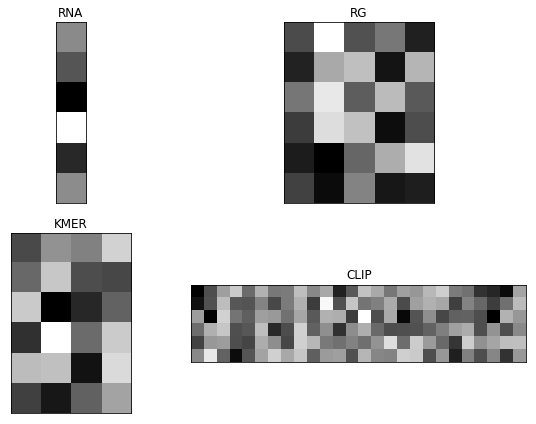

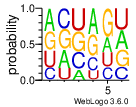

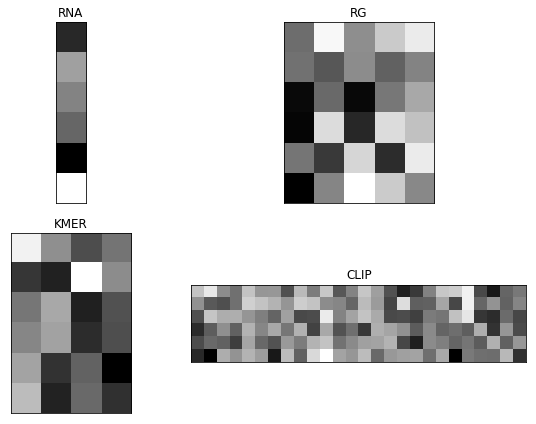

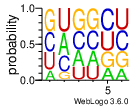

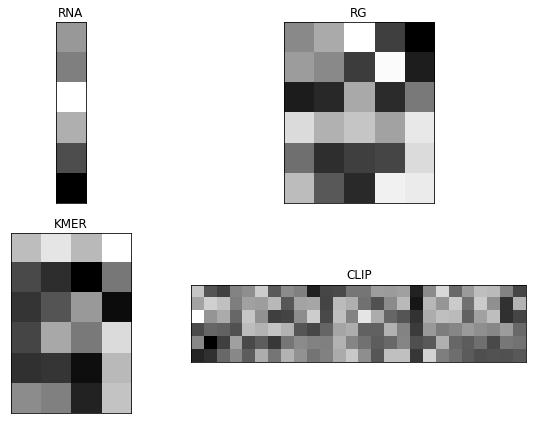

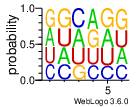

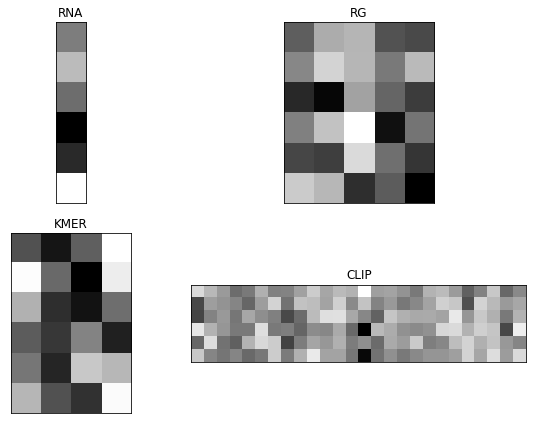

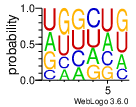

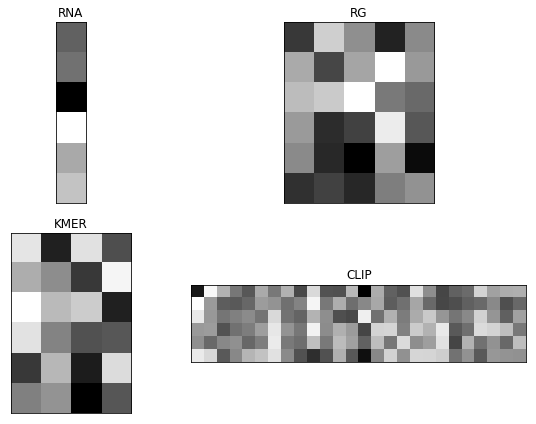

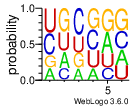

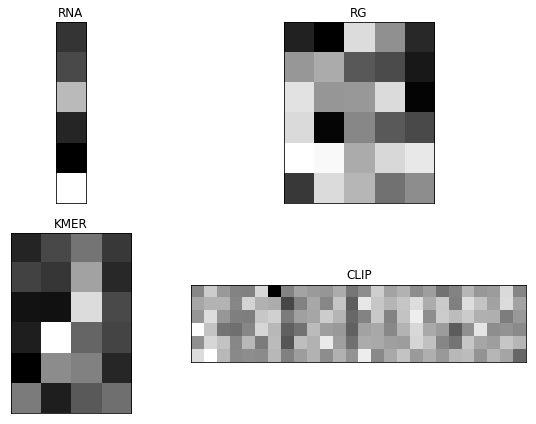

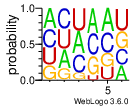

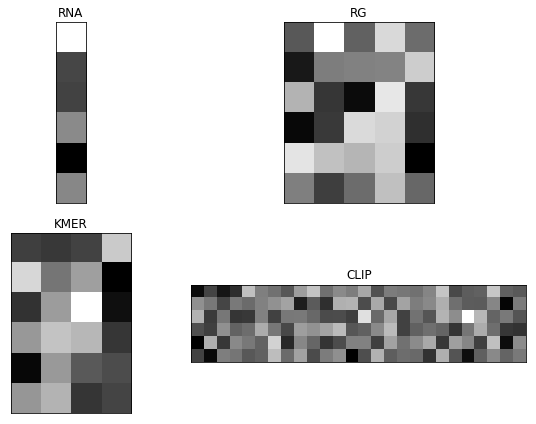

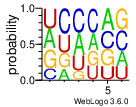

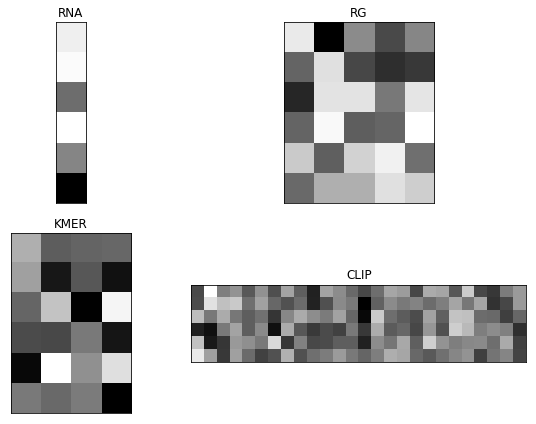

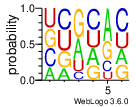

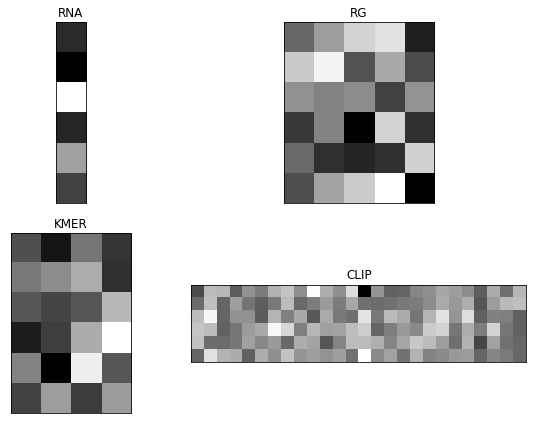

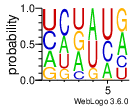

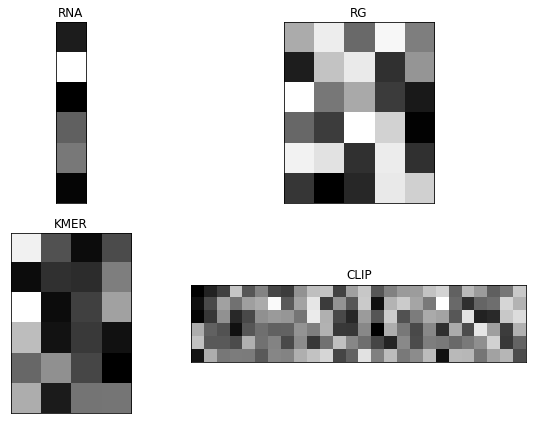

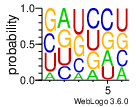

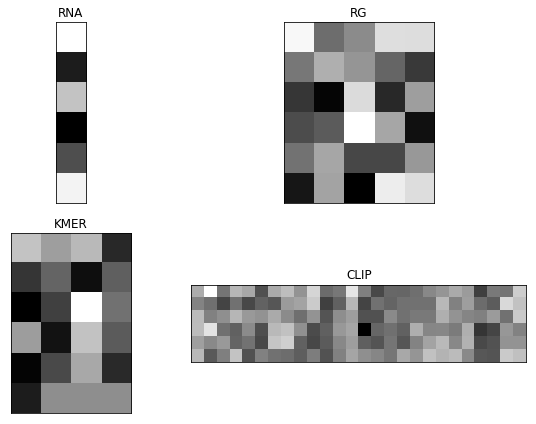

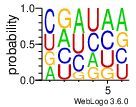

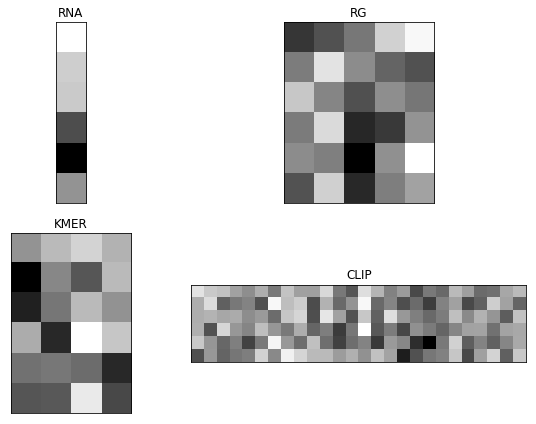

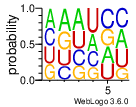

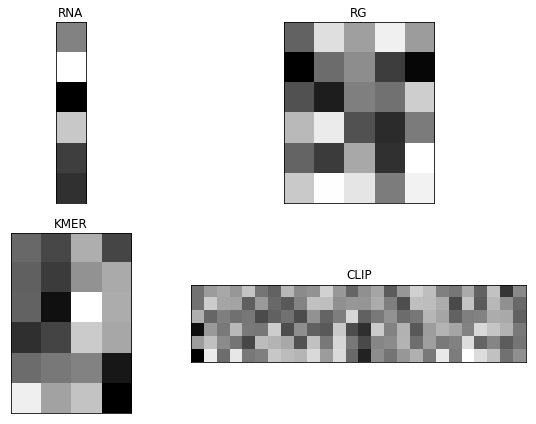

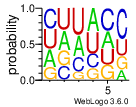

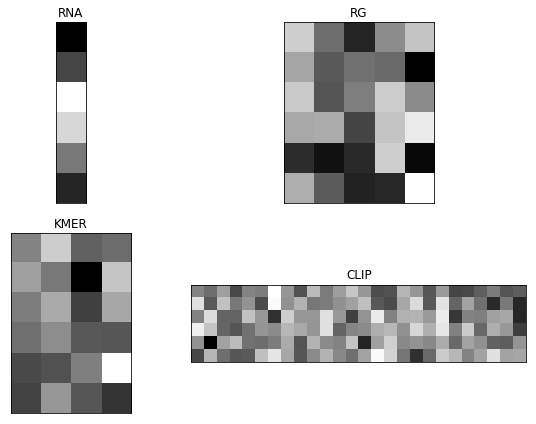

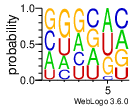

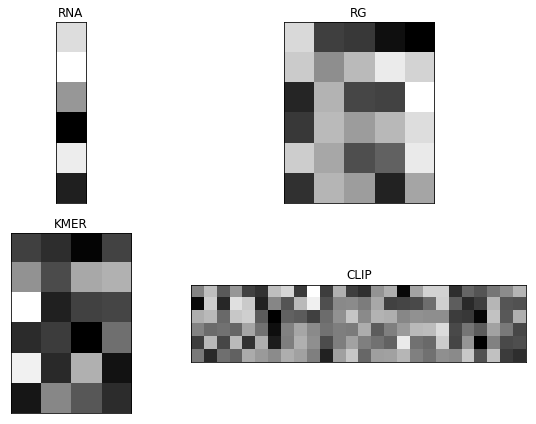

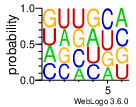

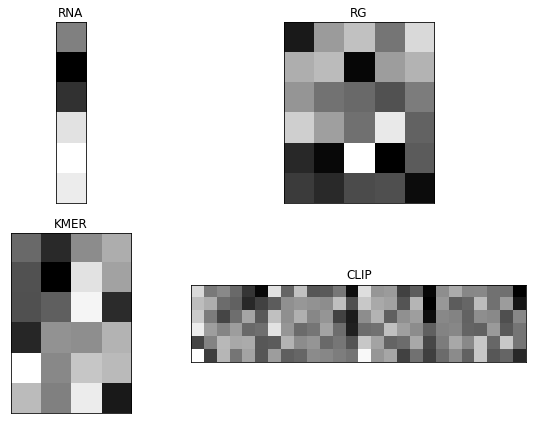

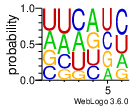

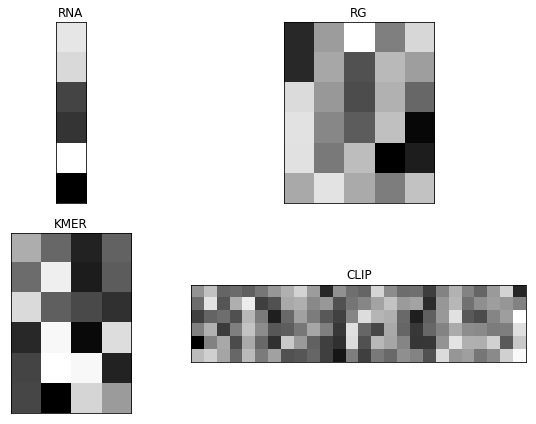

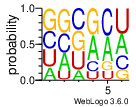

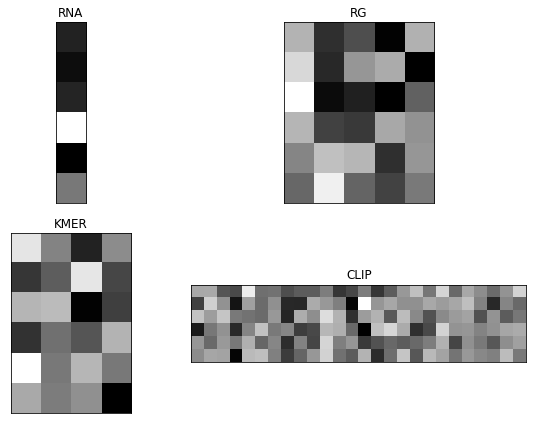

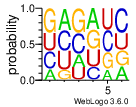

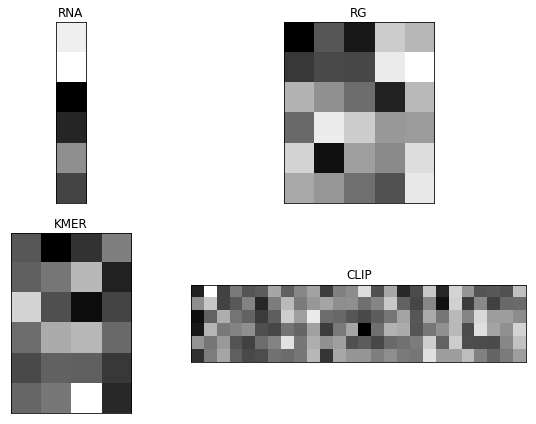

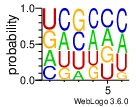

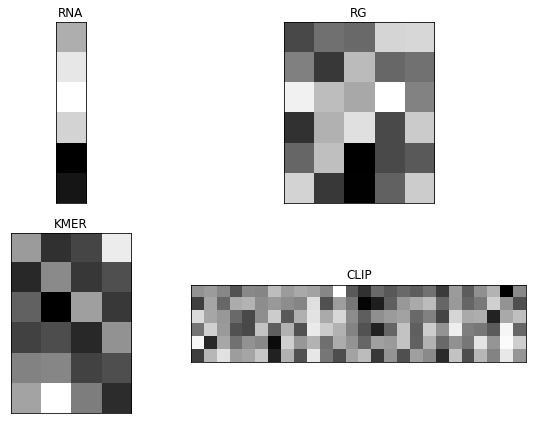

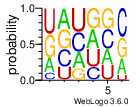

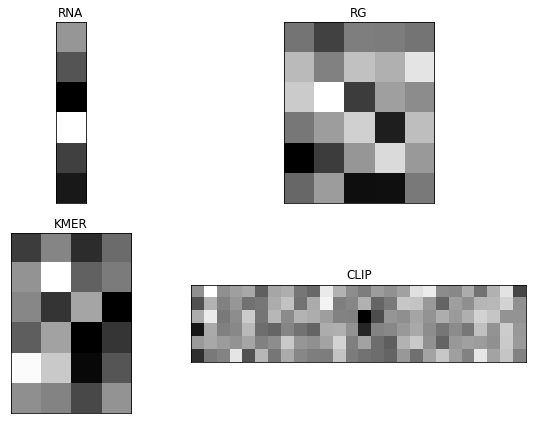

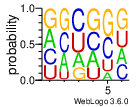

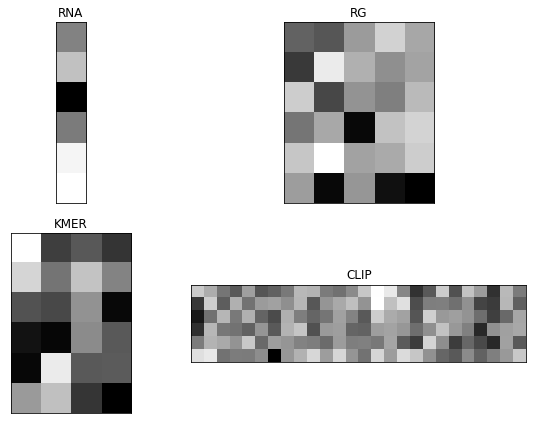

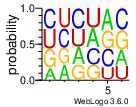

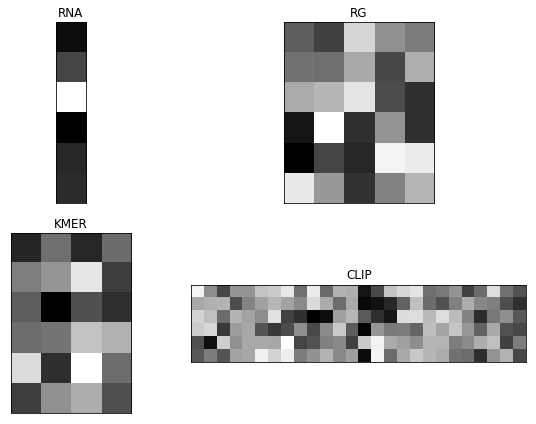

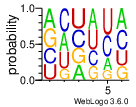

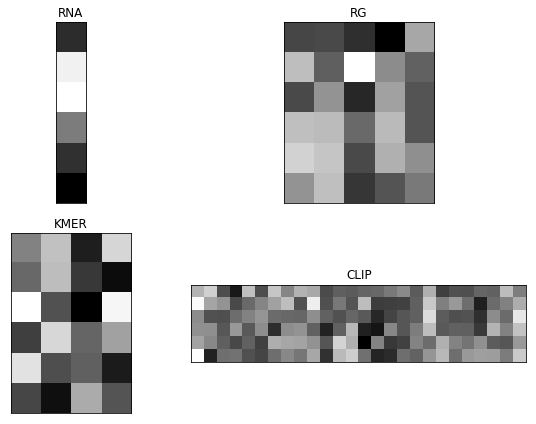

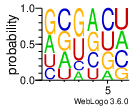

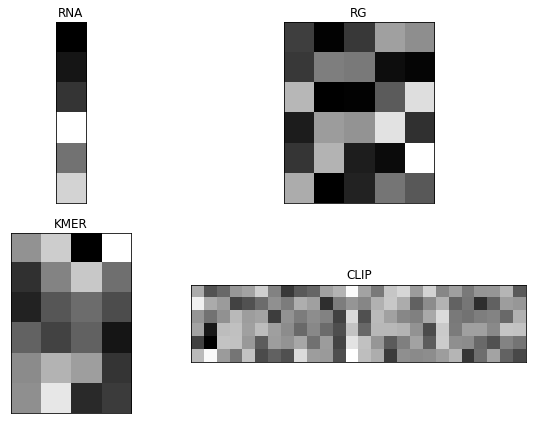

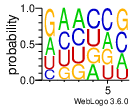

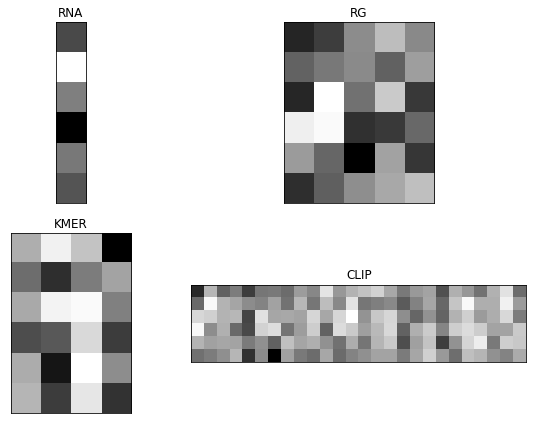

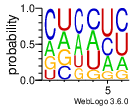

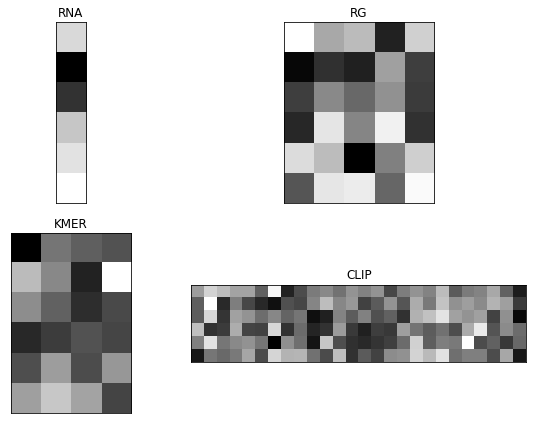

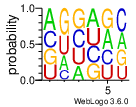

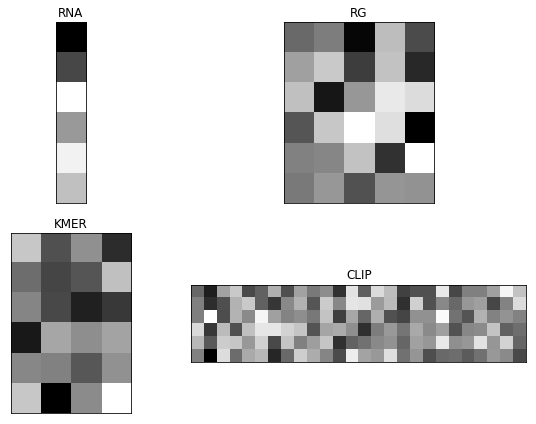

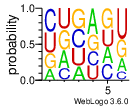

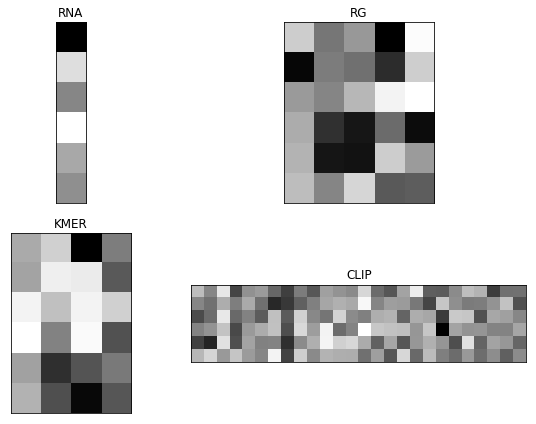

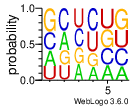

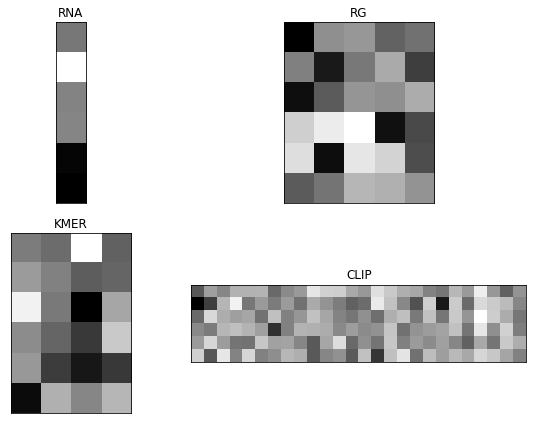

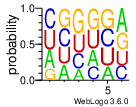

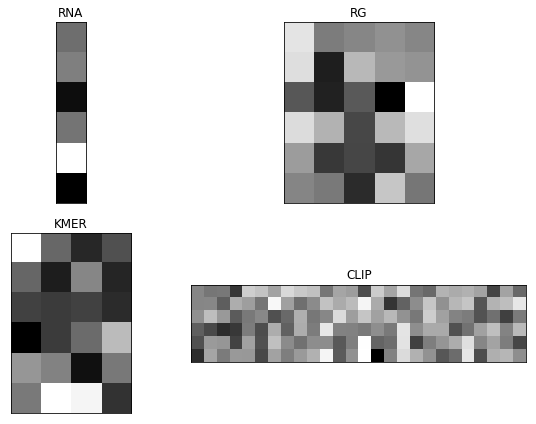

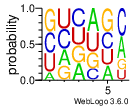

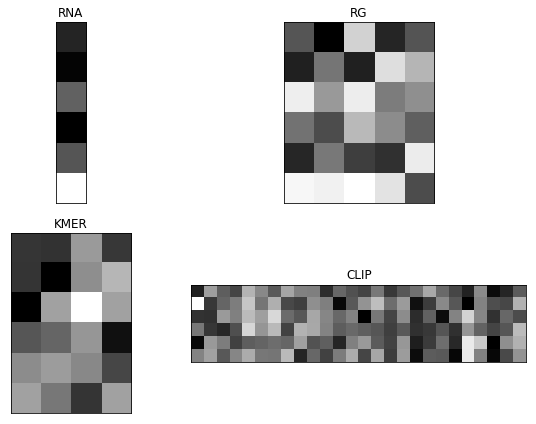

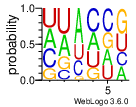

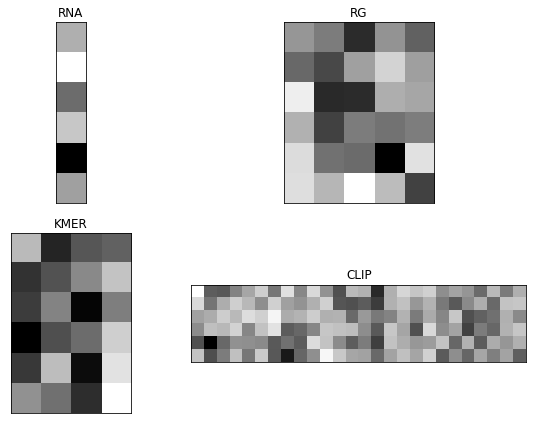

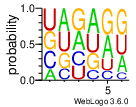

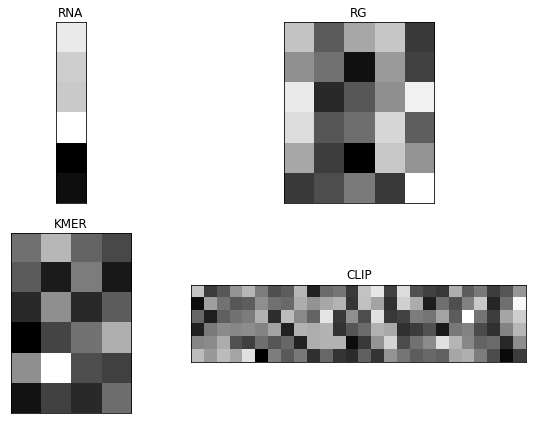

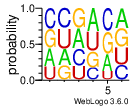

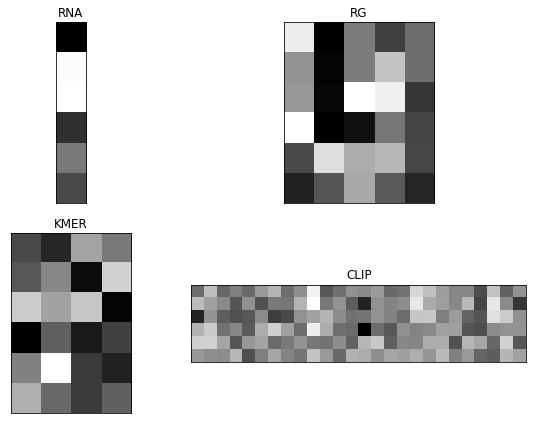

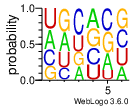

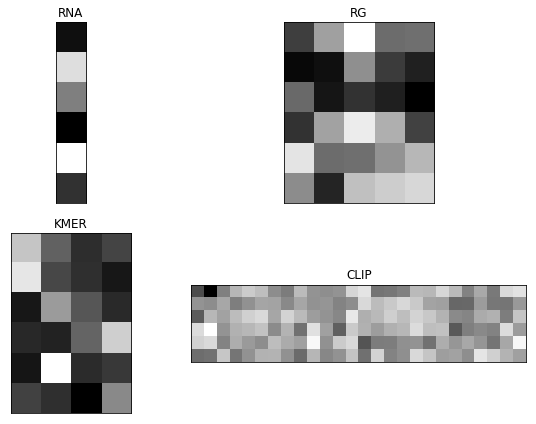

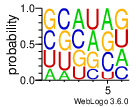

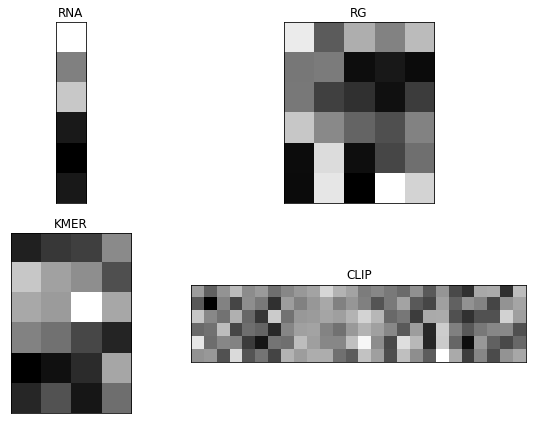

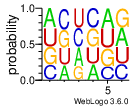

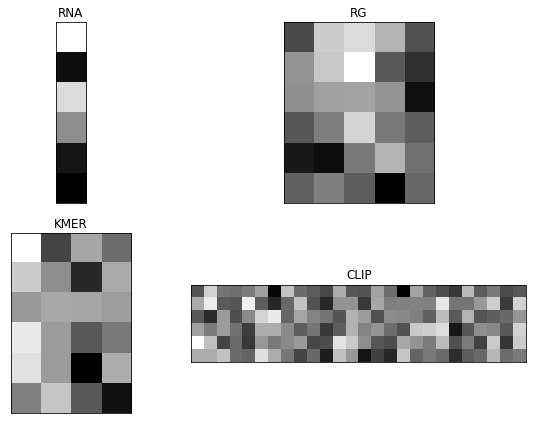

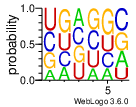

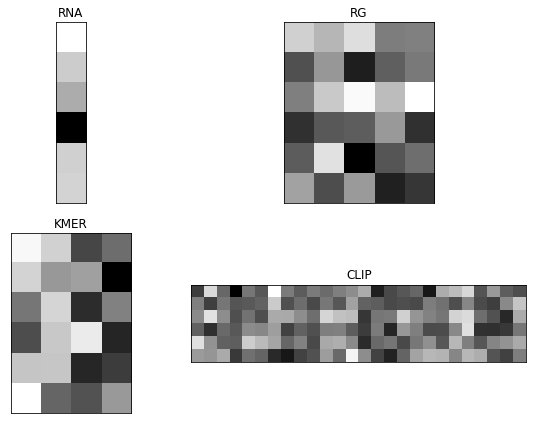

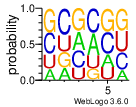

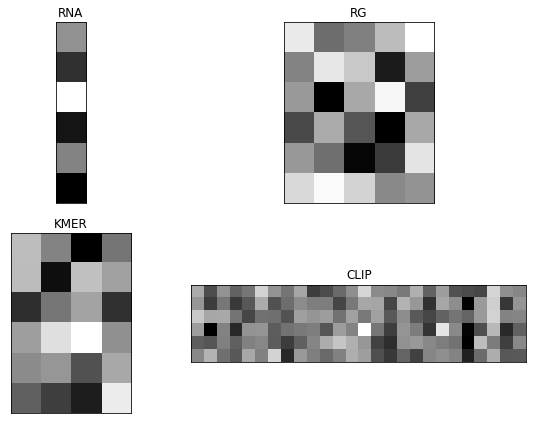

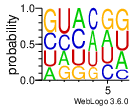

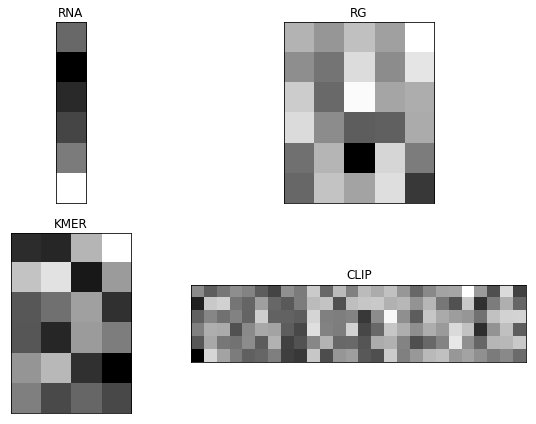

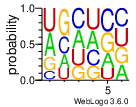

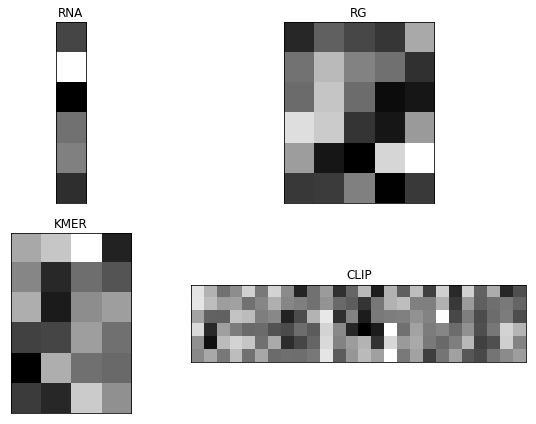

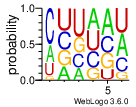

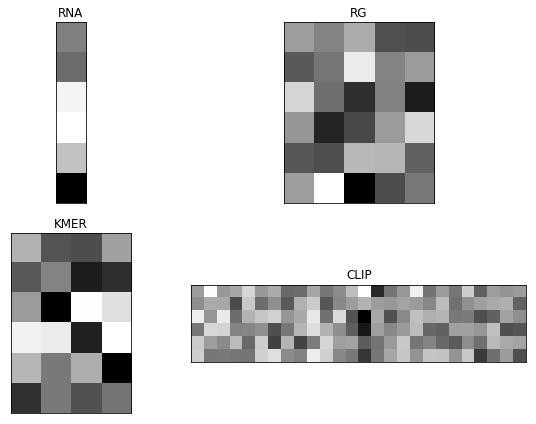

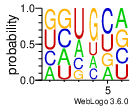

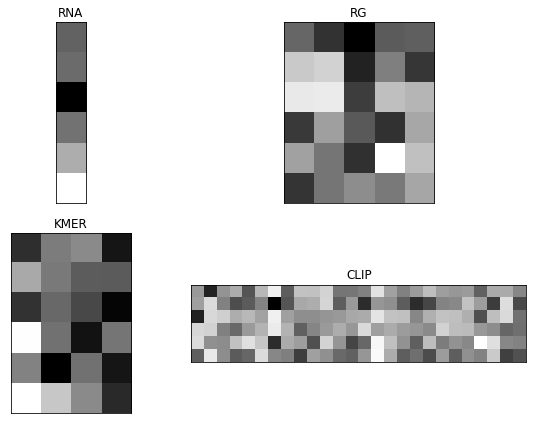

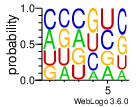

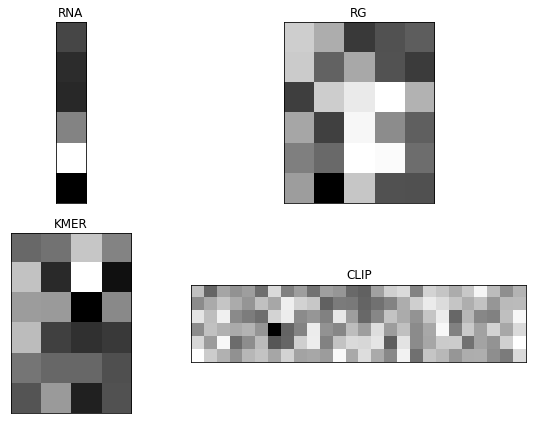

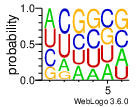

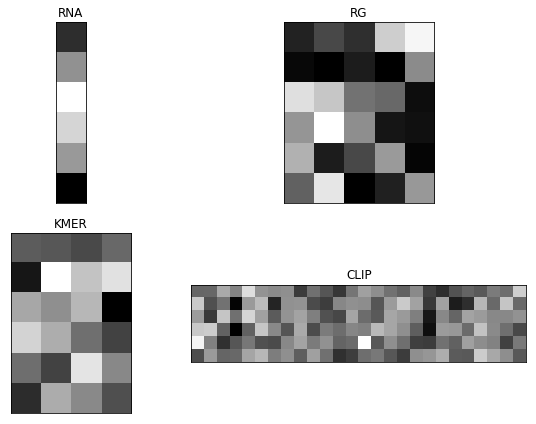

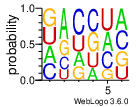

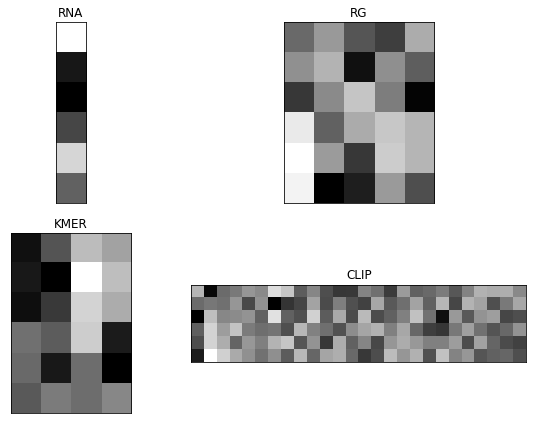

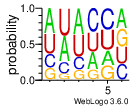

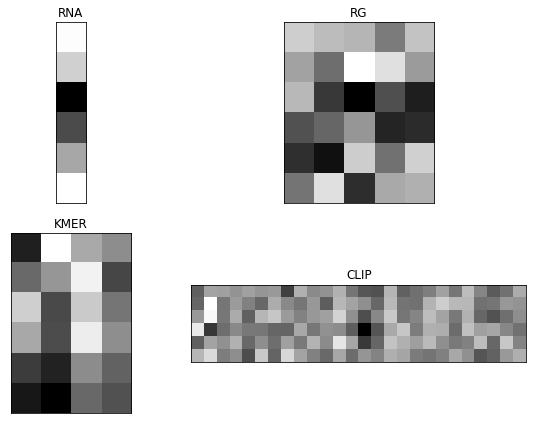

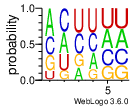

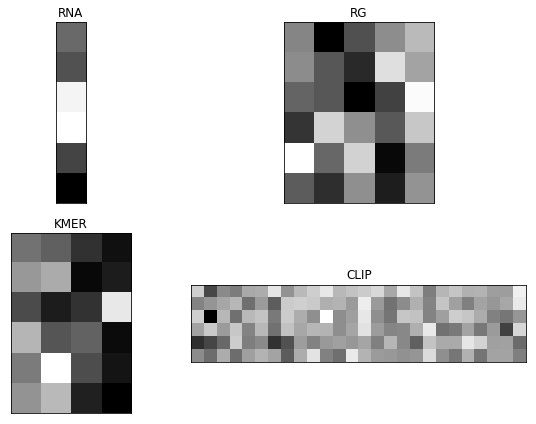

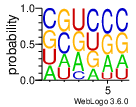

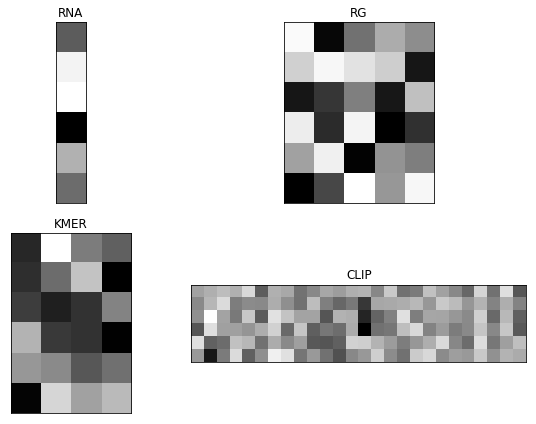

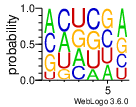

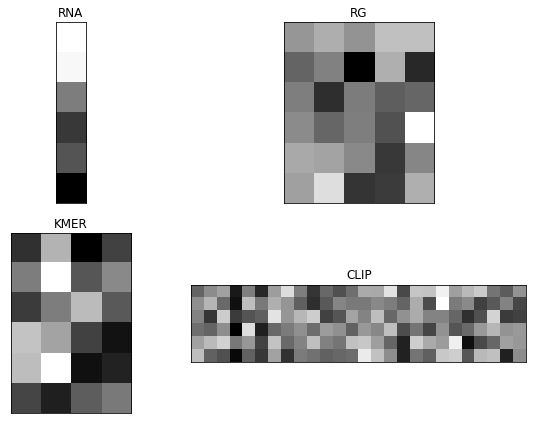

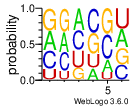

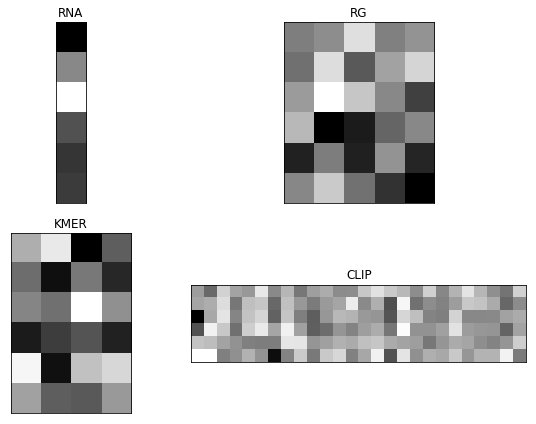

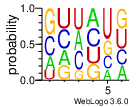

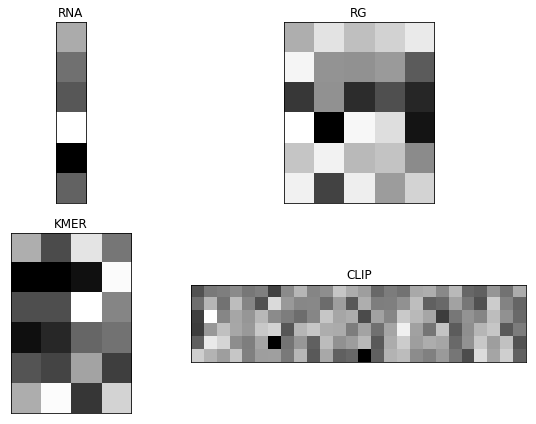

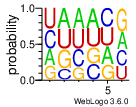

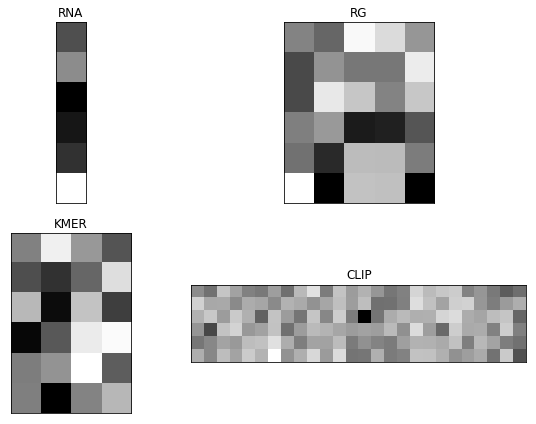

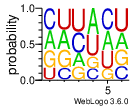

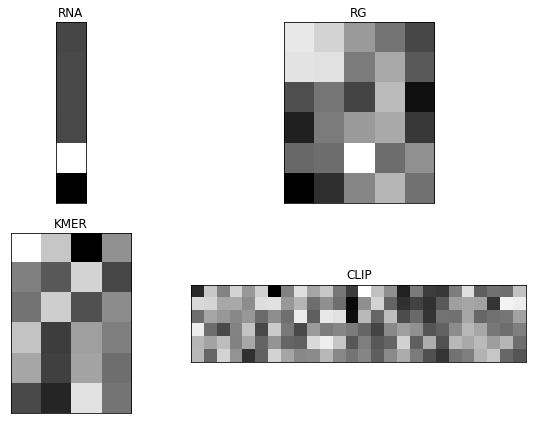

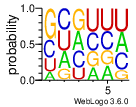

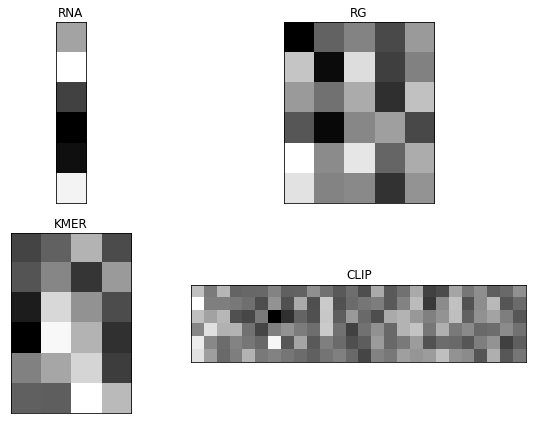

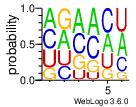

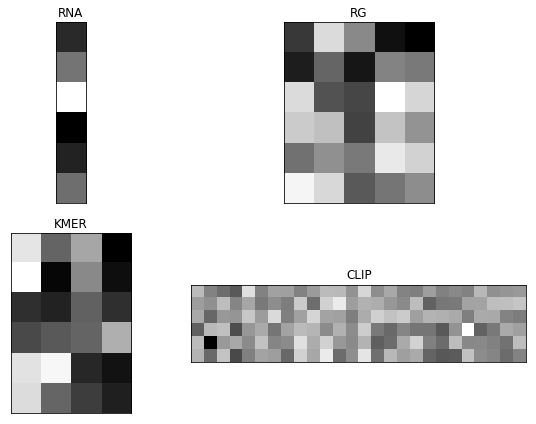

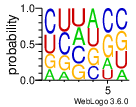

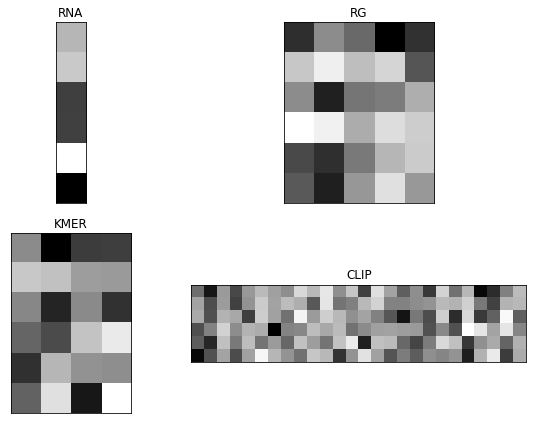

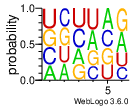

'\n RNA : probability of double stranded structure\n RG :exon, intron, 5\xe2\x80\x99UTR, 3\xe2\x80\x99UTR, CDS\n KMER : A, U, G, C\n CLIP \n'

In [6]:
from keras.models import model_from_json
from IPython.display import display, Image


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)
            
            for f_index in range(filters.shape[2]):
                #plt.imshow(filters[:, :, f_index], cmap = 'jet')
                #plt.show()
                
                d_sources_filters = {'KMER': filters[:, 0:4 , f_index], 'RNA': filters[:, 4:5 , f_index], 'RG': filters[:, 5:10 , f_index], 'CLIP': filters[:, 10:36 , f_index]}
                fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 6),
                                        subplot_kw={'xticks': [], 'yticks': []})

                for ax, d_source in zip(axs.flat, d_sources_filters.keys()):
                    ax.imshow(d_sources_filters[d_source], cmap='binary')
                    ax.set_title(str(d_source))

                plt.tight_layout()
                plt.show()
                
                nucleotides = {'A' : filters[:, 0, f_index], 'T' : filters[:, 1, f_index], 'G' : filters[:, 2, f_index], 'C' : filters[:, 3, f_index]} 
                with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "w") as sequences_f:
                     sequences_f.write('P0 A U G C\n')

                for i in range (len(nucleotides['A'])):
                     with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "a") as sequences_f:
                        sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))


        

                cmd = ("weblogo -f results/set_%s/%s/filters/filter_vis_%s.txt -D transfac -F png -o results/set_%s/%s/filters/filter_vis_%s.png -U probability --errorbars NO --show-xaxis YES --show-yaxis YES -A rna --composition none -n 6 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, f_index, training_set_number, protein, f_index)) 
                os.system(cmd)
                display(Image('results/set_%s/%s/filters/filter_vis_%s.png' % (training_set_number, protein, f_index)))
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''


In [85]:
def datasource_channels(protein, t_data, training_set_number, *args):
    '''Returns the number of channels for each datasource in an input matrix Output: [KMER, RNA, RG, CLIP]'''
    channels = np.zeros(4)
    
    for arg in args:
        
        if arg == 'KMER':
            channels[0] = get_seq(protein, t_data, training_set_number).shape[2]
                
        if arg == 'RNA': 
            channels[1] = get_fold(protein, t_data, training_set_number).shape[2]
           
        if arg == 'RG':   
            
            channels[2] = get_region(protein, t_data, training_set_number).shape[2]
           
        if arg == 'CLIP': 
           
            channels[3] = get_cobinding(protein, t_data, training_set_number).shape[2]

     

    return channels


In [89]:
f = datasource_channels('1_PARCLIP_AGO1234_hg19', 'test', 0, *experiment_set)
print (np.cumsum(f))

[ 4.  5. 10. 36.]


In [30]:
# from keras.models import model_from_json
from IPython.display import display, Image


protein_list = ["1_PARCLIP_AGO1234_hg19"]#, "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']

for training_set_number in range (1):
    for protein in protein_list:
        print (protein)
        
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            model = model_from_json(json)
            model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
            filters, biases = model.layers[0].get_weights()
            
            filter_min, filter_max = filters.min(), filters.max()
            #normalize filter values
            filters = (filters - filter_min) / (filter_max - filter_min)

            fig, axs = plt.subplots(nrows=10, ncols=6, figsize=(24, 16),
                    subplot_kw={'xticks': [], 'yticks': []})

           
            for ax, f_index in zip(axs.flat, range(filters.shape[2])):
                ax.imshow(filters[:, 0:4 , f_index], cmap='binary')
                                 
            plt.subplots_adjust(hspace=0.001)
            plt.show()
            '''
            d_sources_filters = {'KMER': filters[:, 0:4 , f_index], 'RNA': filters[:, 4:5 , f_index], 'RG': filters[:, 5:10 , f_index], 'CLIP': filters[:, 10:36 , f_index]}
            fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 6),
                                    subplot_kw={'xticks': [], 'yticks': []})

            for ax, d_source in zip(axs.flat, d_sources_filters.keys()):
                ax.imshow(d_sources_filters[d_source], cmap='binary')
                ax.set_title(str(d_source))

            plt.tight_layout()
            plt.show()

            nucleotides = {'A' : filters[:, 0, f_index], 'T' : filters[:, 1, f_index], 'G' : filters[:, 2, f_index], 'C' : filters[:, 3, f_index]} 
            with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "w") as sequences_f:
                 sequences_f.write('P0 A U G C\n')

            for i in range (len(nucleotides['A'])):
                 with open ("results/set_%s/%s/filters/filter_vis_%s.txt" % (training_set_number, protein, f_index), "a") as sequences_f:
                    sequences_f.write('P{} {} {} {} {}\n'.format(i+1, nucleotides['A'][i], nucleotides['T'][i], nucleotides['G'][i], nucleotides['C'][i]))




            cmd = ("weblogo -f results/set_%s/%s/filters/filter_vis_%s.txt -D transfac -F png -o results/set_%s/%s/filters/filter_vis_%s.png -U probability --errorbars NO --show-xaxis YES --show-yaxis YES -A rna --composition none -n 6 --color '#00CC00' 'A' 'A' --color '#0000CC' 'C' 'C' --color '#FFB300' 'G' 'G' --color '#CC0000' 'U' 'U' " % (training_set_number, protein, f_index, training_set_number, protein, f_index)) 
            os.system(cmd)
            display(Image('results/set_%s/%s/filters/filter_vis_%s.png' % (training_set_number, protein, f_index)))
            '''
'''
 RNA : probability of double stranded structure
 RG :exon, intron, 5’UTR, 3’UTR, CDS
 KMER : A, U, G, C
 CLIP 
'''


1_PARCLIP_AGO1234_hg19


ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[node conv1d_1_28/random_uniform/sub (defined at /home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4139)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0.204124153>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]

Caused by op u'conv1d_1_28/random_uniform/sub', defined at:
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/local/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-30-32799c542a2b>", line 15, in <module>
    model = model_from_json(json)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/saving.py", line 492, in model_from_json
    return deserialize(config, custom_objects=custom_objects)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/layers/__init__.py", line 55, in deserialize
    printable_module_name='layer')
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/utils/generic_utils.py", line 145, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/sequential.py", line 301, in from_config
    model.add(layer)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/sequential.py", line 165, in add
    layer(x)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/base_layer.py", line 431, in __call__
    self.build(unpack_singleton(input_shapes))
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/layers/convolutional.py", line 141, in build
    constraint=self.kernel_constraint)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/engine/base_layer.py", line 249, in add_weight
    weight = K.variable(initializer(shape),
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/initializers.py", line 218, in __call__
    dtype=dtype, seed=self.seed)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py", line 4139, in random_uniform
    dtype=dtype, seed=seed)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/ops/random_ops.py", line 244, in random_uniform
    return math_ops.add(rnd * (maxval - minval), minval, name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/ops/math_ops.py", line 866, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 8318, in sub
    "Sub", x=x, y=y, name=name)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [] and type float
	 [[node conv1d_1_28/random_uniform/sub (defined at /home/alovse/local/miniconda3/envs/rnap/lib/python2.7/site-packages/keras/backend/tensorflow_backend.py:4139)  = Const[dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0.204124153>, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
